In [1]:
# Import libraries and modules
import os
import os.path as osp
import json
import clip
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import itertools
import seaborn as sns
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import numpy as np

/Users/matthewheng/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1.0 Prepare the frames from clips 


In [2]:
# Note: This function is already run to download the videos in the local directory named download_videos.

def download_youtube_videos():
    from pytube import YouTube
    import os
    import ssl
    
    # Bypass SSL certificate verification
    ssl._create_default_https_context = ssl._create_unverified_context
    


    # retrieve the youtube videos ids
    path = './metafiles/mlda_data.json'
    with open(path, 'r') as f:
        data = json.load(f)

    youtube_ids = []
    # we only run 100loops to get 100 videos
    for key in iter(data.keys()):
        youtube_ids.append(data[key])
        #if len(youtube_ids == 100): break
    
    # now youtube_ids = ['0AC26eIQcdo', '0LQnFOUmdvc', '0F26xJPD1C4', '4kEt_Z--3O0',...]

    
    
    # some youtube contents are age restricted, unable to download
    restricted = []

    # start to download the youtube videos
    for i, yt_id in enumerate(youtube_ids):
        youtube_video_url = f'https://www.youtube.com/watch?v={yt_id}'
    
        try: 
            # Create a YouTube object
            yt = YouTube(youtube_video_url,use_oauth=True,allow_oauth_cache=True)
    
            # Get the highest resolution stream
            stream = yt.streams.get_highest_resolution()
    
            # Specify the directory where you want to download the video
            download_dir = 'download_videos'
    
            # Create the directory if it doesn't exist
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)
    
            # Download the video into the specified directory
            filename = stream.download(output_path=download_dir)
    
            new_filename = os.path.join(download_dir, f'{yt_id}.mp4')  # Change 'new_video_name' to your desired filename
            
            # Rename the file
            os.rename(filename, new_filename)
            print(f"Downloaded {i}, id: {yt_id}")
        except Exception:
            print(f"Restricted {i}, id: {yt_id}")
            restricted.append(yt_id)
            continue        
        
    print("restricted: ", restricted)

# download_youtube_videos()
# Now, the downloaded youtube videos are in the download_videos directory

# 1.1 Cut the clips into frames

In [3]:
# sample frames of clips with frame rate = 10/s
def sample_frames(video_path, output_frame_image_dir, output_frame_description_dir, frame_rate, caption_clips, i):
    # Open the video file
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_frame_image_dir, exist_ok=True)
    os.makedirs(output_frame_description_dir, exist_ok=True)
    
    # Initialize variables
    count = 0
    frame_num = 0
    
    # Loop through the video frames
    while success:
        # Save frame at the specified frame rate
        if count % frame_rate == 0:
            output_frame_path = os.path.join(output_frame_image_dir, f"frame_{frame_num}.jpg")
            output_frame_description_path = os.path.join(output_frame_description_dir, f"frame_{frame_num}.txt")
            cv2.imwrite(output_frame_path, image)  # Save the frame as a JPEG image
            with open(output_frame_description_path, 'w') as f:
                f.write(caption_clips[i])
            frame_num += 1
        
        # Read the next frame
        success, image = vidcap.read()
        count += 1

    # Release the video capture object
    vidcap.release()


 
def sample_all_frames(path_to_clips, caption_clips):

    n = len(path_to_clips)
    for i in range(n):
        video_path =  './video_clips/' + path_to_clips[i]
        output_frame_image_dir = './clips_frames/' + path_to_clips[i][:-4]
        output_frame_description_dir = './clips_frames_description/' + path_to_clips[i][:-4]
        frame_rate = 10  # Sample every 10 frames per second
        sample_frames(video_path, output_frame_image_dir, output_frame_description_dir, frame_rate, caption_clips, i)
        print(f"Completed sample frames from clip {i}/{n}")


# Note: below is the functions to sample out all the frames and store it into the clips_frames and clips_frames_description directories respectively.
# We comment it out as it is already done running and the frames are stored successfully.

# path_to_clips = []
# caption_clips = []

# with open('./hdvg_results/cut_part0.jsonl', 'r') as f:
#     for line in f:
#         data = json.loads(line)
#         path_to_clips.append(data['clip'])
#         caption_clips.append(data['caption'])

# make_all_sample_frames(path_to_clips, caption_clips)


# 2.0 Defining classes and functions for model and evaluations

In [4]:
# tqdm is used to create progress bars in tasks that involve iteration, such as loops
# It is used so we can visualize the progress bar when looping iterable
try:
    from tqdm import tqdm 
except ImportError:
    def tqdm(x):
        return x

In [118]:
# CustomDataset is a class that inherit from pytorch Dataset class
class CustomDataset(Dataset):
    
    FLAGS = ['img', 'txt']
    def __init__(self, real_path, fake_path,
                 real_flag: str = 'img',
                 fake_flag: str = 'txt',
                 transform = None,
                 tokenizer = None) -> None:
        super().__init__()
        assert real_flag in self.FLAGS and fake_flag in self.FLAGS, \
            'CLIP Score only support modality of {}. However, get {} and {}'.format(
                self.FLAGS, real_flag, fake_flag
            )
        self.real_folder = self._combine_without_prefix(real_path)
        self.real_flag = real_flag
        self.fake_foler = self._combine_without_prefix(fake_path)
        self.fake_flag = fake_flag
        self.transform = transform
        self.tokenizer = tokenizer
        # assert self._check()

    def __len__(self):
        return len(self.real_folder)

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError
        real_path = self.real_folder[index]
        fake_path = self.fake_foler[index]
        real_data = self._load_modality(real_path, self.real_flag)
        fake_data = self._load_modality(fake_path, self.fake_flag)

        sample = dict(real=real_data, fake=fake_data)
        return sample
    
    def _load_modality(self, path, modality):
        if modality == 'img':
            data = self._load_img(path)
        elif modality == 'txt':
            data = self._load_txt(path)
        else:
            raise TypeError("Got unexpected modality: {}".format(modality))
        return data

    def _load_img(self, path):
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def _load_txt(self, path):
        with open(path, 'r') as fp:
            data = fp.read()
            fp.close()
        if self.tokenizer is not None:
            data = self.tokenizer(data).squeeze()
        return data

    def _check(self):
        for idx in range(len(self)):
            real_name = self.real_folder[idx].split('.')
            fake_name = self.fake_folder[idx].split('.')
            if fake_name != real_name:
                return False
        return True
    
    def _combine_without_prefix(self, folder_path, prefix='.'):
        folder = []
        for name in os.listdir(folder_path):
            if name[0] == prefix:
                continue
            folder.append(osp.join(folder_path, name))
        folder.sort()
        return folder


In [6]:
# Define a function to calculate the clip score

@torch.no_grad()
def calculate_clip_score(dataloader, model, real_flag, fake_flag):
    score_acc = 0.
    sample_num = 0.
    logit_scale = model.logit_scale.exp()
    for batch_data in tqdm(dataloader):
        real = batch_data['real']
        real_features = forward_modality(model, real, real_flag)
        fake = batch_data['fake']
        fake_features = forward_modality(model, fake, fake_flag)
        
        # normalize features
        real_features = real_features / real_features.norm(dim=1, keepdim=True).to(torch.float32)
        fake_features = fake_features / fake_features.norm(dim=1, keepdim=True).to(torch.float32)
        
        # calculate scores
        # score = logit_scale * real_features @ fake_features.t()
        # score_acc += torch.diag(score).sum()
        score = logit_scale * (fake_features * real_features).sum()
        score_acc += score
        sample_num += real.shape[0]

    # Check if sample_num is zero before performing division
    if sample_num != 0:
        return torch.tensor(score_acc / sample_num)  # Convert to PyTorch tensor
    else:
        # Return a tensor with a value of 0
        return torch.tensor(0.0)

    
def forward_modality(model, data, flag):
    device = next(model.parameters()).device
    if flag == 'img':
        features = model.encode_image(data.to(device))
    elif flag == 'txt':
        features = model.encode_text(data.to(device))
    else:
        raise TypeError
    return features

In [7]:
# Define a function to evaluate the quality of image-text based on its CLIP Score

def evaluate(model, real_path, fake_path):

    # Define evaluation arguments
    args = {}
    args['batch_size'] = 50
    args['clip_model'] = 'ViT-B/32'
    args['num_workers'] = None
    args['device'] = None
    args['real_flag'] = 'img'
    args['fake_flag'] = 'txt'
    args['real_path'] = real_path
    args['fake_path'] = fake_path

    # Determine device (GPU or CPU) for model evaluation
    if args['device'] is None:
        device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    else:
        device = torch.device(args['device'])

    # Load the CLIP model
    print('Loading CLIP model: {}'.format(args['clip_model']))
    model, preprocess = clip.load(args['clip_model'], device=device) # model is the actually ML model, preprocess is the

    # Prepare the datasets -- CustomDataset is a class inherited from the Dataset class in Pytorch
    dataset = CustomDataset(args['real_path'], args['fake_path'], 
                            args['real_flag'], args['fake_flag'], 
                            transform=preprocess, tokenizer=clip.tokenize)
    
    # Create a DataLoader (from Pytorch) to efficiently load and batch data from the dataset
    dataloader = DataLoader(dataset, args['batch_size'], num_workers=0, pin_memory=True)

    # Calculate the CLIP Score 
    print('Calculating CLIP Score:')
    clip_score = calculate_clip_score(dataloader, model, args['real_flag'], args['fake_flag'])
    clip_score = clip_score.cpu().item()
    print('CLIP Score: ', clip_score)

    return clip_score


def evaluate_all(paths_to_frames, paths_to_frames_description):
    n = len(paths_to_frames) # n denote the number of clips
    m = n//3 # We cut the number of clips to one third as it is too time consuming to evaluate all (about 8 hours)
    results = []
    for i in range(m):
        clip_score = evaluate('ViT-B/32', paths_to_frames[i], paths_to_frames_description[i])
        the_clip = paths_to_frames[i].split('/',1)[-1] + '.mp4'
        print("caption", clip_text_map[the_clip])
        results.append({"clip": the_clip, "caption": clip_text_map[the_clip], "score": clip_score})
        # Note: clip_text_map is a global variable define below at ln[9]
        print(f"Evaluated {i+1}/{m}")
    return results

# 3.0 Main flow

###  3.1 Get the paths to the folders of frames and the folders of frames description


In [8]:

# paths_to_frame is a list of paths to the folders that storing the frames
paths_to_frames = []

# paths_to_frames_description is a list of paths to the folders that storing the frames descriptions
paths_to_frames_description = []


# get the root folder that stores the frames and description 
root_folder1 = ['clips_frames']
root_folder2 = ['clips_frames_description']

# Iterate through each root folder
for root_folder in root_folder1:
    folders = [os.path.join(root_folder, folder) for folder in os.listdir(root_folder)]
    for subfolder in folders:
        subsubfolders = [os.path.join(subfolder, folder) for folder in os.listdir(subfolder)]
        for folder in subsubfolders:
            paths_to_frames.append(folder)
            
# Iterate through each root folder
for root_folder in root_folder2:
    folders = [os.path.join(root_folder, folder) for folder in os.listdir(root_folder)]
    for subfolder in folders:
        subsubfolders = [os.path.join(subfolder, folder) for folder in os.listdir(subfolder)]
        for folder in subsubfolders:
            paths_to_frames_description.append(folder) 


# Now,
# paths_to_frame is a list of paths to the folders that storing the frames
# paths_to_frames_description is a list of paths to the folders that storing the frames descriptions

# Make sure that paths_to_frames and paths_to_frames_description lists are storing paths with same sequence
assert [path.split('/',1)[1] for path in paths_to_frames] == [path.split('/',1)[1] for path in paths_to_frames_description]

### 3.2 Create a python dictionary to store the clip-text map as a python variable


In [9]:
# clip_text_map is a global python dictionary that will be used to retrieve text from clip

clip_text_map = {}

with open('./hdvg_results/cut_part0.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        clip_text_map[data['clip']] = data['caption']

print(f"Number of clip-text pair: {len(clip_text_map)}")
print("5 examples of the clip-text pairs: ")
for key, value in itertools.islice(clip_text_map.items(), 5):
    print(key, ':', value)

Number of clip-text pair: 7185
5 examples of the clip-text pairs: 
1NRXqc74kQM/1NRXqc74kQM.4_2.mp4 : a piece of paper with the words "official democratic ballot" on it
1NRXqc74kQM/1NRXqc74kQM.4_0.mp4 : a pile of paper with a voting machine sitting on top of it
1NRXqc74kQM/1NRXqc74kQM.4_1.mp4 : a man looking down at his cell phone
1NRXqc74kQM/1NRXqc74kQM.0_0.mp4 : a news anchor standing in front of a television screen
1NRXqc74kQM/1NRXqc74kQM.0_1.mp4 : a news anchor standing in front of a television screen


### 3.3 Evaluate the clip-text pairs

In [10]:
results = evaluate_all(paths_to_frames, paths_to_frames_description)


Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]
/var/folders/9k/v3mgfmnx32b02fjpln953dzr0000gn/T/ipykernel_27085/1928693112.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(score_acc / sample_num)  # Convert to PyTorch tensor


CLIP Score:  33.28797912597656
caption the cover of a japanese magazine with a picture of naruto
Evaluated 1/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


CLIP Score:  32.02834701538086
caption the cover of a magazine with a picture of naruto
Evaluated 2/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  33.306488037109375
caption the cover of a japanese magazine with a picture of naruto
Evaluated 3/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  33.48442840576172
caption the cover of a japanese magazine with a picture of naruto
Evaluated 4/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  33.27205276489258
caption the cover of a japanese magazine with a picture of naruto
Evaluated 5/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  33.399532318115234
caption the cover of a japanese magazine with a picture of naruto
Evaluated 6/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  33.36326217651367
caption the cover of a japanese magazine with a picture of naruto
Evaluated 7/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


CLIP Score:  33.321956634521484
caption the cover of a japanese magazine with a picture of naruto
Evaluated 8/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


CLIP Score:  33.265098571777344
caption the cover of a japanese magazine with a picture of naruto
Evaluated 9/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


CLIP Score:  33.42487716674805
caption the cover of a japanese magazine with a picture of naruto
Evaluated 10/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  33.331111907958984
caption the cover of a japanese magazine with a picture of naruto
Evaluated 11/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


CLIP Score:  33.396915435791016
caption the cover of a japanese magazine with a picture of naruto
Evaluated 12/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


CLIP Score:  33.27668762207031
caption the cover of a japanese magazine with a picture of naruto
Evaluated 13/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]


CLIP Score:  33.37305450439453
caption the cover of a japanese magazine with a picture of naruto
Evaluated 14/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  33.146453857421875
caption the cover of a japanese magazine with a picture of naruto
Evaluated 15/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


CLIP Score:  33.406925201416016
caption the cover of a japanese magazine with a picture of naruto
Evaluated 16/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  33.19631576538086
caption the cover of a japanese magazine with a picture of naruto
Evaluated 17/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


CLIP Score:  33.29835510253906
caption the cover of a japanese magazine with a picture of naruto
Evaluated 18/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


CLIP Score:  33.36421585083008
caption the cover of a japanese magazine with a picture of naruto
Evaluated 19/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  33.33509063720703
caption the cover of a japanese magazine with a picture of naruto
Evaluated 20/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  33.33108139038086
caption the cover of a japanese magazine with a picture of naruto
Evaluated 21/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  33.61528015136719
caption the cover of a japanese magazine with a picture of naruto
Evaluated 22/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


CLIP Score:  33.4100227355957
caption the cover of a japanese magazine with a picture of naruto
Evaluated 23/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


CLIP Score:  33.3792610168457
caption the cover of a japanese magazine with a picture of naruto
Evaluated 24/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


CLIP Score:  29.51097297668457
caption a screen shot of a computer program
Evaluated 25/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  28.025924682617188
caption a computer screen with the words "contextual electronics" on it
Evaluated 26/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


CLIP Score:  25.235979080200195
caption a computer screen with a green object on it
Evaluated 27/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]

CLIP Score:  29.008188247680664
caption an image of a computer screen showing a circuit board
Evaluated 28/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  28.143814086914062
caption a screen shot of a computer screen
Evaluated 29/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  29.972782135009766
caption an image of a computer screen showing a circuit board
Evaluated 30/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


CLIP Score:  30.41962242126465
caption an image of a computer screen showing a circuit board
Evaluated 31/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  30.9539852142334
caption an image of a computer screen showing a circuit design
Evaluated 32/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


CLIP Score:  24.919418334960938
caption an image of a computer screen with numbers on it
Evaluated 33/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]

CLIP Score:  27.19159698486328
caption a screen shot of a computer screen with a picture on it
Evaluated 34/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]

CLIP Score:  31.425336837768555


caption a computer screen showing a green circuit board
Evaluated 35/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


CLIP Score:  27.452661514282227
caption an image of a computer screen showing a circuit board
Evaluated 36/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]

CLIP Score:  27.696245193481445
caption a screen shot of a computer program
Evaluated 37/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


CLIP Score:  33.39943313598633
caption a sign that says "generating gerb files for manufacturing"
Evaluated 38/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


CLIP Score:  30.99449920654297
caption a computer screen showing a picture of a circuit board
Evaluated 39/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  28.81566619873047
caption a screen shot of a computer screen
Evaluated 40/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]

CLIP Score:  26.154272079467773


caption a screen shot of a computer with a green square on it
Evaluated 41/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


CLIP Score:  28.88654899597168
caption a screen shot of a computer with a green image on it
Evaluated 42/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


CLIP Score:  22.11006736755371
caption a computer screen with a picture on it
Evaluated 43/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  31.06052017211914
caption an image of a computer screen showing a circuit board
Evaluated 44/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]

CLIP Score:  27.19159698486328
caption a screen shot of a computer screen with a picture on it
Evaluated 45/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  29.618661880493164
caption an image of a computer screen showing a circuit board
Evaluated 46/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


CLIP Score:  30.334375381469727
caption an image of a computer screen showing a circuit board
Evaluated 47/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]

CLIP Score:  27.540578842163086
caption a picture of a computer screen with text on it
Evaluated 48/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


CLIP Score:  29.712581634521484
caption an image of a computer screen showing a circuit board
Evaluated 49/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


CLIP Score:  28.305692672729492
caption a screen shot of a computer screen
Evaluated 50/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  27.88482666015625
caption a screen shot of a computer screen
Evaluated 51/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


CLIP Score:  29.05836296081543
caption an image of a computer screen showing a circuit diagram
Evaluated 52/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


CLIP Score:  29.130830764770508
caption an image of a computer screen showing a program
Evaluated 53/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


CLIP Score:  28.799484252929688
caption a screen shot of a computer screen
Evaluated 54/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


CLIP Score:  24.007076263427734
caption an image of a computer screen with numbers on it
Evaluated 55/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]

CLIP Score:  31.425336837768555
caption a computer screen showing a green circuit board
Evaluated 56/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  30.602304458618164
caption an image of a computer screen showing a circuit board
Evaluated 57/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


CLIP Score:  29.336610794067383
caption a screen shot of a computer program
Evaluated 58/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]

CLIP Score:  29.771751403808594
caption a screen shot of a computer program
Evaluated 59/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  22.659605026245117
caption a computer screen with a picture on it
Evaluated 60/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


CLIP Score:  29.883867263793945
caption an image of a computer screen showing a circuit board
Evaluated 61/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  25.12480354309082
caption an image of a computer screen showing a computer screen
Evaluated 62/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


CLIP Score:  29.739194869995117
caption an image of a computer screen showing a circuit board
Evaluated 63/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


CLIP Score:  29.948835372924805
caption a computer screen with a picture of a circuit board
Evaluated 64/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  28.6474666595459
caption an image of a computer screen showing a green and yellow object
Evaluated 65/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  28.875423431396484
caption an image of a computer screen showing a circuit diagram
Evaluated 66/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]

CLIP Score:  32.997100830078125
caption a screen shot of a green circuit board
Evaluated 67/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


CLIP Score:  27.242759704589844
caption a screen shot of a computer program
Evaluated 68/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  24.492958068847656
caption an image of a computer screen with a green background
Evaluated 69/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


CLIP Score:  28.1536808013916
caption a screen shot of a computer screen
Evaluated 70/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


CLIP Score:  28.13035011291504
caption a screen shot of a computer screen
Evaluated 71/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


CLIP Score:  26.466554641723633
caption a picture of a computer screen with text on it
Evaluated 72/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  30.252716064453125
caption an image of a computer screen showing a circuit design
Evaluated 73/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


CLIP Score:  28.300668716430664
caption a screen shot of a computer screen
Evaluated 74/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  30.424787521362305
caption an image of a computer screen showing a circuit board
Evaluated 75/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


CLIP Score:  26.102916717529297
caption a screen shot of a computer screen
Evaluated 76/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


CLIP Score:  28.16455078125
caption a screen shot of a computer program
Evaluated 77/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]

CLIP Score:  25.433156967163086


caption a computer screen with a picture of a circuit board on it
Evaluated 78/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  29.53346824645996
caption a screen shot of a computer program
Evaluated 79/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  31.12530517578125
caption an image of a computer screen showing a circuit board
Evaluated 80/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


CLIP Score:  29.868131637573242
caption an image of a computer screen showing a circuit board
Evaluated 81/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  22.601343154907227
caption a computer screen with a picture on it
Evaluated 82/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


CLIP Score:  29.819168090820312
caption an image of a computer screen showing a circuit board
Evaluated 83/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


CLIP Score:  30.14375114440918
caption an image of a computer screen showing a circuit board
Evaluated 84/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]

CLIP Score:  27.696245193481445


caption a screen shot of a computer program
Evaluated 85/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


CLIP Score:  21.289836883544922
caption a computer screen with a picture of a car on it
Evaluated 86/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  28.484764099121094
caption a computer screen showing an image of a green square
Evaluated 87/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  28.093395233154297
caption a screen shot of a computer screen
Evaluated 88/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  29.61014747619629
caption an image of a computer screen showing a circuit board
Evaluated 89/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  26.888710021972656
caption a computer screen showing a black square
Evaluated 90/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  21.429704666137695
caption an airplane flying through the dark sky
Evaluated 91/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


CLIP Score:  30.538036346435547
caption an image of a computer screen showing a circuit board
Evaluated 92/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


CLIP Score:  33.44840621948242
caption a sign that says "generating gerb files for manufacturing"
Evaluated 93/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


CLIP Score:  26.545217514038086
caption a screen shot of a computer program
Evaluated 94/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


CLIP Score:  29.625080108642578
caption an image of a computer screen showing a circuit board
Evaluated 95/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


CLIP Score:  29.398637771606445
caption an image of a computer screen showing a circuit board
Evaluated 96/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  26.66070556640625
caption a screen shot of a computer screen
Evaluated 97/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]

CLIP Score:  23.147207260131836
caption a computer screen with a picture on it
Evaluated 98/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  30.393552780151367
caption an image of a computer screen showing a circuit design
Evaluated 99/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  30.865184783935547
caption a computer screen showing a picture of a circuit board
Evaluated 100/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


CLIP Score:  27.36728858947754
caption a screen shot of a computer program
Evaluated 101/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


CLIP Score:  22.534469604492188
caption a computer screen with a picture on it
Evaluated 102/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]

CLIP Score:  30.033445358276367
caption an image of a computer screen showing a circuit board
Evaluated 103/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


CLIP Score:  29.920053482055664
caption an image of a computer screen showing a circuit board
Evaluated 104/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


CLIP Score:  22.568382263183594
caption a picture of a man and a woman with headphones on
Evaluated 105/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


CLIP Score:  29.173240661621094
caption a man and a woman with headsets on
Evaluated 106/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


CLIP Score:  25.215837478637695
caption a man and a woman are playing a game on a tablet
Evaluated 107/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  16.28086280822754
caption a picture of a man and a woman with headphones on
Evaluated 108/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


CLIP Score:  25.191448211669922
caption a man and a woman sitting next to each other
Evaluated 109/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  24.28395652770996
caption a man and a woman are playing a game on a tablet
Evaluated 110/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


CLIP Score:  29.75326919555664
caption a man and a woman with headsets on
Evaluated 111/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  21.35044288635254
caption a picture of a man and a woman with headphones on
Evaluated 112/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  20.9947509765625
caption a picture of a man and a woman with headphones on
Evaluated 113/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


CLIP Score:  26.8067626953125
caption a man and a woman sitting in front of a computer
Evaluated 114/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  24.913501739501953
caption a man and a woman are looking at a puzzle
Evaluated 115/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.61it/s]

CLIP Score:  20.428752899169922
caption a picture of a man and a woman looking at a tablet
Evaluated 116/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]

CLIP Score:  17.06975746154785


caption a picture of a man and a woman with headphones on
Evaluated 117/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


CLIP Score:  20.68303871154785
caption a man and a woman sitting in front of a tablet
Evaluated 118/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


CLIP Score:  19.69207763671875
caption a picture of a man and a woman with headphones on
Evaluated 119/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]

CLIP Score:  22.075796127319336
caption a man and a woman are looking at a tablet
Evaluated 120/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


CLIP Score:  29.085399627685547
caption a man and a woman with headphones on
Evaluated 121/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  21.235462188720703
caption a picture of a man and a woman with headphones on
Evaluated 122/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]

CLIP Score:  22.97846031188965
caption a man and a woman on a video game
Evaluated 123/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


CLIP Score:  23.14556884765625
caption a picture of a man and a woman with headphones on
Evaluated 124/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


CLIP Score:  24.435091018676758
caption a man and a woman playing a video game
Evaluated 125/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


CLIP Score:  22.689672470092773
caption a man and a woman with headsets on in front of a sign
Evaluated 126/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


CLIP Score:  18.77479362487793
caption a picture of a man and a woman with headphones on
Evaluated 127/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


CLIP Score:  23.52164077758789
caption a man and a woman are playing a game on a tablet
Evaluated 128/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


CLIP Score:  31.00615882873535
caption a man and a woman with headsets talking to each other
Evaluated 129/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  20.78671646118164
caption a picture of a man and a woman with headphones on
Evaluated 130/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  19.57884407043457
caption a picture of a man and a woman with headphones on
Evaluated 131/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


CLIP Score:  28.805503845214844
caption a man and a woman with headphones on
Evaluated 132/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  21.21955108642578
caption a picture of a man and a woman with headphones on
Evaluated 133/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


CLIP Score:  24.456729888916016
caption a man and a woman are playing a game on a tablet
Evaluated 134/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a man and a woman are looking at a tablet
Evaluated 135/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


CLIP Score:  25.008506774902344
caption a man and a woman playing a video game
Evaluated 136/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


CLIP Score:  22.56112289428711
caption a man and a woman playing a game on a tablet
Evaluated 137/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


CLIP Score:  21.968687057495117
caption a picture of a man and a woman with headphones on
Evaluated 138/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]

CLIP Score:  29.258604049682617


caption a man and a woman sitting next to each other with headsets on
Evaluated 139/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


CLIP Score:  23.76085090637207
caption a man and a woman are playing a video game
Evaluated 140/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


CLIP Score:  21.605798721313477
caption a picture of a man and a woman with headphones on
Evaluated 141/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


CLIP Score:  28.10781478881836
caption a man and a woman sitting next to each other
Evaluated 142/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  20.908618927001953
caption a picture of a man and a woman next to each other
Evaluated 143/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]

CLIP Score:  20.31259536743164
caption a man and a woman are looking at a tablet
Evaluated 144/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


CLIP Score:  30.349153518676758
caption a man and a woman sitting in a chair with headphones on
Evaluated 145/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  24.28337287902832
caption a man and a woman are playing a video game
Evaluated 146/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  30.625843048095703
caption a man and a woman with headsets on looking at a tablet
Evaluated 147/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  28.229150772094727
caption a man and a woman sitting next to each other with headphones on
Evaluated 148/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  19.90464210510254
caption a picture of a man and a woman with headphones on
Evaluated 149/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


CLIP Score:  20.857175827026367
caption a picture of a man and a woman with headphones on
Evaluated 150/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]

CLIP Score:  20.193309783935547
caption a picture of a man and a woman with headphones on
Evaluated 151/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


CLIP Score:  25.830001831054688
caption a man and a woman sitting in front of a computer
Evaluated 152/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  24.058881759643555
caption a man and a woman are playing a video game
Evaluated 153/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


CLIP Score:  25.072925567626953
caption a man and a woman sitting in front of a computer
Evaluated 154/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  16.812837600708008
caption a picture of a man and a woman with headphones on
Evaluated 155/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]

CLIP Score:  19.717098236083984
caption a picture of a man and a woman with headphones on
Evaluated 156/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  28.457637786865234
caption a man and a woman sitting in front of a computer
Evaluated 157/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  26.739614486694336
caption a man and a woman sitting in front of a computer
Evaluated 158/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


CLIP Score:  26.097612380981445
caption a video game with a picture of a man on it
Evaluated 159/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]

CLIP Score:  18.941308975219727
caption a picture of a man and a woman with headphones on
Evaluated 160/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


CLIP Score:  25.423015594482422
caption a man and a woman are playing a game on a tablet
Evaluated 161/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


CLIP Score:  20.757253646850586
caption a picture of a man and a woman with headphones on
Evaluated 162/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  19.960527420043945
caption a picture of a man and a woman with headphones on
Evaluated 163/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


CLIP Score:  21.70026206970215
caption a picture of two people with headphones on
Evaluated 164/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  20.666255950927734
caption a picture of a man and a woman with headphones on
Evaluated 165/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


CLIP Score:  30.08822250366211
caption a man and a woman sitting in front of a tablet
Evaluated 166/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


CLIP Score:  24.128028869628906
caption a man and a woman are playing a video game
Evaluated 167/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


CLIP Score:  31.00615882873535
caption a man and a woman with headsets talking to each other
Evaluated 168/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


CLIP Score:  19.899295806884766
caption a picture of a man and a woman with headphones on
Evaluated 169/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


CLIP Score:  22.537193298339844
caption a man and a woman are playing a game on a tablet
Evaluated 170/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


CLIP Score:  21.03401756286621
caption a picture of a man and a woman with headphones on
Evaluated 171/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


CLIP Score:  23.289905548095703
caption a man and a woman are looking at a tablet
Evaluated 172/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  19.260425567626953
caption a picture of a man and a woman with headphones on
Evaluated 173/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


CLIP Score:  21.450946807861328
caption a picture of a man and a woman in front of a computer screen
Evaluated 174/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]

CLIP Score:  27.381061553955078
caption a man and a woman sitting next to each other
Evaluated 175/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]

CLIP Score:  30.508150100708008
caption a man and a woman sitting next to each other with headsets on
Evaluated 176/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  30.58881950378418
caption a man and a woman with headsets and a tablet
Evaluated 177/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  28.566627502441406
caption a man and a woman are talking to each other
Evaluated 178/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  23.623315811157227
caption a man and a woman playing a game on a tablet
Evaluated 179/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


CLIP Score:  21.147310256958008
caption a picture of a man and a woman with headphones on
Evaluated 180/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]

CLIP Score:  22.634496688842773
caption a man and a woman are looking at a tablet
Evaluated 181/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  22.48618507385254
caption a picture of a man and a woman with headphones on
Evaluated 182/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  22.867624282836914
caption a picture of a man and a woman on a video game
Evaluated 183/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  25.602645874023438
caption a man and a woman playing a game on a tablet
Evaluated 184/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


CLIP Score:  29.258604049682617
caption a man and a woman sitting next to each other with headsets on
Evaluated 185/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


CLIP Score:  28.766998291015625
caption a man and a woman are talking to each other
Evaluated 186/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  24.363344192504883
caption a man and a woman are talking on a video game
Evaluated 187/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  22.13308334350586
caption a picture of a man and a woman with headphones on
Evaluated 188/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


CLIP Score:  23.147123336791992
caption a picture of a man and a woman on a tablet
Evaluated 189/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


CLIP Score:  24.778217315673828
caption a man and a woman sitting next to each other on a video game
Evaluated 190/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  30.232725143432617
caption a man and a woman with headphones on
Evaluated 191/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  20.08657455444336
caption a picture of a man and a woman with headphones on
Evaluated 192/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


CLIP Score:  22.75628662109375
caption a picture of a man and a woman with headphones on
Evaluated 193/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  23.35858917236328
caption a picture of a man and a woman looking at a tablet
Evaluated 194/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]

CLIP Score:  26.61306381225586
caption a man and a woman sitting in front of a computer
Evaluated 195/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]

CLIP Score:  26.81165313720703


caption a man and a woman sitting in front of a computer
Evaluated 196/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  28.202709197998047
caption a man and a woman sitting in a chair with headsets on
Evaluated 197/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


CLIP Score:  24.450294494628906
caption a man and a woman playing a video game
Evaluated 198/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  30.08822250366211
caption a man and a woman sitting in front of a tablet
Evaluated 199/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


CLIP Score:  19.88223648071289
caption a picture of a man and a woman with headphones on
Evaluated 200/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


CLIP Score:  21.761999130249023
caption a picture of a man and a woman with headphones on
Evaluated 201/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  25.170856475830078
caption a man and a woman are talking on a video game
Evaluated 202/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]

CLIP Score:  24.786361694335938
caption a man and a woman playing a game on a tablet
Evaluated 203/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


CLIP Score:  31.299543380737305
caption a man and a woman with headsets on talking to each other
Evaluated 204/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  21.493885040283203
caption a picture of a man and a woman with headphones on
Evaluated 205/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  17.012968063354492
caption a picture of a girl and a boy with headphones on
Evaluated 206/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  30.58310890197754
caption a man and a woman sitting next to each other with headsets on
Evaluated 207/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  20.97895622253418
caption a picture of a man and a woman with headphones on
Evaluated 208/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  17.49520492553711
caption a picture of a man and a woman with headphones on
Evaluated 209/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


CLIP Score:  20.876758575439453
caption a picture of a man and a woman with headphones on
Evaluated 210/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


CLIP Score:  24.36627960205078
caption a man and a woman are playing a game on a tablet
Evaluated 211/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]

CLIP Score:  20.790212631225586
caption a picture of a man and a woman with headphones on
Evaluated 212/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


CLIP Score:  21.004518508911133
caption a picture of a man and a woman with headphones on
Evaluated 213/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


CLIP Score:  20.797632217407227
caption a picture of a man and a woman with headphones on
Evaluated 214/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


CLIP Score:  30.7002010345459
caption a man and a woman sitting next to each other with headsets on
Evaluated 215/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


CLIP Score:  18.090084075927734
caption a picture of a man and a woman with headphones on
Evaluated 216/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


CLIP Score:  29.3223876953125
caption a man and a woman with headphones on
Evaluated 217/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  30.64376449584961
caption a man and a woman with headsets looking at a tablet
Evaluated 218/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  25.735797882080078
caption a man and a woman are playing a game on a tablet
Evaluated 219/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  29.121431350708008
caption a man and a woman with headphones on
Evaluated 220/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


CLIP Score:  20.025775909423828
caption a man and a woman are looking at a tablet
Evaluated 221/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


CLIP Score:  21.15496826171875
caption a man and a woman with headphones on
Evaluated 222/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]

CLIP Score:  25.67951202392578
caption a man and a woman sitting in front of a computer
Evaluated 223/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  21.982378005981445
caption a picture of a man and a woman with headphones on
Evaluated 224/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


CLIP Score:  21.258480072021484
caption a picture of a man and a woman with headphones on
Evaluated 225/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


CLIP Score:  32.861244201660156
caption a woman is talking to a man wearing headphones
Evaluated 226/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


CLIP Score:  30.587846755981445
caption a man and a woman sitting next to each other with headsets on
Evaluated 227/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


CLIP Score:  28.766998291015625
caption a man and a woman are talking to each other
Evaluated 228/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


CLIP Score:  23.040372848510742
caption a man and a woman are playing a video game
Evaluated 229/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


CLIP Score:  30.689594268798828
caption a man and a woman with headsets on talking to each other
Evaluated 230/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  24.051055908203125
caption a picture of a man and a woman with a tablet
Evaluated 231/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]

CLIP Score:  24.032695770263672
caption a man and a woman are playing a video game
Evaluated 232/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


CLIP Score:  26.80974578857422
caption a man and a woman sitting in front of a computer
Evaluated 233/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  23.269962310791016
caption a picture of a man and a woman with headphones on
Evaluated 234/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  23.10062599182129
caption a picture of a man and a woman with headphones on
Evaluated 235/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  20.094585418701172
caption a picture of a man and a woman with headphones on
Evaluated 236/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


CLIP Score:  30.046796798706055
caption a man and a woman with headphones on
Evaluated 237/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]

CLIP Score:  26.176937103271484
caption a man and a woman are playing a game on a tablet
Evaluated 238/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]

CLIP Score:  21.911630630493164
caption a picture of a man and a woman with headphones on
Evaluated 239/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  21.65779685974121
caption a picture of a man and a woman with headphones on
Evaluated 240/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


CLIP Score:  16.981990814208984
caption a picture of two people with headphones on
Evaluated 241/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  19.21904754638672
caption a picture of a man and a woman with headphones on
Evaluated 242/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  22.527421951293945
caption a man and a woman on a video game
Evaluated 243/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


CLIP Score:  28.129074096679688
caption a picture of a one hour later sign
Evaluated 244/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]

CLIP Score:  32.0376091003418


caption a man and a woman with headsets looking at a tablet
Evaluated 245/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


CLIP Score:  21.376113891601562
caption a picture of a man and a woman with headphones on
Evaluated 246/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  29.909053802490234
caption a man and a woman with headsets on
Evaluated 247/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  26.832061767578125
caption a man and a woman sitting in front of a computer
Evaluated 248/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  24.50968360900879
caption a man and a woman are playing a video game
Evaluated 249/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


CLIP Score:  32.498634338378906
caption a man and a woman wearing headsets in a room
Evaluated 250/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  24.569931030273438
caption a man and a woman are looking at a puzzle
Evaluated 251/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


CLIP Score:  26.259531021118164
caption a man and a woman sitting in front of a computer
Evaluated 252/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


CLIP Score:  22.315601348876953
caption a picture of a man and a woman with headphones on
Evaluated 253/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]

CLIP Score:  28.810640335083008
caption a man and a woman with headsets and a tablet
Evaluated 254/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


CLIP Score:  20.876758575439453
caption a picture of a man and a woman with headphones on
Evaluated 255/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]

CLIP Score:  32.03682327270508
caption a man and a woman wearing headsets in a living room
Evaluated 256/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  21.229705810546875
caption a picture of a man and a woman next to each other
Evaluated 257/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  21.74005126953125
caption a picture of a man and a woman with headphones on
Evaluated 258/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  29.697927474975586
caption a man and a woman with headsets on
Evaluated 259/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


CLIP Score:  21.826040267944336
caption a picture of a man and a woman with headphones
Evaluated 260/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.77it/s]

CLIP Score:  23.85462760925293
caption a man and a woman playing a video game
Evaluated 261/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  21.17452049255371
caption a picture of a man and a woman with headphones on
Evaluated 262/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


CLIP Score:  24.226421356201172
caption a man and a woman are looking at a puzzle
Evaluated 263/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


CLIP Score:  29.58203887939453
caption a man and a woman with headsets and a tablet
Evaluated 264/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


CLIP Score:  26.475332260131836
caption a man and a woman sitting in front of a computer
Evaluated 265/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


CLIP Score:  23.418169021606445
caption a man standing in front of a drum set
Evaluated 266/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  22.81585693359375
caption a cartoon image of a man with red circles around him
Evaluated 267/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


CLIP Score:  26.284854888916016
caption a man standing on a stage in front of a large screen
Evaluated 268/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  25.729814529418945
caption a man standing in front of a drum set
Evaluated 269/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]

CLIP Score:  24.25420379638672
caption an airplane flying through the dark sky
Evaluated 270/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


CLIP Score:  26.75275230407715
caption a man standing on a stage in front of a screen
Evaluated 271/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


CLIP Score:  26.217605590820312
caption a man standing in front of a drum set
Evaluated 272/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  24.574174880981445
caption a man standing on a stage with a drum in front of him
Evaluated 273/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  26.52104949951172
caption a man standing on a stage in front of a screen
Evaluated 274/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  24.752220153808594
caption a man standing in front of a drum set
Evaluated 275/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  23.660659790039062
caption a man standing on a stage in front of a screen
Evaluated 276/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  21.060535430908203
caption a cartoon image of a man with red circles around him
Evaluated 277/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  26.668380737304688
caption a man standing on a stage in front of a screen
Evaluated 278/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


CLIP Score:  24.81293487548828
caption a man standing on a stage with a drum in front of him
Evaluated 279/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


CLIP Score:  26.359270095825195
caption a man standing on a stage in front of a screen
Evaluated 280/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]

CLIP Score:  28.026233673095703
caption a man standing on a stage in front of a screen
Evaluated 281/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


CLIP Score:  24.37970542907715
caption a man standing on a stage with a drum in front of him
Evaluated 282/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  25.99742317199707
caption an open book with music notes on it
Evaluated 283/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


CLIP Score:  27.423086166381836
caption a man standing on a stage in front of a screen
Evaluated 284/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


CLIP Score:  26.665260314941406
caption a man standing on a stage in front of a large screen
Evaluated 285/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  31.230480194091797
caption a man in a white shirt playing a drum set
Evaluated 286/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


CLIP Score:  24.66695785522461
caption a man standing on a stage with a drum in front of him
Evaluated 287/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  26.9796085357666
caption a man standing on a stage in front of a screen
Evaluated 288/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.74s/it]


CLIP Score:  31.90315055847168
caption a man playing drums on a stage in front of a large screen
Evaluated 289/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  27.499496459960938
caption a man standing on a stage in front of a screen
Evaluated 290/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


CLIP Score:  22.838960647583008
caption a man standing on a stage in front of a drum set
Evaluated 291/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  23.72812843322754
caption a man standing on a stage with a drum in front of him
Evaluated 292/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  38.590293884277344
caption a triangle with the words "competition your best money practice"
Evaluated 293/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  25.984285354614258
caption a man standing on a stage in front of a screen
Evaluated 294/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  25.085355758666992
caption a man standing in front of a drum set
Evaluated 295/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


CLIP Score:  26.726943969726562
caption a man standing on a stage in front of a screen
Evaluated 296/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  27.578136444091797
caption a man standing on a stage giving a speech
Evaluated 297/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  24.303117752075195
caption a man standing in front of a drum set
Evaluated 298/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


CLIP Score:  25.441654205322266
caption a man standing in front of a drum set
Evaluated 299/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  26.744503021240234
caption a man standing on a stage in front of a screen
Evaluated 300/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  27.40723991394043
caption a man standing on a stage in front of a screen
Evaluated 301/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


CLIP Score:  23.723020553588867
caption a man standing in front of a drum set
Evaluated 302/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]

CLIP Score:  27.339693069458008
caption a man standing on a stage in front of a screen
Evaluated 303/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  26.899072647094727
caption a man standing on a stage in front of a screen
Evaluated 304/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  28.348011016845703
caption a picture of a wall with text on it
Evaluated 305/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


CLIP Score:  23.723438262939453
caption a man standing on a stage with a drum in front of him
Evaluated 306/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a man standing in front of a drum set
Evaluated 307/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  23.619068145751953
caption a bunch of colored pencils lined up in a row
Evaluated 308/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


CLIP Score:  27.249046325683594
caption a man standing on a stage in front of a screen
Evaluated 309/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


CLIP Score:  23.335979461669922
caption a pair of glasses sitting on top of a table
Evaluated 310/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


CLIP Score:  26.860984802246094
caption a man standing on a stage in front of a screen
Evaluated 311/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  23.32513427734375
caption a pair of glasses sitting on top of a table
Evaluated 312/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  20.864107131958008
caption a man standing in front of a drum set
Evaluated 313/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]

CLIP Score:  24.36541748046875
caption a man standing on a stage with a drum in front of him
Evaluated 314/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


CLIP Score:  33.06526184082031
caption a triangle with money, practice, and competition on it
Evaluated 315/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]

CLIP Score:  27.460420608520508


caption a man standing on a stage in front of a screen
Evaluated 316/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]

CLIP Score:  27.161685943603516
caption a man standing in front of a drum set
Evaluated 317/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


CLIP Score:  24.85700035095215
caption a man standing on a stage with a drum in front of him
Evaluated 318/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


CLIP Score:  23.820241928100586
caption a man standing in front of a drum set
Evaluated 319/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  27.13817596435547
caption a man standing on a stage in front of a screen
Evaluated 320/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  25.91032600402832
caption a man standing on a stage in front of a screen
Evaluated 321/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


CLIP Score:  25.66777229309082
caption a man standing on a stage in front of a large screen
Evaluated 322/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  26.479877471923828
caption a man standing on a stage in front of a screen
Evaluated 323/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  25.06100082397461
caption a man standing in front of a drum set
Evaluated 324/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  24.13897132873535
caption a man standing on a stage with a drum in front of him
Evaluated 325/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  22.57111930847168
caption a cartoon image of a man with red circles around him
Evaluated 326/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  26.553382873535156
caption a man standing on a stage in front of a screen
Evaluated 327/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  22.444902420043945
caption a man standing on a stage with a drum in front of him
Evaluated 328/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  26.013792037963867
caption a man standing on a stage in front of a screen
Evaluated 329/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


CLIP Score:  23.467275619506836
caption a man standing on a stage with a drum in front of him
Evaluated 330/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


CLIP Score:  25.884239196777344
caption a man standing in front of a drum set
Evaluated 331/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  26.080141067504883
caption a man standing on a stage in front of a screen
Evaluated 332/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  26.67498779296875
caption a man standing on a stage in front of a screen
Evaluated 333/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  26.510395050048828
caption a man standing on a stage in front of a screen
Evaluated 334/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  23.256227493286133
caption a man standing in front of a drum set
Evaluated 335/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  24.582983016967773
caption a man standing on a stage with a drum in front of him
Evaluated 336/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  29.197649002075195
caption a picture of a wall with words on it
Evaluated 337/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


CLIP Score:  23.37493896484375
caption a man standing in front of a drum set
Evaluated 338/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  22.280834197998047
caption a man standing in front of a drum set
Evaluated 339/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  25.69544219970703
caption a man standing in front of a drum set
Evaluated 340/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  26.269290924072266
caption a man standing on a stage in front of a screen
Evaluated 341/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  26.753795623779297
caption a man standing on a stage in front of a screen
Evaluated 342/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  26.186199188232422
caption a man standing on a stage in front of a screen
Evaluated 343/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


CLIP Score:  24.25420379638672
caption an airplane flying through the dark sky
Evaluated 344/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  27.02450942993164
caption a man standing on a stage in front of a screen
Evaluated 345/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


CLIP Score:  26.895620346069336
caption a man standing on a stage in front of a large screen
Evaluated 346/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


CLIP Score:  24.35136604309082
caption a man standing on a stage with a drum in front of him
Evaluated 347/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  23.70255470275879
caption a man standing on a stage with a drum in front of him
Evaluated 348/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]

CLIP Score:  22.196855545043945
caption a man standing on a stage in front of a drum set
Evaluated 349/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  24.52202796936035
caption a man standing in front of a drum set
Evaluated 350/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  26.282859802246094
caption a man standing on a stage in front of a screen
Evaluated 351/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  23.769058227539062
caption a business card with the name of a company on it
Evaluated 352/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


CLIP Score:  25.79355812072754
caption a man standing in front of a drum set
Evaluated 353/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


CLIP Score:  23.202716827392578
caption a man standing in front of a drum set
Evaluated 354/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


CLIP Score:  26.245080947875977
caption a man standing on a stage in front of a screen
Evaluated 355/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  24.377634048461914
caption a man standing on a stage with a drum in front of him
Evaluated 356/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


CLIP Score:  26.913293838500977
caption a man standing on a stage in front of a screen
Evaluated 357/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  24.96822166442871
caption a man standing in front of a drum set
Evaluated 358/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  22.320310592651367
caption a cartoon image of a man with red circles around him
Evaluated 359/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


CLIP Score:  26.85080337524414
caption a man standing in front of a drum set
Evaluated 360/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  27.10481834411621
caption a person jumping in the air in front of a mural
Evaluated 361/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  23.699251174926758
caption a man playing drums on a stage in front of a large screen
Evaluated 362/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  31.170305252075195
caption a blurry picture of a person playing drums
Evaluated 363/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  26.27045440673828
caption a man standing on a stage with a drum set in the background
Evaluated 364/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  25.860000610351562
caption a man standing in front of a drum set
Evaluated 365/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  26.576255798339844
caption a man standing on a stage in front of a screen
Evaluated 366/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


CLIP Score:  25.886953353881836
caption a man standing in front of a drum set
Evaluated 367/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


CLIP Score:  20.67041778564453
caption a man in a white shirt playing drums
Evaluated 368/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  26.981887817382812
caption a man standing on a stage in front of a screen
Evaluated 369/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  25.809188842773438
caption a man standing on a stage in front of a screen
Evaluated 370/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


CLIP Score:  27.05706024169922
caption a man standing on a stage in front of a screen
Evaluated 371/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]

CLIP Score:  17.165834426879883
caption an airplane flying through the dark sky
Evaluated 372/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  26.664249420166016
caption a man standing on a stage in front of a screen
Evaluated 373/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  22.108341217041016
caption a cartoon image of a man with red circles around him
Evaluated 374/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  26.737258911132812
caption a man standing on a stage in front of a screen
Evaluated 375/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  27.285423278808594
caption a man standing on a stage in front of a screen
Evaluated 376/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


CLIP Score:  26.670766830444336
caption a man standing on a stage in front of a screen
Evaluated 377/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  26.19847297668457
caption a man standing in front of a drum set
Evaluated 378/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]

CLIP Score:  27.0845890045166
caption a man standing on a stage in front of a large screen
Evaluated 379/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]

CLIP Score:  26.96239471435547
caption a man standing in front of a drum set
Evaluated 380/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CLIP Score:  26.6920108795166
caption a man standing on a stage in front of a screen
Evaluated 381/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  24.158042907714844
caption a man standing in front of a drum set
Evaluated 382/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


CLIP Score:  26.270376205444336
caption a man standing on a stage in front of a screen
Evaluated 383/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.55it/s]

CLIP Score:  26.828184127807617
caption a man standing on a stage in front of a screen
Evaluated 384/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


CLIP Score:  25.682531356811523
caption a man standing on a stage in front of a large screen
Evaluated 385/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


CLIP Score:  23.198514938354492
caption a man standing in front of a drum set
Evaluated 386/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  26.600629806518555
caption a man standing on a stage in front of a screen
Evaluated 387/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


CLIP Score:  25.212434768676758
caption a man standing in front of a drum set
Evaluated 388/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  23.871801376342773
caption the title of a book with a picture of a planet and a rocket
Evaluated 389/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


CLIP Score:  25.856674194335938
caption a man standing on a stage in front of a screen
Evaluated 390/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]

CLIP Score:  25.91880226135254


caption a man standing on a stage in front of a screen
Evaluated 391/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  24.27475929260254
caption a man standing on a stage with a drum in front of him
Evaluated 392/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  22.438800811767578
caption a cartoon image of a man with red circles around him
Evaluated 393/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


CLIP Score:  26.72758674621582
caption a man standing on a stage in front of a screen
Evaluated 394/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


CLIP Score:  26.7584171295166
caption a man standing on a stage in front of a screen
Evaluated 395/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  26.2215633392334
caption a man standing on a stage in front of a screen
Evaluated 396/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


CLIP Score:  23.2979679107666
caption a man standing on a stage with a drum in front of him
Evaluated 397/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  22.598403930664062
caption a cartoon image of a man with red circles around him
Evaluated 398/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


CLIP Score:  23.994470596313477
caption a man standing on a stage with a drum in front of him
Evaluated 399/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  23.282272338867188
caption a man standing on a stage in front of a drum set
Evaluated 400/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


CLIP Score:  26.617162704467773
caption a man standing on a stage in front of a screen
Evaluated 401/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


CLIP Score:  26.672758102416992
caption a man standing in front of a drum set
Evaluated 402/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  25.927936553955078
caption a man standing on a stage in front of a screen
Evaluated 403/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


CLIP Score:  24.855255126953125
caption a man standing on a stage in front of a drum set
Evaluated 404/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.92it/s]

CLIP Score:  26.659353256225586
caption a man standing on a stage in front of a screen
Evaluated 405/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  21.712318420410156
caption a man standing in front of a drum set
Evaluated 406/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


CLIP Score:  23.855974197387695
caption a man standing on a stage with his arms outstretched
Evaluated 407/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  23.139427185058594
caption a pair of glasses sitting on top of a table
Evaluated 408/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]

CLIP Score:  20.701684951782227
caption a man standing in front of a drum set
Evaluated 409/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


CLIP Score:  27.114107131958008
caption a man standing on a stage in front of a screen
Evaluated 410/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  24.039648056030273
caption a man standing in front of a drum set
Evaluated 411/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  26.726741790771484
caption a man standing in front of a drum set
Evaluated 412/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


CLIP Score:  27.16284942626953
caption a man standing on a stage in front of a screen
Evaluated 413/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


CLIP Score:  26.243932723999023
caption a man standing on a stage with a microphone
Evaluated 414/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  24.83924674987793
caption a man standing on a stage with a drum in front of him
Evaluated 415/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  30.742685317993164
caption a person is using a crochet hook to make something
Evaluated 416/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


CLIP Score:  28.527042388916016
caption a person using a marker to draw on a piece of plastic
Evaluated 417/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


CLIP Score:  28.21222686767578
caption a person is using a tool to make something
Evaluated 418/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  22.035511016845703
caption a person putting something on someone else's arm
Evaluated 419/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


CLIP Score:  28.441307067871094
caption a woman is working on a cell phone
Evaluated 420/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  25.241756439208984
caption a close up of a person working on something
Evaluated 421/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


CLIP Score:  24.4080753326416
caption a person sitting at a table with a loom
Evaluated 422/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  26.21322250366211
caption a person holding a pair of scissors
Evaluated 423/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]

CLIP Score:  23.432058334350586
caption a woman sitting at a table with some food
Evaluated 424/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


CLIP Score:  25.475271224975586
caption a close up of a person working on something
Evaluated 425/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  26.57355308532715
caption a close up of a person's hand holding something
Evaluated 426/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


CLIP Score:  27.484542846679688
caption a woman sitting at a table with a plastic container
Evaluated 427/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


CLIP Score:  28.659231185913086
caption a woman sitting at a table making doll clothes
Evaluated 428/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


CLIP Score:  26.590517044067383
caption a close up of a person working on something
Evaluated 429/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


CLIP Score:  29.789464950561523
caption a woman sitting at a table with blue beads
Evaluated 430/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


CLIP Score:  28.094573974609375
caption a close up of a toothbrush with blue and white beads on it
Evaluated 431/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.01it/s]

CLIP Score:  27.1252498626709
caption a close up of a person working on something
Evaluated 432/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  29.737834930419922
caption a woman is working on a bracelet on a table
Evaluated 433/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


CLIP Score:  27.557262420654297
caption a close up of a person working on something
Evaluated 434/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  32.07309341430664
caption a person holding plastic beads in their hand
Evaluated 435/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  26.045955657958984
caption a close up of a person working on something
Evaluated 436/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  26.407777786254883
caption a person holding up two different colored bracelets
Evaluated 437/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s]

CLIP Score:  27.998857498168945
caption a woman in a black shirt holding a toothbrush
Evaluated 438/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  32.917510986328125
caption a person making a bracelet with beads on it
Evaluated 439/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  26.742328643798828
caption a close up of a person's hands working on something
Evaluated 440/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  24.594736099243164
caption a person holding a pair of scissors in their hand
Evaluated 441/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  25.368885040283203
caption a close up of a person holding something
Evaluated 442/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  28.489112854003906
caption a woman sitting at a table working on a craft
Evaluated 443/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


CLIP Score:  25.669696807861328
caption a person is working on a loom at a table
Evaluated 444/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


CLIP Score:  23.980512619018555
caption a woman sitting at a table holding a string
Evaluated 445/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


CLIP Score:  26.230546951293945
caption a woman is sitting at a table making something
Evaluated 446/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


CLIP Score:  28.49054527282715
caption a close up of a person holding a crochet hook
Evaluated 447/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  25.096418380737305
caption a close up of a person working on something
Evaluated 448/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  26.350189208984375
caption a person using a pen to write on a piece of plastic
Evaluated 449/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  31.006393432617188
caption a woman sitting at a table with toys
Evaluated 450/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.02it/s]

CLIP Score:  26.629011154174805
caption a close up of a strand of glass beads
Evaluated 451/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  23.9970645904541
caption a close up of a person's hand holding something
Evaluated 452/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  28.07647132873535
caption a close up of a toothbrush with blue and white beads on it
Evaluated 453/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


CLIP Score:  26.000885009765625
caption a woman sitting at a table with a plastic container
Evaluated 454/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  26.5174503326416
caption a close up of a bunch of plastic bottles
Evaluated 455/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  27.42428207397461
caption a pair of hands holding two different colored toys
Evaluated 456/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  31.804410934448242
caption a person using a pen to make a bracelet
Evaluated 457/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


CLIP Score:  29.213058471679688
caption a woman is working on a cell phone
Evaluated 458/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


CLIP Score:  29.029085159301758
caption a person using a pen to write on a piece of plastic
Evaluated 459/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CLIP Score:  28.685813903808594
caption a person using a marker to draw on a piece of plastic
Evaluated 460/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


CLIP Score:  34.97301483154297
caption the logo for howcast is shown on a white background
Evaluated 461/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  26.542814254760742
caption a person is putting something together on a table
Evaluated 462/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


CLIP Score:  28.666296005249023
caption a woman sitting at a table making something
Evaluated 463/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  24.445919036865234
caption a person sitting at a table with a bunch of stuff on it
Evaluated 464/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


CLIP Score:  26.143325805664062
caption a close up of a person working on something
Evaluated 465/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


CLIP Score:  24.87017250061035
caption a woman sitting at a table with a plastic container
Evaluated 466/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


CLIP Score:  26.883655548095703
caption a close up of a person working on something
Evaluated 467/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  26.500967025756836
caption a person sitting at a table with a bunch of stuff on it
Evaluated 468/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  26.270305633544922
caption a close up of a person holding a piece of plastic
Evaluated 469/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


CLIP Score:  41.54045867919922
caption how to make a jazzy jazz bracelet
Evaluated 470/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  26.40416717529297
caption a woman sitting at a table working on a craft
Evaluated 471/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


CLIP Score:  26.57948875427246
caption a close up of a person working on something
Evaluated 472/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  26.347780227661133
caption a close up of a person working on something
Evaluated 473/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


CLIP Score:  32.702877044677734
caption a person making a bracelet with a needle and thread
Evaluated 474/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]

CLIP Score:  28.741968154907227
caption a bunch of blue and clear plastic bottles on a table
Evaluated 475/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.34s/it]


CLIP Score:  27.793764114379883
caption a person using a pair of scissors to cut a piece of plastic
Evaluated 476/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


CLIP Score:  30.130538940429688
caption a close up of a bunch of blue and silver beads
Evaluated 477/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  25.249881744384766
caption a close up of a person working on something
Evaluated 478/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  26.04241180419922
caption a close up of a person holding something
Evaluated 479/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


CLIP Score:  27.475433349609375
caption a close up of a persons hand holding some blue nuts
Evaluated 480/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]

CLIP Score:  25.38876724243164
caption a woman sitting at a table working on a craft
Evaluated 481/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  31.308706283569336
caption a person using a pair of scissors to make a bracelet
Evaluated 482/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


CLIP Score:  33.31187057495117
caption a person is making a bracelet out of beads
Evaluated 483/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  30.98592758178711
caption a person holding a piece of plastic with blue and white beads on it
Evaluated 484/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


CLIP Score:  25.484468460083008
caption a pair of hands holding a pair of scissors
Evaluated 485/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  25.468063354492188
caption a woman holding a blue toothbrush in her hand
Evaluated 486/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  27.11627769470215
caption a close up of a bunch of blue and clear tubes
Evaluated 487/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  26.77853012084961
caption a close up of a person working on something
Evaluated 488/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  27.959138870239258
caption a woman is using a pair of scissors to cut a piece of string
Evaluated 489/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


CLIP Score:  26.82716178894043
caption a close up of a person working on something
Evaluated 490/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


CLIP Score:  33.79281234741211
caption a person using a glue gun to attach plastic beads to a bracelet
Evaluated 491/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  32.94831085205078
caption a person holding a bunch of blue and clear plastic rings
Evaluated 492/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  27.50124740600586
caption a woman sitting at a table with a plastic container
Evaluated 493/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  27.794647216796875
caption a close up of a person working on something
Evaluated 494/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


CLIP Score:  32.31386184692383
caption a person is putting blue and white rubber bands on a table
Evaluated 495/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]

CLIP Score:  27.31362533569336
caption a close up of a person holding a crochet hook
Evaluated 496/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  23.893877029418945
caption a close up of a person touching something
Evaluated 497/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]

CLIP Score:  22.753339767456055
caption a man with a backpack walking on a dirt road
Evaluated 498/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  29.321147918701172
caption donald j trump's tweet
Evaluated 499/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  22.6719913482666
caption two large ships in the middle of a large body of water
Evaluated 500/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  26.362369537353516
caption a group of people standing in front of the sun
Evaluated 501/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


CLIP Score:  24.432138442993164
caption a black and white advertisement for hbo now and a white and black advertisement for hbo
Evaluated 502/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  27.34990119934082
caption two men in suits sitting next to each other
Evaluated 503/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


CLIP Score:  16.64529800415039
caption a group of people standing around a podium
Evaluated 504/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]

CLIP Score:  21.311992645263672
caption a black background with a white logo on it
Evaluated 505/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


CLIP Score:  27.72243309020996
caption a picture of a check list with the words serving, diagnosed, serve, and transition
Evaluated 506/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]

CLIP Score:  25.66550636291504
caption a group of soldiers walking in the sun
Evaluated 507/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  18.325279235839844
caption a man in a green shirt standing in front of a brick building
Evaluated 508/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


CLIP Score:  27.189716339111328
caption a woman sitting in front of a laptop computer
Evaluated 509/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  24.66728401184082
caption a woman sitting in front of a laptop computer
Evaluated 510/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  24.38007164001465
caption a woman in glasses talking to another person
Evaluated 511/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  27.252017974853516
caption a woman sitting in front of a laptop computer
Evaluated 512/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


CLIP Score:  37.23151779174805
caption a picture of alexandra jaffe with the words vce news
Evaluated 513/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  29.03750228881836
caption a tweet from donald trump
Evaluated 514/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  26.40605926513672
caption a woman sitting in front of a laptop computer
Evaluated 515/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


CLIP Score:  20.915983200073242
caption a man in glasses standing in front of a brick building
Evaluated 516/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]

CLIP Score:  22.11214828491211
caption a man holding a cell phone in front of a white background
Evaluated 517/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.26it/s]

CLIP Score:  23.77918815612793
caption a woman sitting at a table with a laptop
Evaluated 518/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


CLIP Score:  26.617258071899414
caption two men in suits sitting next to each other
Evaluated 519/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  24.809751510620117
caption a man with glasses and a green shirt
Evaluated 520/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


CLIP Score:  23.12415885925293
caption a woman in glasses talking to a man
Evaluated 521/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


CLIP Score:  25.70322036743164
caption a group of soldiers walking down the street
Evaluated 522/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


CLIP Score:  27.291866302490234
caption a woman with glasses is using a laptop computer
Evaluated 523/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  29.70758056640625
caption a close up of a group of soldiers walking
Evaluated 524/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


CLIP Score:  15.455276489257812
caption a group of people holding protest signs in a city
Evaluated 525/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


CLIP Score:  22.36681365966797
caption a man in glasses standing in front of a brick building
Evaluated 526/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


CLIP Score:  27.274311065673828
caption a screen shot of a website with a question mark on it
Evaluated 527/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  24.1289119720459
caption a large building with many cars parked in front of it
Evaluated 528/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


CLIP Score:  29.851709365844727
caption a picture of a check list with the words serving, diagnosed, and transition
Evaluated 529/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  17.09438705444336
caption a man standing in front of a brick building
Evaluated 530/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


CLIP Score:  24.150245666503906
caption a man wearing glasses and a green shirt
Evaluated 531/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


CLIP Score:  15.494430541992188
caption a woman sitting in front of a laptop computer
Evaluated 532/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


CLIP Score:  23.474205017089844
caption a person holding up a sign that says "support all our troops"
Evaluated 533/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


CLIP Score:  19.90106773376465
caption a woman sitting in front of a laptop computer
Evaluated 534/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  29.729320526123047
caption a screen shot of an article on the white house website
Evaluated 535/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]

CLIP Score:  17.84490394592285
caption a woman sitting in front of a laptop computer
Evaluated 536/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


CLIP Score:  13.358161926269531
caption a group of people walking in the sun
Evaluated 537/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


CLIP Score:  22.312641143798828
caption a woman with glasses looking at a man
Evaluated 538/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


CLIP Score:  26.74483871459961
caption a woman sitting in front of a laptop computer
Evaluated 539/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


CLIP Score:  20.353073120117188
caption a screen shot of a website with a question about gender dysphoria
Evaluated 540/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  22.351438522338867
caption a woman sitting in front of a laptop computer
Evaluated 541/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


CLIP Score:  26.65865135192871
caption a woman sitting in front of a laptop computer
Evaluated 542/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]

CLIP Score:  26.56190299987793
caption a man in a green shirt talking to someone
Evaluated 543/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  15.130213737487793
caption a man in a green shirt standing in front of a brick building
Evaluated 544/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


CLIP Score:  23.97883415222168
caption a man and a woman standing in front of a brick building
Evaluated 545/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]

CLIP Score:  24.419662475585938


caption a group of people working on computers in an office
Evaluated 546/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


CLIP Score:  24.097976684570312
caption a man wearing glasses and a green shirt
Evaluated 547/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  18.502294540405273
caption a man standing in front of a brick building
Evaluated 548/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  18.39495849609375
caption a man wearing glasses in front of a brick building
Evaluated 549/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


CLIP Score:  32.731964111328125
caption a picture of a check list with the words "serving, diagnosed, serve, transition"
Evaluated 550/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  30.34148597717285
caption a picture of a check list with the words serving, diagnosed, and transition
Evaluated 551/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


CLIP Score:  23.443273544311523
caption a large building with a clock on top of it
Evaluated 552/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


CLIP Score:  28.517410278320312
caption a woman sitting in front of a laptop computer
Evaluated 553/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  29.98362159729004
caption an image of a memo for the president of the united states
Evaluated 554/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


CLIP Score:  17.383472442626953
caption a man standing in front of a brick building
Evaluated 555/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


CLIP Score:  24.74244499206543
caption a man and a woman standing in front of a brick building
Evaluated 556/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


CLIP Score:  25.241779327392578
caption a man sitting in a chair with headphones on
Evaluated 557/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  24.62724494934082
caption a girl with headphones on and a boy with headphones on
Evaluated 558/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  26.833864212036133
caption a man sitting in a chair with headphones on
Evaluated 559/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


CLIP Score:  26.064838409423828
caption a man in a suit is making a funny face
Evaluated 560/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  27.17444610595703
caption a man wearing a headset giving a thumbs up
Evaluated 561/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  25.35468292236328
caption a young girl sitting in front of a laptop computer
Evaluated 562/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  26.551738739013672
caption a man sitting in a chair with headphones on
Evaluated 563/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


CLIP Score:  30.89111328125
caption a young girl with headphones and a laptop
Evaluated 564/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


CLIP Score:  29.63129234313965
caption a young girl wearing headphones on a laptop computer
Evaluated 565/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


CLIP Score:  27.196691513061523
caption a young girl sitting at a table with headphones on
Evaluated 566/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


CLIP Score:  20.391176223754883
caption a collage of a boy with headphones, a boy with headphones, a boy with headphones, a boy with headphones, a boy with headphones, a
Evaluated 567/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  27.041780471801758
caption a man sitting in a chair with headphones on
Evaluated 568/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]

CLIP Score:  30.290800094604492
caption a young boy sitting in front of a laptop computer
Evaluated 569/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


CLIP Score:  25.765644073486328
caption a girl sitting in front of a laptop with headphones on
Evaluated 570/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  25.77167320251465
caption a man wearing headphones praying while sitting in a chair
Evaluated 571/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


CLIP Score:  26.049596786499023
caption a young girl sitting in front of a man with headphones
Evaluated 572/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.47it/s]

CLIP Score:  30.925132751464844
caption a young girl with headphones and a laptop
Evaluated 573/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


CLIP Score:  22.405244827270508
caption a young girl sitting in front of a green wall
Evaluated 574/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  30.487926483154297
caption a young boy sitting in front of a laptop computer
Evaluated 575/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


CLIP Score:  33.9299201965332
caption a newspaper article about climate change and security
Evaluated 576/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


CLIP Score:  25.326946258544922
caption a young boy sitting at a desk with headphones on
Evaluated 577/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  29.250293731689453
caption a man wearing headphones with his eyes closed
Evaluated 578/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


CLIP Score:  26.45853614807129
caption a young girl sitting in front of a computer screen
Evaluated 579/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


CLIP Score:  26.044544219970703
caption a man and a woman sitting in front of a laptop
Evaluated 580/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


CLIP Score:  25.075136184692383
caption a girl sitting at a desk with headphones on
Evaluated 581/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.42s/it]


CLIP Score:  24.178905487060547
caption a man in a white suit walking down a street
Evaluated 582/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  27.686115264892578
caption a young girl sitting at a table with headphones on
Evaluated 583/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


CLIP Score:  28.68247413635254
caption a young boy sitting in front of a laptop computer
Evaluated 584/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  29.775794982910156
caption a young boy with headphones and a laptop
Evaluated 585/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]

CLIP Score:  21.077516555786133
caption a young girl sitting at a table with headphones on
Evaluated 586/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


CLIP Score:  29.41102409362793
caption a young boy wearing headphones on a computer screen
Evaluated 587/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


CLIP Score:  29.588382720947266
caption a young girl and a man on a laptop
Evaluated 588/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


CLIP Score:  28.002872467041016
caption a young girl sitting in front of a laptop with headphones on
Evaluated 589/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


CLIP Score:  27.07253074645996
caption a man sitting in a chair with headphones on
Evaluated 590/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.72it/s]

CLIP Score:  31.391780853271484
caption a young boy with headphones and a laptop
Evaluated 591/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


CLIP Score:  29.75377655029297
caption a young girl sitting in front of a laptop
Evaluated 592/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]

CLIP Score:  32.48369216918945
caption a young girl with headphones and a laptop
Evaluated 593/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  26.51824951171875
caption a girl sitting at a table with headphones on
Evaluated 594/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


CLIP Score:  28.088790893554688
caption a young boy sitting at a table with a microphone
Evaluated 595/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]

CLIP Score:  24.730499267578125


caption a young girl sitting at a desk with headphones on
Evaluated 596/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.23it/s]

CLIP Score:  27.481609344482422
caption a young girl with headphones on and a man on a computer
Evaluated 597/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


CLIP Score:  28.59568214416504
caption a man wearing headphones making a face
Evaluated 598/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  26.54500389099121
caption a girl sitting in front of a computer screen
Evaluated 599/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]

CLIP Score:  28.150653839111328
caption a young girl with headphones and a laptop
Evaluated 600/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  28.594097137451172
caption a young girl sitting in front of a computer screen
Evaluated 601/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]

CLIP Score:  30.167367935180664


caption a young boy wearing headphones on a laptop computer
Evaluated 602/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


CLIP Score:  25.73360824584961
caption a young girl sitting in front of a computer screen
Evaluated 603/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


CLIP Score:  27.924592971801758
caption a young girl sitting at a table with headphones on
Evaluated 604/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


CLIP Score:  27.71553611755371
caption a young boy wearing headphones while using a laptop computer
Evaluated 605/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


CLIP Score:  26.142831802368164
caption a boy with headphones on and a girl with headphones on
Evaluated 606/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]

CLIP Score:  28.390823364257812
caption a picture of a young boy with headphones on
Evaluated 607/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


CLIP Score:  28.20893669128418
caption a young boy sitting at a table with a microphone in front of him
Evaluated 608/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


CLIP Score:  25.704973220825195
caption a young girl with headphones and a laptop
Evaluated 609/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  34.28388595581055
caption a young boy with headphones and a laptop
Evaluated 610/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


CLIP Score:  30.34196662902832
caption a young girl with headphones on and a laptop
Evaluated 611/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


CLIP Score:  32.71728515625
caption a young boy sitting in front of a green screen
Evaluated 612/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  26.92876434326172
caption a young girl sitting at a table with headphones on
Evaluated 613/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]

CLIP Score:  27.975996017456055


caption a boy sitting at a desk with headphones on
Evaluated 614/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


CLIP Score:  27.73961067199707
caption a young girl sitting at a desk with headphones on
Evaluated 615/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  28.017444610595703
caption a young girl sitting in front of a computer screen
Evaluated 616/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


CLIP Score:  24.8221435546875
caption a young boy sitting in front of a laptop computer
Evaluated 617/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]

CLIP Score:  26.599985122680664
caption a young girl sitting at a table with headphones on
Evaluated 618/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


CLIP Score:  31.913360595703125
caption a young boy with headphones and a laptop
Evaluated 619/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  24.15058708190918
caption a young girl sitting in front of a green wall
Evaluated 620/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  24.850555419921875
caption a girl with headphones and a boy with headphones
Evaluated 621/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]

CLIP Score:  27.35931396484375
caption a young girl sitting in front of a computer screen
Evaluated 622/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  30.985322952270508
caption a young girl with headphones on and a green screen behind her
Evaluated 623/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


CLIP Score:  22.276824951171875
caption a girl with headphones on and a boy with headphones on
Evaluated 624/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


CLIP Score:  27.730867385864258
caption a young girl sitting in front of a laptop
Evaluated 625/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  26.74561882019043
caption a young girl sitting in front of a computer screen
Evaluated 626/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


CLIP Score:  26.07025909423828
caption a young girl sitting in front of a laptop computer
Evaluated 627/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


CLIP Score:  28.238605499267578
caption a young boy sitting at a table with a computer screen in front of him
Evaluated 628/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  26.85087776184082
caption a man sitting in a chair with headphones on
Evaluated 629/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  27.081851959228516
caption a man sitting in a chair with headphones on
Evaluated 630/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


CLIP Score:  29.499374389648438
caption a boy with headphones on and a man on a laptop
Evaluated 631/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.86it/s]

CLIP Score:  26.637290954589844
caption a man in a suit with headphones on
Evaluated 632/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  25.326946258544922
caption a young boy sitting at a desk with headphones on
Evaluated 633/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


CLIP Score:  32.373077392578125
caption a young boy sitting in front of a green screen
Evaluated 634/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]

CLIP Score:  29.2668514251709
caption a little girl sitting at a desk with headphones on
Evaluated 635/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  27.127094268798828
caption a man sitting in a chair with headphones on
Evaluated 636/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  28.513559341430664
caption a young girl sitting at a desk with headphones on
Evaluated 637/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


CLIP Score:  29.63129234313965
caption a young girl wearing headphones on a laptop computer
Evaluated 638/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


CLIP Score:  29.699853897094727
caption a young girl sitting at a desk with a laptop in front of her
Evaluated 639/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]

CLIP Score:  30.819799423217773


caption a young boy with headphones and a laptop
Evaluated 640/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  30.36620330810547
caption a young boy sitting in front of a computer screen
Evaluated 641/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  26.319250106811523
caption a young girl sitting at a table with her arms outstretched
Evaluated 642/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


CLIP Score:  26.706817626953125
caption a man sitting in a chair with headphones on
Evaluated 643/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]

CLIP Score:  27.09787368774414
caption a young boy sitting next to a man on a computer
Evaluated 644/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


CLIP Score:  26.189022064208984
caption a picture of a young boy with headphones on
Evaluated 645/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


CLIP Score:  30.28890609741211
caption a young boy sitting in front of a laptop with headphones on
Evaluated 646/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


CLIP Score:  31.527610778808594
caption a little girl holding a pair of headphones in front of a laptop
Evaluated 647/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  28.78190803527832
caption a young girl sitting at a table with headphones on
Evaluated 648/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


CLIP Score:  26.335119247436523
caption a man sitting in a chair with headphones on
Evaluated 649/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


CLIP Score:  27.370338439941406
caption a girl with headphones and a man on a laptop
Evaluated 650/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  26.285049438476562
caption a boy with headphones on and a girl with headphones on
Evaluated 651/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.93it/s]

CLIP Score:  23.600305557250977
caption a picture of a young boy with headphones on
Evaluated 652/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


CLIP Score:  24.737205505371094
caption a young boy sitting at a desk with headphones on
Evaluated 653/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  27.329538345336914
caption a man sitting in a chair with headphones on
Evaluated 654/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.58it/s]

CLIP Score:  29.804475784301758
caption a boy sitting in front of a laptop with headphones on
Evaluated 655/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


CLIP Score:  26.66868019104004
caption a young girl sitting at a table with headphones on
Evaluated 656/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]

CLIP Score:  27.964475631713867
caption a girl with headphones on and a boy with headphones on
Evaluated 657/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]

CLIP Score:  27.814638137817383
caption a young girl sitting at a table with headphones on
Evaluated 658/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  29.77054214477539
caption a young girl sitting in front of a laptop computer
Evaluated 659/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


CLIP Score:  24.8221435546875
caption a young boy sitting in front of a laptop computer
Evaluated 660/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


CLIP Score:  28.737333297729492
caption a girl sitting at a desk with headphones on and a laptop
Evaluated 661/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


CLIP Score:  32.21213150024414
caption a young girl sitting in front of a laptop with headphones on
Evaluated 662/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  28.751787185668945
caption a boy sitting at a table talking on a phone
Evaluated 663/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


CLIP Score:  27.994462966918945
caption a young girl sitting at a table with headphones on
Evaluated 664/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


CLIP Score:  23.14647102355957
caption a girl with headphones and a laptop
Evaluated 665/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]

CLIP Score:  29.518186569213867
caption a young girl sitting in front of a laptop computer
Evaluated 666/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  27.568405151367188
caption a young girl sitting in front of a green screen
Evaluated 667/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  26.502460479736328
caption a girl sitting in front of a computer screen
Evaluated 668/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.50it/s]

CLIP Score:  23.923328399658203
caption a man in a yellow tank top with headphones on
Evaluated 669/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]

CLIP Score:  24.781770706176758
caption a young girl sitting at a table with headphones on
Evaluated 670/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  27.600502014160156
caption a girl with headphones on and a boy with headphones on
Evaluated 671/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]

CLIP Score:  29.443878173828125
caption a young girl sitting at a desk with headphones on
Evaluated 672/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


CLIP Score:  27.474395751953125
caption a young girl sitting at a table with headphones on
Evaluated 673/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  26.646034240722656
caption a young girl sitting in front of a green wall
Evaluated 674/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  27.425107955932617
caption a young boy sitting at a desk with headphones on
Evaluated 675/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


CLIP Score:  34.144046783447266
caption a young boy with headphones and a laptop
Evaluated 676/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


CLIP Score:  30.430110931396484
caption a young girl with headphones and a laptop
Evaluated 677/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


CLIP Score:  30.049072265625
caption a young boy with headphones and a laptop
Evaluated 678/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  25.571453094482422
caption two people sitting at a table with a laptop
Evaluated 679/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


CLIP Score:  23.28541374206543
caption a group of people sitting in front of a laptop
Evaluated 680/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


CLIP Score:  23.43944549560547
caption a man and a woman are on a video chat
Evaluated 681/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]

CLIP Score:  29.28029441833496
caption a boy sitting at a desk with headphones on
Evaluated 682/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]

CLIP Score:  24.081083297729492
caption a man and a woman are on a video call
Evaluated 683/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


CLIP Score:  29.324974060058594
caption a girl with headphones and a laptop
Evaluated 684/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  28.043752670288086
caption a young boy sitting in front of a green wall
Evaluated 685/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


CLIP Score:  31.159528732299805
caption a young girl with headphones on in front of a green screen
Evaluated 686/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  26.987680435180664
caption a man sitting in a chair with headphones on
Evaluated 687/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.90it/s]

CLIP Score:  26.727313995361328
caption a picture of a young boy with headphones on
Evaluated 688/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


CLIP Score:  30.04296112060547
caption a young boy sitting in front of a laptop with headphones on
Evaluated 689/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


CLIP Score:  26.73832130432129
caption a man sitting in a chair with headphones on
Evaluated 690/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


CLIP Score:  23.834156036376953
caption a young boy sitting at a desk with headphones on
Evaluated 691/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  27.545854568481445
caption a young boy sitting at a table with headphones on
Evaluated 692/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  26.877147674560547
caption a man sitting in a chair with headphones on
Evaluated 693/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  27.336626052856445
caption a young girl sitting in front of a computer screen
Evaluated 694/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


CLIP Score:  27.964807510375977
caption a girl sitting in front of a laptop with headphones on
Evaluated 695/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  28.619070053100586
caption a man wearing headphones with his eyes closed
Evaluated 696/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  29.28702163696289
caption a young girl with headphones and a laptop
Evaluated 697/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  32.43851852416992
caption a young boy sitting in front of a green screen
Evaluated 698/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


CLIP Score:  29.76668357849121
caption a young girl with headphones and a laptop
Evaluated 699/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


CLIP Score:  23.758134841918945
caption a young boy sitting at a desk with headphones on
Evaluated 700/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


CLIP Score:  26.67915153503418
caption a young girl sitting in front of a computer screen
Evaluated 701/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


CLIP Score:  27.80908966064453
caption a young boy sitting in front of a laptop computer
Evaluated 702/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


CLIP Score:  26.735116958618164
caption a screen shot of a climate change page on a website
Evaluated 703/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


CLIP Score:  27.35193634033203
caption a man sitting in a chair with headphones on
Evaluated 704/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


CLIP Score:  27.612398147583008
caption a young boy sitting in front of a computer with headphones on
Evaluated 705/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


CLIP Score:  31.913360595703125
caption a young boy with headphones and a laptop
Evaluated 706/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


CLIP Score:  23.28541374206543
caption a group of people sitting in front of a laptop
Evaluated 707/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a young girl sitting in front of a laptop computer
Evaluated 708/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


CLIP Score:  26.555416107177734
caption a girl with headphones and a boy with headphones
Evaluated 709/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.68it/s]

CLIP Score:  30.922388076782227
caption a young boy sitting in front of a computer screen
Evaluated 710/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  26.203142166137695
caption a girl with headphones on and a boy with headphones on
Evaluated 711/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


CLIP Score:  27.33814239501953
caption a young girl sitting in front of a laptop with headphones on
Evaluated 712/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


CLIP Score:  29.19812774658203
caption a young girl sitting in front of a laptop with headphones on
Evaluated 713/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]

CLIP Score:  34.072715759277344
caption a young boy sitting in front of a laptop with headphones on
Evaluated 714/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]

CLIP Score:  25.918188095092773
caption a young girl sitting in front of a computer screen
Evaluated 715/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]

CLIP Score:  25.650318145751953
caption a girl with headphones and a smile on her face
Evaluated 716/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  26.80112648010254
caption a man and a boy sitting next to each other
Evaluated 717/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


CLIP Score:  24.932743072509766
caption a young girl sitting in front of a green wall
Evaluated 718/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  26.52643394470215
caption a man sitting in a chair with headphones on
Evaluated 719/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  26.709312438964844
caption a young boy sitting at a desk with headphones on
Evaluated 720/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  27.684019088745117
caption a boy wearing a green shirt and a man wearing a headset
Evaluated 721/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


CLIP Score:  29.320158004760742
caption a young boy sitting at a desk with headphones on
Evaluated 722/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  20.884204864501953
caption a man sitting in a chair on the beach
Evaluated 723/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


CLIP Score:  23.14647102355957
caption a girl with headphones and a laptop
Evaluated 724/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  27.534160614013672
caption a young girl sitting at a table with headphones on
Evaluated 725/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]

CLIP Score:  22.9990234375
caption a man and a woman are on a video call
Evaluated 726/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a young boy sitting in front of a laptop
Evaluated 727/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


CLIP Score:  29.57328224182129
caption a young boy with headphones and a laptop
Evaluated 728/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


CLIP Score:  29.29145050048828
caption a young girl sitting in front of a laptop with headphones on
Evaluated 729/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  26.534748077392578
caption a boy with headphones on and a girl with headphones on
Evaluated 730/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  29.702129364013672
caption a boy sitting at a table with headphones on
Evaluated 731/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  28.032915115356445
caption a young girl sitting in front of a computer screen
Evaluated 732/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  27.120859146118164
caption a man sitting in a chair with headphones on
Evaluated 733/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


CLIP Score:  26.22853660583496
caption a young girl sitting in front of a laptop
Evaluated 734/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  26.474328994750977
caption a man sitting in a chair with headphones on
Evaluated 735/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  30.43959617614746
caption a young boy sitting in front of a laptop computer
Evaluated 736/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.35it/s]

CLIP Score:  28.955989837646484
caption a young girl sitting at a desk with headphones on
Evaluated 737/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  26.816890716552734
caption a man sitting in a chair with headphones on
Evaluated 738/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


CLIP Score:  27.89908790588379
caption a young girl sitting at a table with headphones on
Evaluated 739/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  28.926172256469727
caption a girl with headphones and a laptop
Evaluated 740/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  27.82111930847168
caption a young boy sitting in front of a laptop computer
Evaluated 741/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


CLIP Score:  26.035423278808594
caption a young boy sitting in front of a computer screen
Evaluated 742/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


CLIP Score:  23.4907283782959
caption a man and a woman talking on a video call
Evaluated 743/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  25.98892593383789
caption a man sitting in a chair with headphones on
Evaluated 744/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


CLIP Score:  27.128437042236328
caption a man sitting in a chair with headphones on
Evaluated 745/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  27.737720489501953
caption a girl sitting in front of a laptop computer
Evaluated 746/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


CLIP Score:  27.218961715698242
caption a girl sitting at a desk with headphones on
Evaluated 747/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  28.780471801757812
caption a boy sitting at a desk with headphones on
Evaluated 748/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  31.39923095703125
caption a young boy sitting in front of a computer screen
Evaluated 749/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]


CLIP Score:  30.1658935546875
caption a young girl with headphones and a laptop
Evaluated 750/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  31.330991744995117
caption a young girl sitting in front of a laptop computer
Evaluated 751/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]

CLIP Score:  23.448593139648438
caption a young boy sitting in front of a computer screen
Evaluated 752/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  26.98113250732422
caption a man sitting in a chair with headphones on
Evaluated 753/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]

CLIP Score:  26.98667335510254
caption a girl with headphones on and a boy with headphones on
Evaluated 754/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  33.865394592285156
caption a newspaper article about climate change and security
Evaluated 755/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


CLIP Score:  35.983970642089844
caption a man wearing headphones in front of a sign that says kids react to climate change
Evaluated 756/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  27.501453399658203
caption a young boy sitting in front of a laptop computer
Evaluated 757/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


CLIP Score:  28.946247100830078
caption a young boy with headphones and a laptop
Evaluated 758/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  29.088741302490234
caption a young boy sitting in front of a laptop
Evaluated 759/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  25.427730560302734
caption a man wearing headphones in front of a computer screen
Evaluated 760/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


CLIP Score:  27.600502014160156
caption a girl with headphones on and a boy with headphones on
Evaluated 761/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


CLIP Score:  23.91554832458496
caption a young girl with headphones and a green background
Evaluated 762/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


CLIP Score:  28.93553924560547
caption a girl and a boy sitting at a table with a laptop
Evaluated 763/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


CLIP Score:  26.517704010009766
caption a man sitting in a chair with headphones on
Evaluated 764/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


CLIP Score:  26.67026710510254
caption a man sitting in a chair with headphones on
Evaluated 765/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


CLIP Score:  23.306467056274414
caption a young girl with headphones on talking to a man
Evaluated 766/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


CLIP Score:  30.213102340698242
caption a young boy with headphones and a laptop
Evaluated 767/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  27.00171661376953
caption a young girl sitting at a desk with headphones on
Evaluated 768/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


CLIP Score:  28.48874855041504
caption a boy sitting in front of a computer with headphones on
Evaluated 769/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  31.924488067626953
caption a young boy sitting in front of a laptop computer
Evaluated 770/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


CLIP Score:  25.704973220825195
caption a young girl with headphones and a laptop
Evaluated 771/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  28.088790893554688
caption a young boy sitting at a table with a microphone
Evaluated 772/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  27.29645347595215
caption a picture of a young boy with headphones on
Evaluated 773/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]

CLIP Score:  30.608320236206055


caption a boy sitting at a desk with headphones on
Evaluated 774/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


CLIP Score:  26.25555419921875
caption a young boy sitting at a desk with headphones on
Evaluated 775/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  25.967031478881836
caption a girl with headphones on and a boy with headphones on
Evaluated 776/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


CLIP Score:  31.57790756225586
caption a young boy sitting in front of a green screen
Evaluated 777/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


CLIP Score:  25.791379928588867
caption a girl with headphones on and a boy with headphones on
Evaluated 778/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  27.509450912475586
caption a girl is talking to a man on a video chat
Evaluated 779/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  30.772741317749023
caption a young boy sitting in front of a laptop
Evaluated 780/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  26.325334548950195
caption a man sitting in a chair with headphones on
Evaluated 781/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  23.383319854736328
caption a girl with headphones on and a man with headphones on
Evaluated 782/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


CLIP Score:  30.01339340209961
caption a young girl sitting in front of a computer screen
Evaluated 783/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


CLIP Score:  29.453086853027344
caption a couple of kids sitting in front of a laptop
Evaluated 784/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


CLIP Score:  29.29145050048828
caption a young girl sitting in front of a laptop with headphones on
Evaluated 785/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  26.460412979125977
caption a man sitting in a chair with headphones on
Evaluated 786/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


CLIP Score:  24.07373046875
caption a man and a woman sitting at a table in front of a green wall
Evaluated 787/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


CLIP Score:  29.089563369750977
caption a young girl sitting in front of a laptop with headphones on
Evaluated 788/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


CLIP Score:  29.968280792236328
caption a girl sitting at a table making a fist
Evaluated 789/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


CLIP Score:  26.986082077026367
caption a picture of a young boy with headphones on
Evaluated 790/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


CLIP Score:  27.33814239501953
caption a young girl sitting in front of a laptop with headphones on
Evaluated 791/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


CLIP Score:  24.629175186157227
caption a young girl sitting in front of a green wall
Evaluated 792/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  27.424522399902344
caption a young girl sitting in front of a computer screen
Evaluated 793/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


CLIP Score:  30.631715774536133
caption a young boy with headphones and a laptop
Evaluated 794/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


CLIP Score:  26.895790100097656
caption a young boy sitting in front of a laptop
Evaluated 795/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]

CLIP Score:  36.310733795166016


caption a young boy wearing headphones on a laptop computer
Evaluated 796/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  23.103973388671875
caption a person holding a cell phone in their hand
Evaluated 797/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


CLIP Score:  26.26758575439453
caption a picture of a computer with the word mac on it
Evaluated 798/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


CLIP Score:  27.142210006713867
caption a person holding an iphone on a table
Evaluated 799/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  24.048110961914062
caption a cell phone sitting on top of a table
Evaluated 800/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


CLIP Score:  26.693140029907227
caption a person holding an iphone up to their face
Evaluated 801/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  25.55430030822754
caption a person holding a cell phone in their hand
Evaluated 802/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  26.068227767944336
caption a cell phone sitting on top of a table
Evaluated 803/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  24.06413459777832
caption a person holding a cell phone in their hand
Evaluated 804/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


CLIP Score:  27.276208877563477
caption a computer screen with the words 9 to 5 mac com on it
Evaluated 805/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


CLIP Score:  25.782424926757812
caption a person holding up a cell phone on a table
Evaluated 806/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  22.963830947875977
caption a person holding a cell phone in their hand
Evaluated 807/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  29.681121826171875
caption a black iphone sitting on top of a wooden table
Evaluated 808/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  25.383594512939453
caption a person holding a cell phone in their hand
Evaluated 809/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  23.489809036254883
caption a person holding a cell phone up to their face
Evaluated 810/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  25.4609432220459
caption a person holding a cell phone with a keyboard on it
Evaluated 811/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CLIP Score:  23.560895919799805
caption a person holding a cell phone up to their face
Evaluated 812/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  25.962039947509766
caption a person holding an iphone in their hand
Evaluated 813/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  24.170215606689453
caption a person holding up a cell phone in front of a table
Evaluated 814/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  27.84319496154785
caption a person holding up an iphone on a table
Evaluated 815/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


CLIP Score:  25.039045333862305
caption a person holding a cell phone in their hand
Evaluated 816/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  24.636838912963867
caption a person holding a cell phone in their hands
Evaluated 817/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.81s/it]


CLIP Score:  31.90389633178711
caption a screen shot of a soccer game
Evaluated 818/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


CLIP Score:  29.632566452026367
caption a soccer game being played on a computer
Evaluated 819/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


CLIP Score:  24.0966854095459
caption a group of people playing soccer on a field
Evaluated 820/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


CLIP Score:  29.946325302124023
caption a screen shot of a soccer game being played
Evaluated 821/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


CLIP Score:  23.491241455078125
caption the word godiva on a black background
Evaluated 822/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  25.528718948364258
caption a group of people playing soccer on a field
Evaluated 823/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  23.223390579223633
caption a group of men playing soccer on a field
Evaluated 824/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s]

CLIP Score:  23.59735107421875
caption a group of men playing soccer on a field
Evaluated 825/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


CLIP Score:  25.876815795898438
caption an image of a soccer ball on a field
Evaluated 826/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


CLIP Score:  23.949716567993164
caption a man is playing soccer on a field
Evaluated 827/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


CLIP Score:  31.102825164794922
caption a screen shot of a video game with a soccer player
Evaluated 828/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  32.085182189941406
caption a screen shot of a soccer game being played
Evaluated 829/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


CLIP Score:  25.26508140563965
caption a group of people playing soccer on a field
Evaluated 830/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


CLIP Score:  24.225234985351562
caption a group of men playing soccer on a field
Evaluated 831/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  30.678577423095703
caption a screen shot of a soccer game being played
Evaluated 832/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


CLIP Score:  23.430606842041016
caption a group of people playing soccer on a field
Evaluated 833/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  21.88313865661621
caption a group of men playing soccer on a field
Evaluated 834/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  31.294816970825195
caption a man playing soccer in a video game
Evaluated 835/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


CLIP Score:  28.453609466552734
caption a screen shot of a soccer game being played
Evaluated 836/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


CLIP Score:  30.64274024963379
caption a screen shot of a soccer game being played
Evaluated 837/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  23.476224899291992
caption a group of men playing soccer on a field
Evaluated 838/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


CLIP Score:  30.560935974121094
caption a screen shot of a soccer game being played
Evaluated 839/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


CLIP Score:  15.2731294631958
caption the word godiva on a black background
Evaluated 840/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]

CLIP Score:  23.445283889770508
caption a group of men playing soccer on a field
Evaluated 841/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


CLIP Score:  28.429107666015625
caption a man in a blue uniform is playing soccer
Evaluated 842/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]


CLIP Score:  25.56437873840332
caption a group of people playing soccer on a field
Evaluated 843/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


CLIP Score:  28.314245223999023
caption a man in a white uniform is kicking a soccer ball
Evaluated 844/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  31.378807067871094
caption a man playing soccer in a video game
Evaluated 845/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


CLIP Score:  20.887929916381836
caption a red button with the word gizvida on it
Evaluated 846/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  24.255767822265625
caption a group of men playing soccer on a field
Evaluated 847/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


CLIP Score:  30.087610244750977
caption a man in a red shirt is about to kick a soccer ball
Evaluated 848/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


CLIP Score:  30.69517707824707
caption a screen shot of a soccer game being played
Evaluated 849/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  25.270063400268555
caption a man in a soccer uniform standing on a field
Evaluated 850/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  24.74911880493164
caption a man holding a yellow card in front of a crowd
Evaluated 851/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


CLIP Score:  31.553359985351562
caption a screen shot of a soccer game being played
Evaluated 852/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


CLIP Score:  28.3485107421875
caption a screen shot of a soccer game being played
Evaluated 853/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


CLIP Score:  30.807815551757812
caption a soccer player laying on the ground
Evaluated 854/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


CLIP Score:  30.425905227661133
caption a screen shot of a soccer game being played
Evaluated 855/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


CLIP Score:  32.225887298583984
caption a screen shot of a soccer game
Evaluated 856/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  22.806032180786133
caption a red button with a white play button on it
Evaluated 857/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


CLIP Score:  23.362716674804688
caption a group of people playing soccer on a field
Evaluated 858/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


CLIP Score:  24.83039093017578
caption a group of men playing soccer on a field
Evaluated 859/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


CLIP Score:  31.42739486694336
caption a screen shot of a soccer game being played
Evaluated 860/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  23.64180564880371
caption a picture of a military emblem on a computer screen
Evaluated 861/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  23.2757625579834
caption a group of people are playing a soccer game
Evaluated 862/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


CLIP Score:  30.53499412536621
caption a screen shot of a soccer game being played
Evaluated 863/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


CLIP Score:  24.043352127075195
caption a group of men playing soccer on a field
Evaluated 864/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  30.6898193359375
caption a screen shot of a soccer game being played
Evaluated 865/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


CLIP Score:  26.61132049560547
caption a soccer player is about to kick the ball
Evaluated 866/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]

CLIP Score:  24.230587005615234
caption a street sign in the dark with a red light
Evaluated 867/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


CLIP Score:  26.446664810180664
caption a close up of an ea sports logo
Evaluated 868/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  30.718935012817383
caption a screen shot of a soccer game being played
Evaluated 869/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


CLIP Score:  24.314119338989258
caption a group of men playing soccer on a field
Evaluated 870/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  32.264007568359375
caption a screen shot of a soccer game
Evaluated 871/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]

CLIP Score:  28.750925064086914
caption a screen shot of a video game with soccer players
Evaluated 872/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


CLIP Score:  30.085712432861328
caption a screen shot of a soccer game being played
Evaluated 873/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  21.355384826660156
caption an image of two soccer balls on a field
Evaluated 874/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a soccer game is being played on a large field
Evaluated 875/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  32.924415588378906
caption a screen shot of a soccer game
Evaluated 876/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  27.158035278320312
caption a soccer game is being played in a stadium
Evaluated 877/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  22.28481101989746
caption a group of men standing on a soccer field
Evaluated 878/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  23.150711059570312
caption a group of men playing soccer on a field
Evaluated 879/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


CLIP Score:  21.244434356689453
caption a group of men standing on a soccer field
Evaluated 880/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


CLIP Score:  22.337039947509766
caption a group of men playing soccer on a field
Evaluated 881/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a group of people playing soccer on a field
Evaluated 882/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


CLIP Score:  25.760595321655273
caption a man is playing soccer on a field
Evaluated 883/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  31.66034698486328
caption a screenshot of a soccer game being played
Evaluated 884/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


CLIP Score:  21.846534729003906
caption two soccer players standing next to each other
Evaluated 885/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


CLIP Score:  31.046918869018555
caption a screen shot of a soccer game being played
Evaluated 886/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


CLIP Score:  25.159849166870117
caption a group of men playing soccer on a field
Evaluated 887/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  23.67276382446289
caption a group of people playing soccer on a field
Evaluated 888/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  28.81606101989746
caption a screen shot of a soccer player with his hands in the air
Evaluated 889/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.57s/it]


CLIP Score:  30.55191421508789
caption a screen shot of a soccer game being played
Evaluated 890/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


CLIP Score:  14.522579193115234
caption a person is upside down in front of a fire hydrant
Evaluated 891/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


CLIP Score:  33.82018280029297
caption a close up of a camera attached to a drone
Evaluated 892/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


CLIP Score:  29.883167266845703
caption a drone flying over a hill with a camera attached to it
Evaluated 893/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.36it/s]


CLIP Score:  24.087282180786133
caption a person holding a tablet with a racing game on it
Evaluated 894/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption two men in yellow jackets standing in the snow
Evaluated 895/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


CLIP Score:  22.939552307128906
caption a man is holding a bicycle up in the air
Evaluated 896/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  25.069242477416992
caption a man holding a surfboard on top of a mountain
Evaluated 897/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


CLIP Score:  29.757442474365234
caption a rally car driving on a dirt road
Evaluated 898/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]

CLIP Score:  34.258399963378906


caption a white and black drone flying over a snowy landscape
Evaluated 899/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


CLIP Score:  29.012754440307617
caption a car driving on a dirt road with smoke coming out of it
Evaluated 900/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


CLIP Score:  30.3654842376709
caption two cars on a race track in front of a crowd
Evaluated 901/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]

CLIP Score:  27.829999923706055
caption a car driving down a snow covered road
Evaluated 902/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


CLIP Score:  27.691905975341797
caption a large group of vehicles parked on a dirt road
Evaluated 903/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


CLIP Score:  22.688722610473633
caption a man standing in front of a crowd of people
Evaluated 904/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


CLIP Score:  28.420080184936523
caption a large group of people standing on top of rocks
Evaluated 905/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


CLIP Score:  28.391868591308594
caption a close up of a person holding a screwdriver
Evaluated 906/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


CLIP Score:  30.000286102294922
caption a rally car driving down a dirt road
Evaluated 907/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]

CLIP Score:  27.380748748779297
caption a person using a tablet computer in a dark room
Evaluated 908/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]

CLIP Score:  28.20810890197754


caption a group of people standing on top of a mountain
Evaluated 909/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


CLIP Score:  26.684722900390625
caption a car driving on the side of a road
Evaluated 910/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


CLIP Score:  25.803112030029297
caption a car driving on a dirt road with a lot of dust
Evaluated 911/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]

CLIP Score:  25.45676612854004
caption a man with a hat and a laptop in the desert
Evaluated 912/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  24.693092346191406
caption a man in a green vest holding a white box
Evaluated 913/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

CLIP Score:  31.159698486328125


caption a close up of a drone flying over a field
Evaluated 914/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


CLIP Score:  22.06458282470703
caption a couple of cars racing down a race track
Evaluated 915/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


CLIP Score:  29.182287216186523
caption a close up of a drone flying in the air
Evaluated 916/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]

CLIP Score:  18.648618698120117
caption a rally car driving down a muddy road
Evaluated 917/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  24.583602905273438
caption a group of people standing on top of a mountain
Evaluated 918/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


CLIP Score:  28.7714900970459
caption a car driving through a tunnel at night
Evaluated 919/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


CLIP Score:  30.707704544067383
caption a rally car driving down a country road
Evaluated 920/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]

CLIP Score:  25.227859497070312
caption a man standing in front of a car at night
Evaluated 921/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


CLIP Score:  26.625385284423828
caption a snow covered road with a car going down it
Evaluated 922/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]

CLIP Score:  31.410717010498047
caption a group of people walking through a corn field
Evaluated 923/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  27.7366886138916
caption a rally car driving down a dirt road next to a large rock
Evaluated 924/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


CLIP Score:  28.024089813232422
caption a car driving down a road near a hill
Evaluated 925/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  25.940099716186523
caption a woman sitting in the passenger seat of a car
Evaluated 926/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]

CLIP Score:  28.73534393310547
caption a helicopter flying over a tree with the sun in the background
Evaluated 927/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  30.986812591552734
caption a rally car driving on a dirt road
Evaluated 928/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]

CLIP Score:  30.382190704345703
caption a car driving on a dirt road in the woods
Evaluated 929/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a close up of a person putting something in a case
Evaluated 930/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


CLIP Score:  30.95924949645996
caption a car is driving down a road in the woods
Evaluated 931/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a man in a yellow vest standing in front of a building
Evaluated 932/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  21.940258026123047
caption an image of a black screen with text on it
Evaluated 933/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  31.06080436706543
caption a man sitting in the grass working on a drone
Evaluated 934/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


CLIP Score:  35.50600051879883
caption a rally car driving through the snow
Evaluated 935/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  25.328248977661133
caption a man sitting in the grass next to a case
Evaluated 936/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


CLIP Score:  24.501842498779297
caption a group of people standing on top of a hill
Evaluated 937/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]

CLIP Score:  14.768468856811523
caption a red fire hydrant in the grass next to a blue car
Evaluated 938/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


CLIP Score:  29.52302360534668
caption a rally car driving on a dirt road
Evaluated 939/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


CLIP Score:  32.8028450012207
caption a person holding a tablet in a field
Evaluated 940/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


CLIP Score:  32.8219108581543
caption a yellow helicopter sitting on top of a grassy hill
Evaluated 941/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]

CLIP Score:  29.28986167907715
caption a close up of a person putting something in a case
Evaluated 942/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.76it/s]

CLIP Score:  27.488693237304688
caption a man in a green vest holding something in his hand
Evaluated 943/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


CLIP Score:  30.435882568359375
caption a couple of cars racing down a race track
Evaluated 944/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


CLIP Score:  34.015037536621094
caption a close up of a camera attached to a drone
Evaluated 945/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


CLIP Score:  30.73926544189453
caption a person holding a tablet with a racing game on it
Evaluated 946/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]

CLIP Score:  29.75527572631836
caption a man in a green jacket holding a laptop
Evaluated 947/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a woman driving a car with her hand on the steering wheel
Evaluated 948/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]

CLIP Score:  26.516624450683594
caption a woman standing next to a table with boots on it
Evaluated 949/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  29.136457443237305
caption a rally car driving on a dirt road
Evaluated 950/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  27.445941925048828
caption the evolution of aerial technology in the world rally championship
Evaluated 951/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


CLIP Score:  30.023773193359375
caption a man in a green shirt flying a kite in a field
Evaluated 952/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  27.67597007751465
caption a car is driving down a winding mountain road
Evaluated 953/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


CLIP Score:  31.427894592285156
caption a rally car driving on a snow covered road
Evaluated 954/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


CLIP Score:  27.816499710083008
caption a car driving down a road with a drone flying above it
Evaluated 955/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  25.600149154663086
caption a person holding a tablet with a picture on it
Evaluated 956/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


CLIP Score:  22.66598892211914
caption a man standing next to a body of water
Evaluated 957/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


CLIP Score:  24.28143310546875
caption a couple of people standing next to each other in a field
Evaluated 958/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]

CLIP Score:  28.375011444091797
caption a man working on a snowmobile in the snow
Evaluated 959/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

CLIP Score:  24.822423934936523


caption a man wearing a baseball cap and holding a laptop
Evaluated 960/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  22.545618057250977
caption a couple of people standing next to each other
Evaluated 961/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.78it/s]

CLIP Score:  28.636653900146484
caption a man holding a cell phone up to his face
Evaluated 962/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


CLIP Score:  29.641721725463867
caption a group of people watching a car go down a hill
Evaluated 963/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]

CLIP Score:  35.50600051879883


caption a rally car driving through the snow
Evaluated 964/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


CLIP Score:  31.508901596069336
caption a camera attached to a drone flying through the air
Evaluated 965/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  31.495859146118164
caption an aerial view of a car driving down a road next to a body of water
Evaluated 966/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  27.871875762939453
caption a rally car driving down a dirt road
Evaluated 967/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


CLIP Score:  21.796768188476562
caption a close up of a small device on a table
Evaluated 968/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]

CLIP Score:  30.808944702148438
caption a car is going down a hill in the snow
Evaluated 969/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


CLIP Score:  30.29518699645996
caption a rally car driving down a mountain road
Evaluated 970/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


CLIP Score:  24.85668182373047
caption two men standing next to each other on top of a hill
Evaluated 971/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


CLIP Score:  28.17245101928711
caption a group of people standing on top of some rocks
Evaluated 972/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


CLIP Score:  28.18484115600586
caption a drone flying in the air over a field
Evaluated 973/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


CLIP Score:  20.98771858215332
caption a group of people standing in a grassy field
Evaluated 974/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


CLIP Score:  24.129791259765625
caption a man throwing a frisbee in the air
Evaluated 975/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


CLIP Score:  20.325742721557617
caption a blurry picture of a group of people on a hill
Evaluated 976/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]

CLIP Score:  29.90806007385254


caption a close up of a person putting something in a bag
Evaluated 977/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.22it/s]

CLIP Score:  21.787622451782227
caption a group of people taking pictures with their cell phones
Evaluated 978/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]

CLIP Score:  34.43805694580078
caption an aerial view of a drone flying in the snow
Evaluated 979/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


CLIP Score:  28.150896072387695
caption a man sitting in the grass fixing a camera
Evaluated 980/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


CLIP Score:  28.66511344909668
caption a person flying a kite on a cloudy day
Evaluated 981/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]

CLIP Score:  26.516624450683594
caption a woman standing next to a table with boots on it
Evaluated 982/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


CLIP Score:  31.941186904907227
caption a person flying a kite in a field
Evaluated 983/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


CLIP Score:  30.553054809570312
caption a group of people standing on top of some rocks
Evaluated 984/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


CLIP Score:  25.270965576171875
caption a person riding a motorcycle on a dirt road
Evaluated 985/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


CLIP Score:  30.97360610961914
caption a group of people standing on top of some rocks
Evaluated 986/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


CLIP Score:  26.01004409790039
caption a car driving on a snow covered road
Evaluated 987/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]

CLIP Score:  28.0384578704834
caption a group of people standing on top of a hill
Evaluated 988/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


CLIP Score:  30.851415634155273
caption a man sitting in the grass looking at a drone
Evaluated 989/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


CLIP Score:  33.502708435058594
caption a drone flying over a snow covered slope
Evaluated 990/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  32.0841178894043
caption a man in a green vest holding a tablet computer
Evaluated 991/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


CLIP Score:  31.427894592285156
caption a rally car driving on a snow covered road
Evaluated 992/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]

CLIP Score:  31.629796981811523
caption a blurry picture of a drone flying in the air
Evaluated 993/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]

CLIP Score:  29.34941864013672


caption a close up of a person holding a remote control
Evaluated 994/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


CLIP Score:  22.147220611572266
caption a group of men standing next to each other
Evaluated 995/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]

CLIP Score:  30.137100219726562
caption a close up of a person holding a camera in the grass
Evaluated 996/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  27.50457763671875
caption a car driving on a dirt road in the mountains
Evaluated 997/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]

CLIP Score:  31.594945907592773


caption a car driving on a dirt road with a lot of dust
Evaluated 998/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


CLIP Score:  24.501842498779297
caption a group of people standing on top of a hill
Evaluated 999/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]

CLIP Score:  14.748165130615234
caption a dog laying in the grass in front of people
Evaluated 1000/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  23.64362144470215
caption a man standing next to a body of water
Evaluated 1001/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


CLIP Score:  32.193302154541016
caption a close up of a camera mounted on a bike
Evaluated 1002/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  32.11225509643555
caption an aerial view of a car driving down a road
Evaluated 1003/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a man working on a snowmobile in the snow
Evaluated 1004/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  24.373977661132812
caption a person riding a motorcycle on a dirt road
Evaluated 1005/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  24.791946411132812
caption a small car driving on a road next to a building
Evaluated 1006/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


CLIP Score:  29.411376953125
caption a car driving around a circular track in front of a crowd
Evaluated 1007/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a close up of a person holding a device
Evaluated 1008/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]

CLIP Score:  26.693439483642578
caption a snow covered road with a car going down it
Evaluated 1009/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


CLIP Score:  25.16925811767578
caption a man and a woman standing next to each other
Evaluated 1010/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  29.136287689208984
caption a car driving down a curvy mountain road
Evaluated 1011/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


CLIP Score:  25.123064041137695
caption a close up of a person working on something
Evaluated 1012/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.92it/s]

CLIP Score:  29.21619415283203
caption a car driving on a dirt road under a cloudy sky
Evaluated 1013/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


CLIP Score:  34.113914489746094
caption an aerial view of a drone flying in the snow
Evaluated 1014/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


CLIP Score:  25.276769638061523
caption a group of people walking through a field
Evaluated 1015/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


CLIP Score:  27.327518463134766
caption a car driving down a street at night
Evaluated 1016/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


CLIP Score:  27.605791091918945
caption a close up of the tire of a truck
Evaluated 1017/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


CLIP Score:  29.595983505249023
caption a car driving on a dirt road in the woods
Evaluated 1018/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


CLIP Score:  29.78873634338379
caption a person flying through the air on skis
Evaluated 1019/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


CLIP Score:  27.697059631347656
caption a small car driving on a dirt road
Evaluated 1020/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


CLIP Score:  29.90806007385254
caption a close up of a person putting something in a bag
Evaluated 1021/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


CLIP Score:  15.756778717041016
caption a man driving a car with a helmet on
Evaluated 1022/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


CLIP Score:  32.2226676940918
caption a rally car driving on a dirt road
Evaluated 1023/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


CLIP Score:  26.383302688598633
caption a person holding a tablet computer in their hand
Evaluated 1024/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


CLIP Score:  24.9377384185791
caption a dirt road surrounded by rocks and grass
Evaluated 1025/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]

CLIP Score:  31.594945907592773


caption a car driving on a dirt road with a lot of dust
Evaluated 1026/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  29.016216278076172
caption a helicopter flying over a hill with people on it
Evaluated 1027/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


CLIP Score:  28.75461196899414
caption a close up of a person fixing something in the grass
Evaluated 1028/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.36it/s]

CLIP Score:  28.854219436645508
caption a close up of a person holding a device
Evaluated 1029/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


CLIP Score:  26.084280014038086
caption a man holding a cell phone up to his ear
Evaluated 1030/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


CLIP Score:  29.757442474365234
caption a rally car driving on a dirt road
Evaluated 1031/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


CLIP Score:  21.759693145751953
caption a dirt road with a car driving on it
Evaluated 1032/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


CLIP Score:  26.47838020324707
caption a group of people watching a truck go by
Evaluated 1033/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


CLIP Score:  21.259033203125
caption a man in a grey jacket standing in a room
Evaluated 1034/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


CLIP Score:  32.11225509643555
caption an aerial view of a car driving down a road
Evaluated 1035/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  25.839157104492188
caption a rally car driving down a dirt road
Evaluated 1036/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  27.95624542236328
caption a person standing in the snow next to a dog
Evaluated 1037/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


CLIP Score:  27.97237205505371
caption a black and brown puppy laying on a pink towel
Evaluated 1038/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.08it/s]

CLIP Score:  25.868083953857422
caption a bird flying through the air in the dark
Evaluated 1039/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


CLIP Score:  27.965002059936523
caption a person petting a black and brown puppy
Evaluated 1040/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


CLIP Score:  28.770179748535156
caption a group of people standing in a kitchen
Evaluated 1041/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


CLIP Score:  26.655290603637695
caption a person standing in the snow with a dog
Evaluated 1042/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


CLIP Score:  23.44746971130371
caption a group of people standing in the snow next to a fence
Evaluated 1043/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  22.172901153564453
caption a man is massaging another man's head
Evaluated 1044/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


CLIP Score:  28.3446044921875
caption a person petting a black and brown puppy
Evaluated 1045/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]

CLIP Score:  32.869632720947266
caption a little girl kissing a black dog on the head
Evaluated 1046/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  28.8017578125
caption a person standing next to some cows in the snow
Evaluated 1047/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


CLIP Score:  32.18297576904297
caption a couple of kids standing next to some cows
Evaluated 1048/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


CLIP Score:  30.716875076293945
caption a person petting a black and brown puppy
Evaluated 1049/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


CLIP Score:  25.29099464416504
caption a group of people standing in front of a barn
Evaluated 1050/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


CLIP Score:  29.11042594909668
caption a person petting a small black and brown dog
Evaluated 1051/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


CLIP Score:  31.936811447143555
caption two people and a dog playing in the snow
Evaluated 1052/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  23.621200561523438
caption a woman in a park wearing a winter coat
Evaluated 1053/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]

CLIP Score:  28.00015640258789
caption a young girl with her eyes closed in the snow
Evaluated 1054/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


CLIP Score:  31.77894401550293
caption a little boy hugging a dog on a bed
Evaluated 1055/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]

CLIP Score:  29.9234561920166


caption a group of people standing in a kitchen
Evaluated 1056/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


CLIP Score:  32.173824310302734
caption a couple of kids standing next to some cows
Evaluated 1057/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  27.910146713256836
caption a person petting a black and brown puppy
Evaluated 1058/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


CLIP Score:  27.97237205505371
caption a black and brown puppy laying on a pink towel
Evaluated 1059/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  27.73160171508789
caption a woman playing with a dog in the snow
Evaluated 1060/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


CLIP Score:  28.04560661315918
caption a couple of kids playing with dogs on a couch
Evaluated 1061/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


CLIP Score:  30.716875076293945
caption a person petting a black and brown puppy
Evaluated 1062/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  29.22355079650879
caption a woman feeding two llamas at a zoo
Evaluated 1063/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  29.983705520629883
caption a little girl petting a black dog
Evaluated 1064/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


CLIP Score:  31.28842544555664
caption a person petting a small black and brown puppy
Evaluated 1065/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


CLIP Score:  28.185840606689453
caption three people standing around a table in a kitchen
Evaluated 1066/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


CLIP Score:  26.566299438476562
caption a black and brown puppy laying on a towel
Evaluated 1067/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


CLIP Score:  24.120328903198242
caption a woman in a coat standing in front of a body of water
Evaluated 1068/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


CLIP Score:  29.775007247924805
caption a group of people and a dog playing in the snow
Evaluated 1069/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]

CLIP Score:  30.854183197021484
caption a group of people standing outside of a red house in the snow
Evaluated 1070/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


CLIP Score:  30.70123863220215
caption a woman walking a dog in the snow
Evaluated 1071/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.59it/s]

CLIP Score:  30.903932571411133
caption a black and brown dog laying on a pink blanket
Evaluated 1072/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

CLIP Score:  30.876516342163086
caption a couple of people and a dog in the snow
Evaluated 1073/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  26.066293716430664
caption a person bending down to pick up a snowboard
Evaluated 1074/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]

CLIP Score:  32.09945297241211
caption a woman reaching up to a cat tree
Evaluated 1075/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


CLIP Score:  28.185840606689453
caption three people standing around a table in a kitchen
Evaluated 1076/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


CLIP Score:  29.22355079650879
caption a woman feeding two llamas at a zoo
Evaluated 1077/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


CLIP Score:  24.601606369018555
caption a young boy laying on a bed with a dog
Evaluated 1078/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


CLIP Score:  22.666410446166992
caption a woman in a coat standing in the snow
Evaluated 1079/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  21.66123390197754
caption a group of people looking at a dog on a table
Evaluated 1080/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]

CLIP Score:  31.597593307495117
caption three people standing around a table in a kitchen
Evaluated 1081/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


CLIP Score:  31.341453552246094
caption a person petting a small black and brown puppy
Evaluated 1082/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


CLIP Score:  30.80817985534668
caption a gray and white cat laying on a scratching post
Evaluated 1083/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


CLIP Score:  30.23575210571289
caption a dog running in the snow with a frisbee
Evaluated 1084/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


CLIP Score:  29.987760543823242
caption a group of people walking in the snow in front of a house
Evaluated 1085/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


CLIP Score:  25.86808204650879
caption a bird flying through the air in the dark
Evaluated 1086/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]

CLIP Score:  24.908414840698242
caption a couple of kids and a dog on a bed
Evaluated 1087/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


CLIP Score:  29.29323959350586
caption a man and a woman in a kitchen looking at a dog
Evaluated 1088/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  26.545795440673828
caption a young girl standing in the snow in front of a red house
Evaluated 1089/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]

CLIP Score:  23.1978759765625
caption a man in a blue shirt looking at a computer screen
Evaluated 1090/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


CLIP Score:  30.616775512695312
caption three children playing with a dog in a living room
Evaluated 1091/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


CLIP Score:  29.46711540222168
caption a woman petting a small black dog on a table
Evaluated 1092/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


CLIP Score:  22.95787811279297
caption a woman in a coat standing in the snow
Evaluated 1093/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


CLIP Score:  34.25099563598633
caption a person petting a cat on a scratching post
Evaluated 1094/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


CLIP Score:  30.7512264251709
caption three people standing around a table in a kitchen
Evaluated 1095/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


CLIP Score:  26.462343215942383
caption a woman and a little girl standing next to a fence in the snow
Evaluated 1096/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


CLIP Score:  26.307010650634766
caption a young boy laying on a couch with a dog
Evaluated 1097/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.89it/s]

CLIP Score:  30.54754638671875
caption two people playing in the snow with a dog
Evaluated 1098/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  27.207998275756836
caption a child is playing in the snow with a frisbee
Evaluated 1099/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  25.621065139770508
caption a young girl standing in the snow in front of a red house
Evaluated 1100/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


CLIP Score:  27.58349609375
caption a little boy wearing a hat in the snow
Evaluated 1101/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  28.839847564697266
caption a woman and two children playing in the snow
Evaluated 1102/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  27.55278968811035
caption a truck is parked on a rocky hillside
Evaluated 1103/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  22.67400550842285
caption two men standing next to each other on a dirt road
Evaluated 1104/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]

CLIP Score:  30.517127990722656
caption a close up of the underside of a vehicle
Evaluated 1105/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


CLIP Score:  29.872581481933594
caption a view of the underside of a vehicle
Evaluated 1106/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


CLIP Score:  29.38210678100586
caption a close up of the engine of a car
Evaluated 1107/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  28.872238159179688
caption the side of a truck with stickers on it
Evaluated 1108/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  30.2399845123291
caption the back of a truck with a lot of stuff in it
Evaluated 1109/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


CLIP Score:  29.893415451049805
caption a jeep driving down a rocky mountain road
Evaluated 1110/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  27.899066925048828
caption two men standing next to a jeep on a dirt road
Evaluated 1111/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  31.959514617919922
caption the engine compartment of a vehicle with lots of wires
Evaluated 1112/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  23.75721549987793
caption a cat sitting on the hood of a car
Evaluated 1113/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  28.60599708557129
caption a close up of the engine of a car
Evaluated 1114/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


CLIP Score:  32.20608901977539
caption a close up of the front grill of a truck
Evaluated 1115/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


CLIP Score:  28.49085807800293
caption two men standing next to a truck on a dirt road
Evaluated 1116/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  26.952945709228516
caption two men standing in front of a truck
Evaluated 1117/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  28.301403045654297
caption two men standing next to a truck on a dirt road
Evaluated 1118/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


CLIP Score:  28.975250244140625
caption two men standing next to a truck on a dirt road
Evaluated 1119/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  29.60039710998535
caption a close up of a tire on a truck
Evaluated 1120/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  25.249242782592773
caption a man pointing to the hood of a truck
Evaluated 1121/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]

CLIP Score:  26.84404182434082
caption a close up of a white object on a white background
Evaluated 1122/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


CLIP Score:  28.733060836791992
caption a close up of the underside of a vehicle
Evaluated 1123/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


CLIP Score:  28.155885696411133
caption a close up of the front end of a truck
Evaluated 1124/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


CLIP Score:  28.22652244567871
caption two men standing next to each other in front of a truck
Evaluated 1125/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


CLIP Score:  29.12690544128418
caption two men are standing in front of a truck
Evaluated 1126/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


CLIP Score:  30.58574676513672
caption a close up of the engine of a truck
Evaluated 1127/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  29.377899169921875
caption two men standing next to a truck on a dirt road
Evaluated 1128/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


CLIP Score:  27.48516845703125
caption two men standing next to each other in front of a truck
Evaluated 1129/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  28.312740325927734
caption a picture of a car with a big engine
Evaluated 1130/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  27.214746475219727
caption a close up of a bike with a clamp on it
Evaluated 1131/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  28.58256721496582
caption two men standing next to a truck on a dirt road
Evaluated 1132/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  28.614627838134766
caption a close up of the engine of a car
Evaluated 1133/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  32.34362030029297
caption two men shaking hands in front of a truck
Evaluated 1134/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


CLIP Score:  28.67438507080078
caption two men are standing in front of a jeep
Evaluated 1135/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


CLIP Score:  32.4639778137207
caption a close up of a grill on a car
Evaluated 1136/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


CLIP Score:  30.829471588134766
caption the engine compartment of a pickup truck
Evaluated 1137/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  32.01164245605469
caption a close up of the undercarriage of a vehicle
Evaluated 1138/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


CLIP Score:  27.208908081054688
caption a close up view of a metal structure
Evaluated 1139/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


CLIP Score:  25.255098342895508
caption a man putting something on the hood of a car
Evaluated 1140/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  29.61223793029785
caption a close up of the underside of a vehicle
Evaluated 1141/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


CLIP Score:  29.1425724029541
caption the back of a truck with a lot of stuff in it
Evaluated 1142/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  29.053611755371094
caption a close up view of the underside of a vehicle
Evaluated 1143/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


CLIP Score:  23.34287452697754
caption two men standing next to each other on a dirt road
Evaluated 1144/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  29.65556526184082
caption two men standing next to a truck on a dirt road
Evaluated 1145/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  29.236831665039062
caption a close up of the rear bumper of a truck
Evaluated 1146/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  28.094404220581055
caption a black truck driving down a rocky road
Evaluated 1147/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


CLIP Score:  26.419435501098633
caption a man standing next to a pickup truck
Evaluated 1148/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  29.34529685974121
caption a jeep driving down a rocky mountain road
Evaluated 1149/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  24.178678512573242
caption a man sitting on top of a vehicle
Evaluated 1150/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


CLIP Score:  28.706253051757812
caption two men standing next to a truck on a dirt road
Evaluated 1151/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  31.55065155029297
caption a blue truck driving up a rocky hill
Evaluated 1152/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  29.901243209838867
caption a close up of the engine of a car
Evaluated 1153/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


CLIP Score:  31.20823097229004
caption a man sitting in the driver's seat of a truck
Evaluated 1154/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  29.273563385009766
caption a close up of the engine of a car
Evaluated 1155/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  28.43214988708496
caption a couple of men standing next to a truck
Evaluated 1156/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  29.056089401245117
caption two men standing next to a truck on a dirt road
Evaluated 1157/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  27.24635887145996
caption a close up of a bunch of different hoses
Evaluated 1158/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  29.60418128967285
caption a close up of the engine of a car
Evaluated 1159/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


CLIP Score:  32.186161041259766
caption a close up of a tire on the side of a truck
Evaluated 1160/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


CLIP Score:  28.579498291015625
caption a close up of the engine of a car
Evaluated 1161/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  28.995182037353516
caption a close up of the front of a vehicle
Evaluated 1162/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


CLIP Score:  29.484281539916992
caption two men standing next to each other in front of a jeep
Evaluated 1163/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  31.056581497192383
caption a close up of the front tire of a truck
Evaluated 1164/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]

CLIP Score:  31.41337013244629


caption a close up of the front grill of a truck
Evaluated 1165/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  27.17963981628418
caption two men standing next to each other in front of a truck
Evaluated 1166/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


CLIP Score:  26.697134017944336
caption two men standing in front of a truck
Evaluated 1167/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


CLIP Score:  29.968303680419922
caption a close up of the engine of a car
Evaluated 1168/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  27.948801040649414
caption two men standing next to a jeep on a dirt road
Evaluated 1169/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  25.88167381286621
caption a person taking a picture of a car
Evaluated 1170/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


CLIP Score:  29.30794906616211
caption a close up of the underside of a vehicle
Evaluated 1171/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  23.926286697387695
caption a person taking a picture of a car
Evaluated 1172/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  23.666744232177734
caption two men standing next to each other on a dirt road
Evaluated 1173/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  29.305173873901367
caption a black suv driving down a rocky road
Evaluated 1174/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  28.998777389526367
caption a bunch of luggage in the back of a truck
Evaluated 1175/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


CLIP Score:  27.05695915222168
caption two men standing in front of a truck
Evaluated 1176/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  28.95403289794922
caption two men standing next to a truck on a dirt road
Evaluated 1177/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  23.990144729614258
caption two men standing next to each other on the side of a road
Evaluated 1178/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  30.455324172973633
caption a close up of a metal grille on a car
Evaluated 1179/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


CLIP Score:  30.174537658691406
caption a black suv driving down a rocky road
Evaluated 1180/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


CLIP Score:  26.658859252929688
caption a man putting a tire in the back of a truck
Evaluated 1181/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  23.01903533935547
caption a close up view of the side of a building
Evaluated 1182/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  34.956119537353516
caption a steering wheel and dashboard of an old truck
Evaluated 1183/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  30.38733673095703
caption a close up of the underside of a vehicle
Evaluated 1184/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


CLIP Score:  26.416078567504883
caption a man in a hat and sunglasses looking under the hood of a car
Evaluated 1185/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  31.625905990600586
caption a close up view of the undercarriage of a vehicle
Evaluated 1186/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  29.021116256713867
caption the back of a truck with luggage in it
Evaluated 1187/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  23.79764175415039
caption a close up of the front grill of a truck
Evaluated 1188/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]

CLIP Score:  28.340713500976562
caption a man touching the hood of a car
Evaluated 1189/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  27.821125030517578
caption two men standing in front of a truck
Evaluated 1190/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  28.946327209472656
caption a close up of the engine of a car
Evaluated 1191/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  35.005130767822266
caption a close up of a silver and blue truck
Evaluated 1192/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  28.752342224121094
caption two men standing next to a truck on a dirt road
Evaluated 1193/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  30.633520126342773
caption a close up of the front grill of a truck
Evaluated 1194/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


CLIP Score:  34.7199821472168
caption a blue truck driving through a rocky area
Evaluated 1195/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


CLIP Score:  26.923446655273438
caption two men standing next to a truck on a dirt road
Evaluated 1196/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


CLIP Score:  24.76601219177246
caption a close up of a bunch of metal objects
Evaluated 1197/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  30.804346084594727
caption a man sitting in the driver's seat of a truck
Evaluated 1198/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  28.39165687561035
caption two men standing in front of a truck
Evaluated 1199/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  28.251232147216797
caption a man pointing to the hood of a truck
Evaluated 1200/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  25.7691650390625
caption a close up of a bunch of hoses and wires
Evaluated 1201/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


CLIP Score:  34.372249603271484
caption a close up of a warning sign on a winch
Evaluated 1202/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


CLIP Score:  27.68635368347168
caption a close up of a truck tire on a rocky surface
Evaluated 1203/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


CLIP Score:  26.489351272583008
caption a close up of a bunch of metal pipes
Evaluated 1204/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]


CLIP Score:  27.00821304321289
caption a man looking under the hood of a car
Evaluated 1205/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


CLIP Score:  27.054943084716797
caption a red and yellow logo on a white background
Evaluated 1206/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]

CLIP Score:  30.592607498168945


caption a close up of a tire tread
Evaluated 1207/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  27.76324462890625
caption a close up of the front of a truck
Evaluated 1208/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


CLIP Score:  30.220062255859375
caption a view of the underside of a vehicle
Evaluated 1209/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


CLIP Score:  23.27634048461914
caption two men standing next to each other on a dirt road
Evaluated 1210/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


CLIP Score:  29.701969146728516
caption two men standing in front of a pickup truck
Evaluated 1211/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  25.639223098754883
caption a close up view of a metal structure
Evaluated 1212/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  29.134790420532227
caption a truck is parked on the side of a rocky road
Evaluated 1213/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


CLIP Score:  29.649635314941406
caption a bunch of pipes and hoses on a car
Evaluated 1214/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  31.02613067626953
caption a close up of a truck on some rocks
Evaluated 1215/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


CLIP Score:  29.8912353515625
caption the back of a truck with a lot of stuff in it
Evaluated 1216/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  33.44301223754883
caption a dashboard with gauges and a steering wheel
Evaluated 1217/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


CLIP Score:  22.108203887939453
caption a man standing next to a blue truck
Evaluated 1218/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  27.453353881835938
caption a truck is driving down a rocky road
Evaluated 1219/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


CLIP Score:  28.5804500579834
caption a man is reflected in the bumper of a car
Evaluated 1220/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  27.912288665771484
caption a close up of a person working on a car
Evaluated 1221/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  30.41598129272461
caption a close up of the engine of a car
Evaluated 1222/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  29.73155975341797
caption a close up of the front grill of a truck
Evaluated 1223/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  27.51824378967285
caption a close up of the front end of a truck
Evaluated 1224/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  30.160438537597656
caption two men talking to each other in front of a truck
Evaluated 1225/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  30.02324104309082
caption a close up of the front end of a truck
Evaluated 1226/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.79it/s]

CLIP Score:  37.66460037231445
caption a close up of a warning sign on a winch
Evaluated 1227/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]

CLIP Score:  30.88056182861328
caption the engine of a car is filled with pipes and hoses
Evaluated 1228/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  29.118234634399414
caption two men standing in front of a truck
Evaluated 1229/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.76it/s]

CLIP Score:  32.1256103515625
caption a close up of the front grill of a car
Evaluated 1230/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  25.659130096435547
caption a close up of a bunch of metal parts
Evaluated 1231/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  28.792810440063477
caption two men standing next to a truck on a dirt road
Evaluated 1232/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  28.34824562072754
caption two men standing next to a truck on a dirt road
Evaluated 1233/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


CLIP Score:  31.51557731628418
caption a close up of a truck with a sticker on it
Evaluated 1234/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  29.56886100769043
caption the engine compartment of a truck is open
Evaluated 1235/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


CLIP Score:  26.443988800048828
caption two men standing in front of a truck
Evaluated 1236/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


CLIP Score:  29.68568992614746
caption a close up of the front grill of a truck
Evaluated 1237/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  25.211027145385742
caption a close up of some luggage sitting on the ground
Evaluated 1238/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


CLIP Score:  28.160526275634766
caption two men standing next to a truck on a dirt road
Evaluated 1239/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  29.318042755126953
caption a close up of the underside of a vehicle
Evaluated 1240/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  22.879804611206055
caption a man and a woman are cooking in a kitchen
Evaluated 1241/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


CLIP Score:  24.456581115722656
caption a man and a woman in a kitchen
Evaluated 1242/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  25.22389030456543
caption a white plate with a piece of meat on it
Evaluated 1243/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  27.3092041015625
caption a man in a chef hat standing next to a woman
Evaluated 1244/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


CLIP Score:  31.20782470703125
caption a chef cutting a piece of meat on a cutting board
Evaluated 1245/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


CLIP Score:  19.33661460876465
caption a man in a chef hat standing next to a woman
Evaluated 1246/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


CLIP Score:  25.267724990844727
caption a man and a woman in a kitchen
Evaluated 1247/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  21.54317855834961
caption a woman standing in front of a stove in a kitchen
Evaluated 1248/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  22.162616729736328
caption a woman and a man standing next to each other
Evaluated 1249/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  28.53565216064453
caption a chef preparing food on a television screen
Evaluated 1250/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


CLIP Score:  30.784828186035156
caption a man in a chef hat standing next to a woman
Evaluated 1251/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


CLIP Score:  26.793861389160156
caption a close up of a piece of meat on a cutting board
Evaluated 1252/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]

CLIP Score:  32.665855407714844
caption a man in a chef hat is standing next to a woman
Evaluated 1253/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


CLIP Score:  25.379844665527344
caption a man and a woman in a kitchen
Evaluated 1254/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  24.885221481323242
caption a woman and a man in a kitchen
Evaluated 1255/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  24.31757926940918
caption a man in a chef's coat holding a plate with a piece of cake on it
Evaluated 1256/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


CLIP Score:  23.749217987060547
caption a woman and a man in a kitchen
Evaluated 1257/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  28.456581115722656
caption a man in a chef hat is talking to a woman
Evaluated 1258/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


CLIP Score:  25.408733367919922
caption a woman and a man in a kitchen
Evaluated 1259/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


CLIP Score:  27.15593910217285
caption onions are cooking in a pan on a stove
Evaluated 1260/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


CLIP Score:  30.5688533782959
caption a man in a chef hat talking to a woman
Evaluated 1261/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]

CLIP Score:  24.131982803344727
caption a man and a woman in a kitchen
Evaluated 1262/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


CLIP Score:  25.97032928466797
caption a piece of food in a pan on a red table
Evaluated 1263/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  27.657285690307617
caption a person cutting a piece of meat with a knife
Evaluated 1264/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  33.60749053955078
caption a man in a chef hat is on the news
Evaluated 1265/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  21.569738388061523
caption a man and a woman standing in front of a cake
Evaluated 1266/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


CLIP Score:  25.00093650817871
caption a woman and a man in a kitchen
Evaluated 1267/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  28.512664794921875
caption a man in a chef hat standing next to a woman
Evaluated 1268/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


CLIP Score:  27.44034194946289
caption onions are cooking in a pan on a stove
Evaluated 1269/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  24.905920028686523
caption a woman and a man in a kitchen
Evaluated 1270/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  24.914854049682617
caption a man standing in front of an oven
Evaluated 1271/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]

CLIP Score:  25.11773109436035


caption a man and a woman in a kitchen
Evaluated 1272/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


CLIP Score:  28.686737060546875
caption a man in a chef's hat standing next to a woman
Evaluated 1273/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  30.22039222717285
caption a man in a chef hat and a woman in a yellow shirt
Evaluated 1274/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]

CLIP Score:  25.96941566467285
caption a man wearing a chef hat and a woman standing next to him
Evaluated 1275/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  28.078838348388672
caption a chef preparing food on a cooking show
Evaluated 1276/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


CLIP Score:  26.1689510345459
caption a close up of a piece of meat on a cutting board
Evaluated 1277/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


CLIP Score:  19.636817932128906
caption a picture of some flowers on a table
Evaluated 1278/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


CLIP Score:  24.262136459350586
caption a man and a woman in a kitchen preparing food
Evaluated 1279/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]

CLIP Score:  27.35610580444336
caption a chef and a woman preparing food in a kitchen
Evaluated 1280/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  26.808385848999023
caption a chef preparing food on a television screen
Evaluated 1281/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]

CLIP Score:  22.58465003967285
caption a woman standing next to a plate of food
Evaluated 1282/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


CLIP Score:  29.560199737548828
caption a chef cutting meat on a cutting board
Evaluated 1283/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


CLIP Score:  23.219640731811523
caption a man and a woman in a kitchen
Evaluated 1284/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  29.039207458496094
caption a man in a chef hat standing next to a woman
Evaluated 1285/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


CLIP Score:  23.538803100585938
caption a plate of food sitting on a cutting board
Evaluated 1286/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]

CLIP Score:  29.79746437072754


caption a chef standing next to a woman in a kitchen
Evaluated 1287/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


CLIP Score:  20.665027618408203
caption a man in a chef hat and a woman in a chef hat
Evaluated 1288/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  30.32152557373047
caption a man in a chef hat talking to a woman
Evaluated 1289/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


CLIP Score:  24.440317153930664
caption a man in white gloves holding a piece of meat
Evaluated 1290/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


CLIP Score:  27.823667526245117
caption a man in a chef hat standing next to a woman
Evaluated 1291/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  25.193470001220703
caption a person in white gloves holding a piece of meat
Evaluated 1292/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


CLIP Score:  30.51687240600586
caption a computer screen with many different icons on it
Evaluated 1293/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  26.356298446655273
caption a computer monitor with a picture of a boat on it
Evaluated 1294/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


CLIP Score:  31.453166961669922
caption a large flat screen television with many apps on it
Evaluated 1295/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


CLIP Score:  27.907434463500977
caption a man is being held by two men on a tv
Evaluated 1296/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


CLIP Score:  32.35300064086914
caption a large television screen displaying a variety of apps
Evaluated 1297/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


CLIP Score:  21.115863800048828
caption a large flat screen television sitting on top of a desk
Evaluated 1298/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


CLIP Score:  25.79857063293457
caption a television screen showing an image of meat being cooked on a grill
Evaluated 1299/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  26.022216796875
caption a computer screen showing a list of files
Evaluated 1300/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  26.483997344970703
caption a person holding up a black box
Evaluated 1301/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]

CLIP Score:  27.468246459960938


caption a video game on a television screen
Evaluated 1302/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


CLIP Score:  26.803075790405273
caption a computer screen displaying a number on it
Evaluated 1303/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


CLIP Score:  25.73220443725586
caption a close up of the screen of a tv
Evaluated 1304/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  27.39313316345215
caption a video game on a television screen
Evaluated 1305/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


CLIP Score:  18.703535079956055
caption a white wall with a mirror behind it
Evaluated 1306/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


CLIP Score:  28.40806007385254
caption a person holding a video game controller in front of a television
Evaluated 1307/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


CLIP Score:  32.185874938964844
caption a large television screen displaying a variety of apps
Evaluated 1308/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


CLIP Score:  29.109228134155273
caption a person holding a black box with a small antenna sticking out of it
Evaluated 1309/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  22.354984283447266
caption a large flat screen television sitting on top of a desk
Evaluated 1310/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  29.993459701538086
caption a flat screen television with a picture of a mountain
Evaluated 1311/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


CLIP Score:  27.158105850219727
caption a television screen with a bag hanging from it
Evaluated 1312/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  29.677278518676758
caption a person holding a remote control in front of a tv
Evaluated 1313/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


CLIP Score:  27.268909454345703
caption a television screen showing a picture of three men
Evaluated 1314/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


CLIP Score:  27.37869644165039
caption a close up of the screen of a tv
Evaluated 1315/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


CLIP Score:  23.045347213745117
caption a large flat screen television sitting on top of a table
Evaluated 1316/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


CLIP Score:  25.9345703125
caption a close up of a tv screen with a bunch of pictures on it
Evaluated 1317/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


CLIP Score:  29.790693283081055
caption a person holding a video game controller in front of a television
Evaluated 1318/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]

CLIP Score:  27.69004249572754
caption a picture of a man on a tv screen
Evaluated 1319/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  26.317590713500977
caption a close up of the screen of a tablet computer
Evaluated 1320/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


CLIP Score:  28.37333106994629
caption a screen shot of a video game on a tv
Evaluated 1321/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  29.211454391479492
caption a hand holding a black device next to a box
Evaluated 1322/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]

CLIP Score:  27.729360580444336
caption a video game is playing on a tv screen
Evaluated 1323/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


CLIP Score:  30.688356399536133
caption a picture of a computer screen with a blue background
Evaluated 1324/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


CLIP Score:  26.982765197753906
caption a video game on a television screen
Evaluated 1325/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


CLIP Score:  29.2338924407959
caption a television screen showing a list of movies and tv shows
Evaluated 1326/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


CLIP Score:  34.4449348449707
caption a computer screen with the word "crispy road" on it
Evaluated 1327/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


CLIP Score:  33.44878387451172
caption a dog is playing in the water on a tv
Evaluated 1328/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  24.82021141052246
caption a close up of a person holding a device
Evaluated 1329/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


CLIP Score:  24.756664276123047
caption a television with a picture of a girl on it
Evaluated 1330/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


CLIP Score:  24.28385353088379
caption a close up of a laptop computer screen
Evaluated 1331/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.72it/s]

CLIP Score:  26.831167221069336
caption a computer screen with a bunch of apps on it
Evaluated 1332/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


CLIP Score:  28.622486114501953
caption a person holding a video game controller in front of a computer screen
Evaluated 1333/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  24.38823699951172
caption a close up of a laptop computer screen
Evaluated 1334/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


CLIP Score:  27.920129776000977
caption a computer screen with a bunch of apps on it
Evaluated 1335/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  27.10972023010254
caption a picture of a tv screen with a web browser on it
Evaluated 1336/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  30.785642623901367
caption a computer screen displaying a variety of video games
Evaluated 1337/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


CLIP Score:  27.125150680541992
caption a person holding a small black device
Evaluated 1338/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


CLIP Score:  30.33330535888672
caption a tv screen showing a list of movies and tv shows
Evaluated 1339/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


CLIP Score:  26.442712783813477
caption a person holding a small black device
Evaluated 1340/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  26.80651092529297
caption a large television screen displaying a variety of icons
Evaluated 1341/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


CLIP Score:  26.140979766845703
caption a person holding a remote control in their hand
Evaluated 1342/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


CLIP Score:  20.6921329498291
caption a cat sitting on top of a tv watching a movie
Evaluated 1343/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  24.417497634887695
caption a box that is sitting on top of a table
Evaluated 1344/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  21.311447143554688
caption a cat sitting on top of a tv watching a movie
Evaluated 1345/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  26.304555892944336
caption a computer screen with a picture of a tile on it
Evaluated 1346/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


CLIP Score:  25.919105529785156
caption a close up of a person holding a remote control
Evaluated 1347/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  29.548336029052734
caption a large television screen displaying a file menu
Evaluated 1348/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


CLIP Score:  34.12109375
caption a television screen displaying a variety of apps
Evaluated 1349/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  25.280141830444336
caption a close up of a person holding a device
Evaluated 1350/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


CLIP Score:  25.735191345214844
caption a television with a picture of a man on it
Evaluated 1351/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


CLIP Score:  25.85904884338379
caption a close up of a tv with a blue screen
Evaluated 1352/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


CLIP Score:  29.66874122619629
caption a television with a picture of a dog on it
Evaluated 1353/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


CLIP Score:  24.123220443725586
caption a large television screen with a movie playing on it
Evaluated 1354/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]

CLIP Score:  26.04996681213379
caption a video game on a television screen
Evaluated 1355/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


CLIP Score:  29.940818786621094
caption a person writing on a piece of paper with a pen
Evaluated 1356/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  25.91365623474121
caption a person holding a small black device
Evaluated 1357/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


CLIP Score:  29.332988739013672
caption a television screen displaying a web browser
Evaluated 1358/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


CLIP Score:  29.741743087768555
caption a television screen with a picture of a mountain
Evaluated 1359/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  28.69985008239746
caption a person holding a remote control in their hand
Evaluated 1360/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  27.62910270690918
caption a person holding up a black box with an antenna sticking out of it
Evaluated 1361/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  25.328458786010742
caption a close up of a laptop computer screen
Evaluated 1362/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


CLIP Score:  25.891294479370117
caption a person holding a video camera in front of a computer screen
Evaluated 1363/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


CLIP Score:  27.142091751098633
caption a hand holding a black box on a table
Evaluated 1364/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


CLIP Score:  27.158105850219727
caption a television screen with a bag hanging from it
Evaluated 1365/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


CLIP Score:  26.071290969848633
caption a person playing a video game on a tv
Evaluated 1366/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  25.7696533203125
caption a picture of a car driving on a highway
Evaluated 1367/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


CLIP Score:  22.535907745361328
caption a laptop computer sitting on top of a desk
Evaluated 1368/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


CLIP Score:  27.974592208862305
caption a computer screen displaying a web browser
Evaluated 1369/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]

CLIP Score:  31.845041275024414
caption a video game with lego characters on the screen
Evaluated 1370/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  32.62152099609375
caption a large television screen displaying a variety of apps
Evaluated 1371/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


CLIP Score:  25.88376808166504
caption a tv screen showing a car driving in a parking lot
Evaluated 1372/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]

CLIP Score:  26.240196228027344
caption a computer screen showing a list of files
Evaluated 1373/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]

CLIP Score:  29.17224884033203


caption a man with a beard on a tv screen
Evaluated 1374/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  28.940351486206055
caption a person holding a remote control in front of a tv
Evaluated 1375/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


CLIP Score:  29.700340270996094
caption a computer monitor with an aerial view of a body of water
Evaluated 1376/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


CLIP Score:  30.51687240600586
caption a computer screen with many different icons on it
Evaluated 1377/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


CLIP Score:  26.90372085571289
caption a television screen showing a man with a backpack
Evaluated 1378/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  23.20656394958496
caption a black screen with numbers on it
Evaluated 1379/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]

CLIP Score:  32.71846389770508
caption a video game with lego characters on it
Evaluated 1380/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.36it/s]

CLIP Score:  31.194820404052734
caption a large flat screen television with a variety of apps on it
Evaluated 1381/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  28.516033172607422
caption a cell phone displaying a speed test screen
Evaluated 1382/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


CLIP Score:  23.043088912963867
caption a laptop computer sitting on top of a desk
Evaluated 1383/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


CLIP Score:  26.11418342590332
caption a picture of a car driving on a highway
Evaluated 1384/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]

CLIP Score:  29.503469467163086
caption a person holding a video game controller in front of a television
Evaluated 1385/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.45it/s]

CLIP Score:  28.354459762573242
caption a television with a picture of knives on it
Evaluated 1386/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]

CLIP Score:  27.35005760192871
caption a picture of a video game on a tv
Evaluated 1387/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]

CLIP Score:  25.673667907714844
caption a television with a picture of a woman on it
Evaluated 1388/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]

CLIP Score:  30.480300903320312
caption a person holding a remote control in front of a tv
Evaluated 1389/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  31.181005477905273
caption a large flat screen television with many apps on it
Evaluated 1390/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]

CLIP Score:  23.33209800720215
caption a laptop computer sitting on top of a desk
Evaluated 1391/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


CLIP Score:  29.83531951904297
caption a television with a black woman on it
Evaluated 1392/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


CLIP Score:  23.792387008666992
caption a close up of the screen of a computer
Evaluated 1393/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  29.095829010009766
caption a television screen displaying a variety of video games
Evaluated 1394/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


CLIP Score:  27.023487091064453
caption a close up of a laptop computer screen
Evaluated 1395/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


CLIP Score:  26.419292449951172
caption a person holding a remote control in their hand
Evaluated 1396/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  29.1562442779541
caption a picture of a keyboard and mouse on a computer screen
Evaluated 1397/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  27.820186614990234
caption a large flat screen television displaying a variety of icons
Evaluated 1398/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  32.981990814208984
caption a large television screen displaying a variety of apps
Evaluated 1399/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]

CLIP Score:  25.48063850402832
caption a person holding a small black device
Evaluated 1400/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.24s/it]


CLIP Score:  27.453847885131836
caption a hand holding a black box with a remote
Evaluated 1401/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


CLIP Score:  28.69985008239746
caption a person holding a remote control in their hand
Evaluated 1402/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


CLIP Score:  33.27449035644531
caption the box for the ugoos 6 is sitting on a table
Evaluated 1403/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.07s/it]


CLIP Score:  25.508460998535156
caption a close up of a person holding a remote control
Evaluated 1404/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  23.943349838256836
caption a computer screen showing a list of files
Evaluated 1405/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.16it/s]

CLIP Score:  26.47739601135254
caption thank you for watching have a good day
Evaluated 1406/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  26.088871002197266
caption a computer screen displaying a web page
Evaluated 1407/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  29.895246505737305
caption a computer screen displaying a variety of video games
Evaluated 1408/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  27.07636833190918
caption a computer screen with a bunch of apps on it
Evaluated 1409/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a computer screen showing a variety of games
Evaluated 1410/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]

CLIP Score:  27.679136276245117
caption a television with a dog on the screen
Evaluated 1411/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  25.419540405273438
caption a large flat screen television sitting on top of a desk
Evaluated 1412/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  32.2464714050293
caption a television showing a group of people walking in front of a mountain
Evaluated 1413/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  33.79289245605469
caption a dog is playing in the water on a tv
Evaluated 1414/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  23.476089477539062
caption a person playing a video game on a television
Evaluated 1415/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  26.095958709716797
caption a person holding a small device in their hands
Evaluated 1416/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


CLIP Score:  26.672332763671875
caption a person holding a black device in their hand
Evaluated 1417/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


CLIP Score:  32.79585266113281
caption a large television screen displaying a variety of apps
Evaluated 1418/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


CLIP Score:  27.700071334838867
caption a computer screen displaying a web browser
Evaluated 1419/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]

CLIP Score:  31.471696853637695
caption a picture of a mountain on a tv screen
Evaluated 1420/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  28.298782348632812
caption a close up of a black device on a white surface
Evaluated 1421/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  31.34734535217285
caption a picture of a video game controller on a tv screen
Evaluated 1422/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


CLIP Score:  26.308116912841797
caption a computer screen with a bunch of apps on it
Evaluated 1423/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]

CLIP Score:  28.05394744873047
caption a person's hands reaching out for a remote control
Evaluated 1424/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  25.000959396362305
caption a person holding a pair of scissors next to a remote control
Evaluated 1425/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


CLIP Score:  26.338397979736328
caption a person holding a black device in their hands
Evaluated 1426/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


CLIP Score:  30.288589477539062
caption a picture of a keyboard and a controller
Evaluated 1427/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


CLIP Score:  32.62440490722656
caption a large television screen displaying a variety of apps
Evaluated 1428/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  26.181774139404297
caption a close up of a person holding a remote control
Evaluated 1429/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  26.425310134887695
caption a person holding a black device in their hand
Evaluated 1430/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


CLIP Score:  30.762205123901367
caption a television screen showing a web browser
Evaluated 1431/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


CLIP Score:  29.998159408569336
caption a television with a picture of a child on it
Evaluated 1432/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  24.60921287536621
caption a person playing a video game on a tv
Evaluated 1433/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.25it/s]

CLIP Score:  24.254207611083984
caption an airplane flying through the dark sky
Evaluated 1434/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  30.76563262939453
caption a cell phone displaying a speed test screen
Evaluated 1435/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


CLIP Score:  29.940818786621094
caption a person writing on a piece of paper with a pen
Evaluated 1436/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


CLIP Score:  26.357410430908203
caption a person playing a video game on a television
Evaluated 1437/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]

CLIP Score:  26.35799789428711
caption a close up of a person holding a remote control
Evaluated 1438/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


CLIP Score:  30.48760414123535
caption a television screen displaying a picture of soldiers
Evaluated 1439/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


CLIP Score:  29.004552841186523
caption a television screen showing a woman riding a horse
Evaluated 1440/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  25.174192428588867
caption a television screen showing a large crowd of people
Evaluated 1441/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  27.706008911132812
caption a person holding a remote control in front of a computer screen
Evaluated 1442/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  30.495431900024414
caption a person holding a remote control in front of a television
Evaluated 1443/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  26.61241340637207
caption a close up of a computer screen with icons on it
Evaluated 1444/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]

CLIP Score:  23.5864200592041


caption a cat is watching a soccer game on tv
Evaluated 1445/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


CLIP Score:  30.69305992126465
caption a large flat screen television displaying a variety of apps
Evaluated 1446/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  29.644439697265625
caption a hand holding a black box with an antenna sticking out of it
Evaluated 1447/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  28.73967170715332
caption a picture of a computer screen with a dark background
Evaluated 1448/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


CLIP Score:  31.836116790771484
caption a computer screen displaying a variety of games
Evaluated 1449/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


CLIP Score:  28.135879516601562
caption a video game on a television screen
Evaluated 1450/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  26.061195373535156
caption the screen of a tablet computer in the dark
Evaluated 1451/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


CLIP Score:  30.491662979125977
caption a computer screen showing a variety of games
Evaluated 1452/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  22.88111114501953
caption a picture of a computer on a desk
Evaluated 1453/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]

CLIP Score:  26.202255249023438
caption a video game on a television screen
Evaluated 1454/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  26.89162254333496
caption a television screen showing the top ten best performing televisions
Evaluated 1455/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]

CLIP Score:  28.62484359741211
caption two men are fighting on a television screen
Evaluated 1456/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


CLIP Score:  23.451751708984375
caption a laptop computer sitting on top of a desk
Evaluated 1457/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  32.865577697753906
caption a large flat screen television with various apps on it
Evaluated 1458/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  29.40559196472168
caption a person holding a video game controller in front of a television
Evaluated 1459/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]

CLIP Score:  27.184425354003906
caption a man is on the screen of a tv
Evaluated 1460/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  22.741039276123047
caption a large flat screen television sitting on top of a desk
Evaluated 1461/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  26.33260154724121
caption a computer screen showing a list of files
Evaluated 1462/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]

CLIP Score:  29.710983276367188
caption a close up of a television screen
Evaluated 1463/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  24.939294815063477
caption a man in a blue shirt with a bandana on his head
Evaluated 1464/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]

CLIP Score:  25.663625717163086
caption a video game on a television screen
Evaluated 1465/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  22.058212280273438
caption a laptop computer sitting on top of a desk
Evaluated 1466/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  31.380830764770508
caption a person is using a remote to control a tv
Evaluated 1467/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]

CLIP Score:  28.260597229003906
caption a screen shot of a video game on a tv
Evaluated 1468/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


CLIP Score:  23.714452743530273
caption a computer screen displaying a web browser
Evaluated 1469/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


CLIP Score:  27.2398738861084
caption a close up of the screen of a laptop computer
Evaluated 1470/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  25.908483505249023
caption a person playing a video game on a tv
Evaluated 1471/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


CLIP Score:  26.596269607543945
caption a close up of a computer screen with some text on it
Evaluated 1472/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  28.86989974975586
caption a television screen showing a video game
Evaluated 1473/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  25.5072021484375
caption a close up of a tv screen with a bunch of knives on it
Evaluated 1474/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  25.192218780517578
caption a close up of the screen of a computer
Evaluated 1475/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  23.203073501586914
caption a laptop computer sitting on top of a desk
Evaluated 1476/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  31.137615203857422
caption a large television screen displaying a variety of apps
Evaluated 1477/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]

CLIP Score:  34.27928924560547
caption a television screen showing a man walking down a hallway
Evaluated 1478/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  28.291719436645508
caption a person holding a video game controller in front of a television
Evaluated 1479/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


CLIP Score:  30.00438117980957
caption a person laying on the floor of a building
Evaluated 1480/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  28.299190521240234
caption a screen shot of a website with a button that says "notifications from tech review"
Evaluated 1481/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  27.08796501159668
caption a person holding a small black device
Evaluated 1482/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  28.02043342590332
caption a computer screen with a bunch of apps on it
Evaluated 1483/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  33.06867599487305
caption a large television screen displaying a variety of apps
Evaluated 1484/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  28.274311065673828
caption a computer screen showing a list of games
Evaluated 1485/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


CLIP Score:  33.19709777832031
caption the box for the uos6 is sitting on a table
Evaluated 1486/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]

CLIP Score:  27.99724578857422
caption a person holding a black device in their hand
Evaluated 1487/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  25.975322723388672
caption a person is holding a black device
Evaluated 1488/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  30.641504287719727
caption a large television screen displaying a variety of apps
Evaluated 1489/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  31.21417999267578
caption a picture of a keyboard and mouse on a tv screen
Evaluated 1490/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


CLIP Score:  30.309328079223633
caption a computer screen showing a variety of games
Evaluated 1491/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


CLIP Score:  28.177501678466797
caption a person holding a black device in their hand
Evaluated 1492/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]

CLIP Score:  30.83442497253418


caption a tv screen showing a list of movies and tv shows
Evaluated 1493/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  22.241540908813477
caption a box that is sitting on top of a table
Evaluated 1494/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


CLIP Score:  22.54604721069336
caption a cat playing a video game on a television
Evaluated 1495/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]

CLIP Score:  28.484445571899414


caption a computer screen showing the launcher application
Evaluated 1496/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]

CLIP Score:  29.652942657470703
caption a screen shot of a video game on a tv
Evaluated 1497/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


CLIP Score:  30.175588607788086
caption a television screen showing an aerial view of a road
Evaluated 1498/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


CLIP Score:  27.35535430908203
caption a video game is playing on a television
Evaluated 1499/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.02it/s]

CLIP Score:  27.972990036010742
caption a computer screen showing a game on it
Evaluated 1500/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


CLIP Score:  26.941041946411133
caption a computer screen with a bunch of apps on it
Evaluated 1501/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


CLIP Score:  27.557741165161133
caption a person holding a video game controller in front of a computer screen
Evaluated 1502/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


CLIP Score:  32.2464714050293
caption a television showing a group of people walking in front of a mountain
Evaluated 1503/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  25.637277603149414
caption a black background with a smiley face on it
Evaluated 1504/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  25.670530319213867
caption a television screen showing an image of meat on a grill
Evaluated 1505/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  28.32310676574707
caption a person holding two small black devices
Evaluated 1506/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


CLIP Score:  26.229961395263672
caption a close up of a television screen
Evaluated 1507/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]

CLIP Score:  31.46135711669922
caption a picture of a keyboard and a controller
Evaluated 1508/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  28.284982681274414
caption a man holding a remote control next to a box
Evaluated 1509/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  30.471712112426758
caption a hand holding a black device next to a box
Evaluated 1510/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  28.193204879760742
caption a person holding a remote in front of a screen
Evaluated 1511/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  25.101961135864258
caption a person holding a small black device
Evaluated 1512/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  34.311279296875
caption a television screen displaying a variety of apps
Evaluated 1513/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


CLIP Score:  29.12383270263672
caption a hand holding a box that has a device inside of it
Evaluated 1514/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  26.26618003845215
caption a hand holding a black box with a usb port on it
Evaluated 1515/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]

CLIP Score:  31.116737365722656
caption thanks for watching have a brilliant day
Evaluated 1516/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


CLIP Score:  25.1387996673584
caption a picture of a man looking at a tv screen
Evaluated 1517/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  26.936527252197266
caption a close up of a computer screen with icons on it
Evaluated 1518/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


CLIP Score:  29.472454071044922
caption a computer screen displaying a variety of video games
Evaluated 1519/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


CLIP Score:  25.735191345214844
caption a television with a picture of a man on it
Evaluated 1520/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


CLIP Score:  25.01727867126465
caption a close up of a tv screen with a movie playing on it
Evaluated 1521/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  27.38534164428711
caption a video game screen with a cartoon character on it
Evaluated 1522/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


CLIP Score:  32.89466857910156
caption a video game with lego characters on the screen
Evaluated 1523/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  28.225793838500977
caption a black box sitting on top of a white surface
Evaluated 1524/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


CLIP Score:  21.980548858642578
caption a large flat screen television sitting on top of a desk
Evaluated 1525/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  32.926082611083984
caption a cell phone displaying a speed test screen
Evaluated 1526/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  23.112625122070312
caption a large flat screen television sitting on top of a table
Evaluated 1527/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.52it/s]

CLIP Score:  31.845041275024414
caption a video game with lego characters on the screen
Evaluated 1528/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  25.43524742126465
caption a person holding a small black device
Evaluated 1529/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


CLIP Score:  26.403623580932617
caption a television screen showing a video game
Evaluated 1530/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  24.943546295166016
caption a computer screen displaying a list of music files
Evaluated 1531/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


CLIP Score:  23.657011032104492
caption a black screen with numbers on it
Evaluated 1532/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  28.536094665527344
caption a person holding a remote control in front of a tv
Evaluated 1533/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


CLIP Score:  21.660972595214844
caption a large flat screen television sitting on top of a desk
Evaluated 1534/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]

CLIP Score:  24.68723487854004
caption a person playing a video game on a tv
Evaluated 1535/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


CLIP Score:  28.040748596191406
caption a man is standing in front of a tall building
Evaluated 1536/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


CLIP Score:  28.23042869567871
caption a person holding a video game controller in front of a television
Evaluated 1537/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


CLIP Score:  32.03300094604492
caption a computer screen displaying an iron fist trailer
Evaluated 1538/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  22.394222259521484
caption a large flat screen television sitting on top of a table
Evaluated 1539/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  29.640878677368164
caption a television screen displaying a variety of video games
Evaluated 1540/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


CLIP Score:  30.362529754638672
caption a person holding a video game controller in front of a tv
Evaluated 1541/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  26.38147735595703
caption a close up of the screen of a tablet computer
Evaluated 1542/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


CLIP Score:  31.973560333251953
caption a computer screen displaying a variety of games
Evaluated 1543/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  21.381105422973633
caption a large flat screen television sitting on top of a table
Evaluated 1544/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


CLIP Score:  27.816238403320312
caption a screen shot of a video game
Evaluated 1545/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  29.929889678955078
caption the screen of a tablet computer in the dark
Evaluated 1546/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


CLIP Score:  28.38882827758789
caption a person holding up a black box with a small antenna sticking out of it
Evaluated 1547/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  21.701108932495117
caption a large flat screen television sitting on top of a desk
Evaluated 1548/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  31.82109832763672
caption a tablet computer with a keyboard on it
Evaluated 1549/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


CLIP Score:  29.417617797851562
caption a computer screen showing the launcher application
Evaluated 1550/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


CLIP Score:  27.614185333251953
caption a television screen showing a man walking down a hallway
Evaluated 1551/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]

CLIP Score:  32.19861602783203
caption a person holding a remote control in front of a tv
Evaluated 1552/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  32.80705642700195
caption a large flat screen television with many different apps on it
Evaluated 1553/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


CLIP Score:  34.4449348449707
caption a computer screen with the word "crispy road" on it
Evaluated 1554/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  29.409074783325195
caption a hand holding a box with a remote control
Evaluated 1555/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  28.581024169921875
caption a person holding a black device next to a box
Evaluated 1556/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


CLIP Score:  28.686912536621094
caption a television screen showing a video game
Evaluated 1557/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  28.889921188354492
caption a computer screen displaying a variety of video games
Evaluated 1558/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  27.37873649597168
caption a close up of a tv screen with a blue screen
Evaluated 1559/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  28.135862350463867
caption a tablet computer displaying a number on the screen
Evaluated 1560/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]

CLIP Score:  23.139190673828125
caption a laptop computer sitting on top of a desk
Evaluated 1561/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]

CLIP Score:  31.220144271850586
caption a large television screen displaying a variety of apps
Evaluated 1562/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  28.142330169677734
caption a person holding a video game controller in front of a television
Evaluated 1563/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  28.942018508911133
caption a computer screen showing the launcher application
Evaluated 1564/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


CLIP Score:  30.0683650970459
caption a soccer game is being played on a television
Evaluated 1565/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.59it/s]

CLIP Score:  26.43360137939453
caption a person holding a video camera in front of a computer screen
Evaluated 1566/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  29.40864372253418
caption a man watching a soccer game on a tv
Evaluated 1567/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  25.345518112182617
caption a black background with a smiley face on it
Evaluated 1568/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  18.608768463134766
caption a stop sign in the middle of a road
Evaluated 1569/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


CLIP Score:  26.92116928100586
caption a video game on a television screen
Evaluated 1570/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


CLIP Score:  28.177501678466797
caption a person holding a black device in their hand
Evaluated 1571/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


CLIP Score:  31.394920349121094
caption a television with a picture of clouds on it
Evaluated 1572/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a computer screen displaying a variety of video games
Evaluated 1573/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


CLIP Score:  31.720474243164062
caption a television with a picture of a snowy landscape on it
Evaluated 1574/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]

CLIP Score:  32.66808319091797
caption a cell phone displaying a speed test screen
Evaluated 1575/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


CLIP Score:  21.939992904663086
caption a person holding up a piece of plastic
Evaluated 1576/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  30.343290328979492
caption a cell phone with a begin test button on it
Evaluated 1577/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]

CLIP Score:  32.6342887878418
caption a large flat screen television with many apps on it
Evaluated 1578/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


CLIP Score:  27.788148880004883
caption a television screen displaying a variety of icons
Evaluated 1579/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  25.855804443359375
caption a close up of a person holding a device
Evaluated 1580/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  28.47127342224121
caption a hand holding a black box with an antenna sticking out of it
Evaluated 1581/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  28.265953063964844
caption a computer screen with various games on it
Evaluated 1582/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.66it/s]

CLIP Score:  26.322933197021484
caption a close up of a person sleeping on a couch
Evaluated 1583/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  28.96837043762207
caption a person holding a remote control next to a box
Evaluated 1584/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  27.122045516967773
caption a television with a picture of a puppy on it
Evaluated 1585/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  28.479887008666992
caption a video game screen with a cartoon character on it
Evaluated 1586/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  19.92491340637207
caption a cat sitting on top of a tv watching a movie
Evaluated 1587/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  15.978885650634766
caption a cat sitting on top of a television screen
Evaluated 1588/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


CLIP Score:  24.5504093170166
caption a soccer game being played in front of a large crowd
Evaluated 1589/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  24.92382049560547
caption a close up of a person holding a device
Evaluated 1590/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


CLIP Score:  23.318315505981445
caption a large flat screen television sitting on top of a table
Evaluated 1591/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


CLIP Score:  25.237083435058594
caption a white box sitting on top of a table
Evaluated 1592/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  28.60071563720703
caption a picture of a keyboard and mouse on a computer screen
Evaluated 1593/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  26.53421974182129
caption a computer screen with a video playing on it
Evaluated 1594/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


CLIP Score:  27.78307342529297
caption a person holding a remote control and a usb cable
Evaluated 1595/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  25.16669464111328
caption a picture of a tv screen with some icons on it
Evaluated 1596/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


CLIP Score:  26.520883560180664
caption a person holding a small electronic device
Evaluated 1597/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


CLIP Score:  30.2092342376709
caption a picture of a keyboard and mouse on a tv screen
Evaluated 1598/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  27.30430793762207
caption a cell phone displaying a speedometer on the screen
Evaluated 1599/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


CLIP Score:  27.185382843017578
caption a school bus that has been involved in an accident
Evaluated 1600/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


CLIP Score:  29.445817947387695
caption a group of people standing next to a school bus
Evaluated 1601/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  29.382688522338867
caption a large truck driving down a road next to a school bus
Evaluated 1602/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  17.916404724121094
caption a man in a yellow jacket standing next to a school bus
Evaluated 1603/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


CLIP Score:  29.482810974121094
caption a large truck driving down a road next to a school bus
Evaluated 1604/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  28.159757614135742
caption a school bus that has been involved in an accident
Evaluated 1605/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  27.67591094970703
caption a group of people standing around a school bus
Evaluated 1606/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


CLIP Score:  29.666894912719727
caption a school bus is involved in an accident
Evaluated 1607/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]

CLIP Score:  32.0666618347168
caption a school bus is involved in an accident on a wet road
Evaluated 1608/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


CLIP Score:  29.666894912719727
caption a school bus is involved in an accident
Evaluated 1609/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  30.926570892333984
caption a school bus is involved in an accident
Evaluated 1610/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


CLIP Score:  23.56031036376953
caption a group of people standing around a table
Evaluated 1611/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


CLIP Score:  25.72613525390625
caption a woman is interviewed on a news show
Evaluated 1612/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


CLIP Score:  27.277881622314453
caption two women sitting at a table in front of bookshelves
Evaluated 1613/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  25.739614486694336
caption a woman is interviewed on a news show
Evaluated 1614/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


CLIP Score:  27.41028594970703
caption two people are writing on a wall
Evaluated 1615/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  32.86893844604492
caption a woman with curly hair and red lipstick
Evaluated 1616/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  26.787044525146484
caption a woman wearing a maroon jacket on a news set
Evaluated 1617/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]

CLIP Score:  35.36457061767578
caption a piece of paper is stuck to the wall of a stairwell
Evaluated 1618/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


CLIP Score:  25.046512603759766
caption a building with a clock on the side of it
Evaluated 1619/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


CLIP Score:  23.873567581176758
caption a police car parked in front of a large building
Evaluated 1620/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  25.777318954467773
caption a woman is interviewed on a news show
Evaluated 1621/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


CLIP Score:  27.206680297851562
caption two women sitting at a table talking to each other
Evaluated 1622/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


CLIP Score:  26.290084838867188
caption a woman with curly hair on a news show
Evaluated 1623/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


CLIP Score:  23.06887435913086
caption a woman with her eyes closed sitting in front of a camera
Evaluated 1624/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  26.904571533203125
caption two women standing in front of flowers near a yellow tape
Evaluated 1625/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  26.576974868774414
caption a woman is interviewed on a news show
Evaluated 1626/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


CLIP Score:  30.383651733398438
caption a close up of a set of stairs
Evaluated 1627/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  29.895709991455078
caption two people walking down a hallway in a building
Evaluated 1628/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  28.90623664855957
caption a person walking down a set of stairs
Evaluated 1629/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  24.455196380615234
caption a couple of women standing next to each other
Evaluated 1630/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


CLIP Score:  24.762310028076172
caption a woman in a red jacket talking to a camera
Evaluated 1631/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  27.652372360229492
caption a woman with her eyes closed on a news set
Evaluated 1632/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  25.565101623535156
caption a woman in a black shirt talking to a reporter
Evaluated 1633/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


CLIP Score:  23.844440460205078
caption a black background with white text on it
Evaluated 1634/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


CLIP Score:  26.62373924255371
caption a woman is interviewed on a news show
Evaluated 1635/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


CLIP Score:  21.482006072998047
caption a woman standing in front of bookshelves in a library
Evaluated 1636/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


CLIP Score:  26.13520050048828
caption a woman with curly hair on a news show
Evaluated 1637/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  23.89116668701172
caption a woman in a police uniform talking to a reporter
Evaluated 1638/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


CLIP Score:  25.37967872619629
caption a bathroom wall with writing on it
Evaluated 1639/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  31.940139770507812
caption a woman holding a cell phone while writing on a wall
Evaluated 1640/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


CLIP Score:  27.33934211730957
caption two women sitting at a table talking to each other
Evaluated 1641/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


CLIP Score:  27.784448623657227
caption two women sitting at a table in front of bookshelves
Evaluated 1642/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


CLIP Score:  30.30897331237793
caption two people walking down a hallway in a building
Evaluated 1643/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


CLIP Score:  26.29017448425293
caption a woman sitting in front of a news desk
Evaluated 1644/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  30.448198318481445
caption a woman with gray hair sitting on a news set
Evaluated 1645/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


CLIP Score:  25.07122039794922
caption a couple of women standing next to each other
Evaluated 1646/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


CLIP Score:  28.177791595458984
caption a woman is interviewed on a news program
Evaluated 1647/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


CLIP Score:  25.63114356994629
caption a bathroom with a toilet paper roll on the floor
Evaluated 1648/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


CLIP Score:  25.762859344482422
caption a woman with curly hair in front of bookshelves
Evaluated 1649/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


CLIP Score:  26.971878051757812
caption two people sitting at a table talking to each other
Evaluated 1650/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


CLIP Score:  27.074371337890625
caption a woman with curly hair on a news show
Evaluated 1651/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


CLIP Score:  28.41748046875
caption a woman with curly hair on a news show
Evaluated 1652/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  28.618484497070312
caption a white wall with writing on it
Evaluated 1653/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  28.52815055847168
caption a group of people standing around a bar
Evaluated 1654/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]

CLIP Score:  27.44598388671875
caption a blurry picture of a bathroom mirror
Evaluated 1655/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


CLIP Score:  23.077877044677734
caption a woman in a black shirt talking to a camera
Evaluated 1656/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  24.592681884765625
caption a picture of a woman on a tv screen
Evaluated 1657/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  32.94651412963867
caption the logo for democracy now on a black background
Evaluated 1658/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


CLIP Score:  25.671283721923828
caption a woman in a black shirt talking to a news anchor
Evaluated 1659/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  23.346506118774414
caption a woman in a black shirt talking to a camera
Evaluated 1660/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


CLIP Score:  25.39948844909668
caption a woman is interviewed on a news show
Evaluated 1661/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


CLIP Score:  31.534454345703125
caption a bathroom with a sink and a toilet
Evaluated 1662/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


CLIP Score:  21.832828521728516
caption a woman sitting in front of a television screen
Evaluated 1663/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  27.52818489074707
caption a woman with curly hair on a news show
Evaluated 1664/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


CLIP Score:  27.85582160949707
caption two women sitting at a table in front of bookshelves
Evaluated 1665/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


CLIP Score:  26.72786521911621
caption two people sitting at a table in front of bookshelves
Evaluated 1666/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


CLIP Score:  30.381500244140625
caption a sign on a door that says "free no smoke"
Evaluated 1667/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


CLIP Score:  27.467178344726562
caption two people sitting at a table talking to each other
Evaluated 1668/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


CLIP Score:  23.17906379699707
caption a woman wearing a black shirt in front of bookshelves
Evaluated 1669/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


CLIP Score:  23.238374710083008
caption a woman is looking at something on a table
Evaluated 1670/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


CLIP Score:  29.487808227539062
caption a white board with writing on it
Evaluated 1671/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


CLIP Score:  22.071001052856445
caption a woman sitting in front of a television screen
Evaluated 1672/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


CLIP Score:  26.401660919189453
caption a woman is interviewed on a news show
Evaluated 1673/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


CLIP Score:  25.85698890686035
caption a woman with curly hair on a news show
Evaluated 1674/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  30.99820327758789
caption a bathroom with a sign that says "all gender restroom"
Evaluated 1675/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


CLIP Score:  21.320037841796875
caption a woman sitting in front of a television screen
Evaluated 1676/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]


CLIP Score:  18.744598388671875
caption a picture of a sign on a window
Evaluated 1677/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]


CLIP Score:  26.93523597717285
caption a woman with curly hair on a news show
Evaluated 1678/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  25.568632125854492
caption a woman is interviewed on a news show
Evaluated 1679/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CLIP Score:  25.985822677612305
caption a picture of a woman on a television screen
Evaluated 1680/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


CLIP Score:  23.045705795288086
caption a woman in a black shirt talking to a camera
Evaluated 1681/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


CLIP Score:  27.826257705688477
caption two women sitting at a table talking to each other
Evaluated 1682/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


CLIP Score:  21.844579696655273
caption a woman standing in front of some bookshelves
Evaluated 1683/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


CLIP Score:  19.826326370239258
caption a woman sitting in front of bookshelves in front of a tv
Evaluated 1684/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


CLIP Score:  25.86531639099121
caption a woman with curly hair on a news show
Evaluated 1685/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  23.194889068603516
caption a woman in a black shirt talking to a camera
Evaluated 1686/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


CLIP Score:  28.527158737182617
caption a woman on a news show talking to someone
Evaluated 1687/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


CLIP Score:  22.21214485168457
caption a group of people sitting around a table
Evaluated 1688/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


CLIP Score:  26.678253173828125
caption a woman wearing a maroon jacket on a news set
Evaluated 1689/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


CLIP Score:  23.410024642944336
caption a woman in a black shirt talking to a camera
Evaluated 1690/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  25.83543586730957
caption a woman in a red jacket is on a news set
Evaluated 1691/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  21.078773498535156
caption a woman sitting in front of a television screen
Evaluated 1692/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  25.770980834960938
caption a woman is interviewed on a news show
Evaluated 1693/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


CLIP Score:  20.986495971679688
caption a woman standing in front of bookshelves in a library
Evaluated 1694/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


CLIP Score:  25.500595092773438
caption a woman is interviewed on a news show
Evaluated 1695/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  28.027137756347656
caption two women sitting at a table talking to each other
Evaluated 1696/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


CLIP Score:  27.683504104614258
caption a woman with gray hair sitting in front of a camera
Evaluated 1697/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  20.352313995361328
caption a woman in a black shirt sitting in front of bookshelves
Evaluated 1698/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  32.50556945800781
caption a woman with curly hair and red lipstick
Evaluated 1699/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


CLIP Score:  20.394996643066406
caption a woman standing in front of bookshelves in a library
Evaluated 1700/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


CLIP Score:  30.383651733398438
caption a close up of a set of stairs
Evaluated 1701/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  25.15632438659668
caption a woman is interviewed on a news show
Evaluated 1702/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  23.06293487548828
caption a woman in a red jacket and black blouse
Evaluated 1703/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


CLIP Score:  25.164432525634766
caption a woman wearing a black shirt is on the news
Evaluated 1704/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


CLIP Score:  23.262784957885742
caption a woman in a black shirt talking to a camera
Evaluated 1705/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]

CLIP Score:  24.837167739868164
caption a woman wearing a black shirt in front of bookshelves
Evaluated 1706/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


CLIP Score:  25.356975555419922
caption a woman is interviewed on a news show
Evaluated 1707/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  23.768037796020508
caption a black background with white text on it
Evaluated 1708/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  23.2722225189209
caption a woman in a black shirt talking to a reporter
Evaluated 1709/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


CLIP Score:  22.06719970703125
caption a computer screen with a circle in the middle
Evaluated 1710/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


CLIP Score:  17.89487648010254
caption a yellow surfboard on a white background
Evaluated 1711/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


CLIP Score:  27.628477096557617
caption a photo of a man holding a light saber
Evaluated 1712/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


CLIP Score:  31.153247833251953
caption a photo of a man holding a light saber
Evaluated 1713/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


CLIP Score:  32.75385665893555
caption a man holding a light saber in front of a computer screen
Evaluated 1714/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  30.559873580932617
caption a man in a black tank top holding a lighted bat
Evaluated 1715/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


CLIP Score:  22.628679275512695
caption a computer screen with a picture of a man on it
Evaluated 1716/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


CLIP Score:  31.57149887084961
caption a man holding a light saber in front of a computer screen
Evaluated 1717/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


CLIP Score:  30.380273818969727
caption a man in a black tank top holding a lighted bat
Evaluated 1718/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  23.753782272338867
caption a computer screen with a circle in the middle
Evaluated 1719/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


CLIP Score:  23.219093322753906
caption a man making a funny face in front of a sign
Evaluated 1720/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


CLIP Score:  21.154560089111328
caption a photo of a man in a black tank top
Evaluated 1721/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


CLIP Score:  28.822843551635742
caption a photo of a man with a red light saber
Evaluated 1722/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


CLIP Score:  30.263761520385742
caption a man in a black tank top holding a lighted bat
Evaluated 1723/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  29.76352310180664
caption a man in a black tank top holding a lighted bat
Evaluated 1724/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  29.846094131469727
caption a man holding a light saber in front of a computer screen
Evaluated 1725/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


CLIP Score:  32.29880142211914
caption a man holding a light saber in front of a computer screen
Evaluated 1726/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


CLIP Score:  24.751649856567383
caption a man in a black tank top holding a red light saber
Evaluated 1727/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


CLIP Score:  32.360137939453125
caption a man holding a light saber in front of a computer screen
Evaluated 1728/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  32.06476593017578
caption a photo of a man holding a light saber
Evaluated 1729/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  30.427845001220703
caption a man in a black tank top holding a lighted bat
Evaluated 1730/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  22.564939498901367
caption a photo of a man in front of a red light
Evaluated 1731/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  28.632198333740234
caption a woman in a red shirt standing on a stage
Evaluated 1732/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


CLIP Score:  23.993762969970703
caption a woman in a red shirt talking on a cell phone
Evaluated 1733/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  29.313207626342773
caption a woman in a red shirt talking on a stage
Evaluated 1734/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


CLIP Score:  28.77159881591797
caption a woman standing on a stage giving a speech
Evaluated 1735/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


CLIP Score:  33.805763244628906
caption a woman standing on a stage in front of a tedx sign
Evaluated 1736/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


CLIP Score:  29.626279830932617
caption a woman in a red shirt talking on a stage
Evaluated 1737/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


CLIP Score:  25.5194091796875
caption a person standing on a stage in front of a crowd
Evaluated 1738/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  26.699663162231445
caption a woman standing in front of a screen with her hands up
Evaluated 1739/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]

CLIP Score:  34.118717193603516
caption a woman standing on a stage in front of a tedx sign
Evaluated 1740/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  22.53042984008789
caption a group of people sitting in a dark room
Evaluated 1741/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


CLIP Score:  27.81562042236328
caption a woman standing on a stage in front of a crowd
Evaluated 1742/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  23.847673416137695
caption a group of people sitting in a dark room
Evaluated 1743/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


CLIP Score:  25.629924774169922
caption a woman standing in front of a large screen
Evaluated 1744/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


CLIP Score:  26.374509811401367
caption a woman standing in front of a large screen
Evaluated 1745/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  26.98417091369629
caption two women sitting next to each other in a crowd
Evaluated 1746/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  27.63176727294922
caption a woman in a red shirt standing on a stage
Evaluated 1747/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


CLIP Score:  27.688196182250977
caption a group of people sitting in a dark room
Evaluated 1748/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


CLIP Score:  29.580162048339844
caption a woman in a red shirt talking on a stage
Evaluated 1749/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]

CLIP Score:  25.398942947387695


caption a woman standing in front of a large screen
Evaluated 1750/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


CLIP Score:  25.976642608642578
caption a woman standing in front of a large screen
Evaluated 1751/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


CLIP Score:  26.698884963989258
caption a woman standing on a stage in front of a large screen
Evaluated 1752/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  25.784452438354492
caption a woman standing in front of a large screen
Evaluated 1753/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


CLIP Score:  25.989871978759766
caption a woman standing in front of a large screen
Evaluated 1754/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


CLIP Score:  28.507854461669922
caption a woman standing on a stage giving a speech
Evaluated 1755/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


CLIP Score:  26.270736694335938
caption a woman standing in front of a large screen
Evaluated 1756/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


CLIP Score:  27.737045288085938
caption a woman in a red shirt standing on a stage
Evaluated 1757/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


CLIP Score:  29.41733741760254
caption a woman in a red shirt talking on a stage
Evaluated 1758/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]

CLIP Score:  24.798059463500977
caption a group of people sitting in a crowd
Evaluated 1759/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


CLIP Score:  26.127016067504883
caption a woman standing in front of a large screen
Evaluated 1760/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


CLIP Score:  27.755945205688477
caption a woman in a red shirt standing in front of a screen
Evaluated 1761/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  33.456329345703125
caption a woman standing on a stage in front of a tedx sign
Evaluated 1762/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


CLIP Score:  30.056732177734375
caption a woman in a red shirt talking on a stage
Evaluated 1763/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  25.96530532836914
caption a woman standing in front of a large screen
Evaluated 1764/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  29.495393753051758
caption a woman in a red shirt talking on a stage
Evaluated 1765/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


CLIP Score:  26.081432342529297
caption a woman standing in front of a large screen
Evaluated 1766/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  26.863845825195312
caption a woman standing in front of a large screen
Evaluated 1767/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  25.885089874267578
caption a woman in a red shirt standing in front of a screen
Evaluated 1768/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  26.658594131469727
caption a woman standing in front of a large screen
Evaluated 1769/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  26.019739151000977
caption a woman standing in front of a large screen
Evaluated 1770/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  26.357816696166992
caption a woman standing in front of a large screen
Evaluated 1771/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  32.99278259277344
caption a woman standing on a stage in front of a tedx sign
Evaluated 1772/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]

CLIP Score:  28.47481918334961
caption a woman standing on a stage in front of a crowd
Evaluated 1773/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


CLIP Score:  26.410829544067383
caption a woman standing in front of a large screen
Evaluated 1774/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]

CLIP Score:  25.157060623168945
caption a woman standing in front of a large screen
Evaluated 1775/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


CLIP Score:  28.11957550048828
caption a woman in a red shirt standing on a stage
Evaluated 1776/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  31.493932723999023
caption a woman in a red shirt talking on a stage
Evaluated 1777/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  29.139360427856445
caption a woman in a red shirt talking on a stage
Evaluated 1778/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  30.164276123046875
caption a woman in a red shirt talking on a stage
Evaluated 1779/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


CLIP Score:  27.73909568786621
caption a woman standing on a stage in front of a crowd
Evaluated 1780/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  27.352291107177734
caption a woman in a red shirt standing on a stage
Evaluated 1781/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


CLIP Score:  27.007673263549805
caption two women sitting next to each other in a crowd
Evaluated 1782/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


CLIP Score:  27.484554290771484
caption a woman in a red shirt standing on a stage
Evaluated 1783/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


CLIP Score:  28.41201400756836
caption a woman in a red shirt standing on a stage
Evaluated 1784/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


CLIP Score:  28.128387451171875
caption a woman in a red shirt standing in front of a screen
Evaluated 1785/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


CLIP Score:  25.89761734008789
caption a woman standing in front of a large screen
Evaluated 1786/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


CLIP Score:  22.005615234375
caption a group of people sitting in a dark room
Evaluated 1787/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  27.065326690673828
caption a woman standing on a stage in front of a crowd
Evaluated 1788/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  25.33656883239746
caption a woman standing in front of a large screen
Evaluated 1789/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  26.360218048095703
caption a black background with various logos on it
Evaluated 1790/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


CLIP Score:  28.761837005615234
caption a woman in a red shirt talking on a stage
Evaluated 1791/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


CLIP Score:  28.77159881591797
caption a woman standing on a stage giving a speech
Evaluated 1792/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  29.945783615112305
caption a woman in a red shirt talking on a stage
Evaluated 1793/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  28.921594619750977
caption a woman in a red shirt talking on a stage
Evaluated 1794/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  26.163339614868164
caption a woman standing in front of a large screen
Evaluated 1795/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  29.841062545776367
caption a woman in a red shirt talking on a stage
Evaluated 1796/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


CLIP Score:  26.305219650268555
caption a woman standing on a stage with a microphone
Evaluated 1797/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  26.44647789001465
caption a woman standing in front of a large screen
Evaluated 1798/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  26.378028869628906
caption a person standing on a stage in front of a crowd
Evaluated 1799/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


CLIP Score:  27.296897888183594
caption a woman standing in front of a large screen
Evaluated 1800/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


CLIP Score:  26.343475341796875
caption a woman standing in front of a large screen
Evaluated 1801/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


CLIP Score:  26.512971878051758
caption a woman standing in front of a large screen
Evaluated 1802/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  28.380170822143555
caption a woman standing on a stage in front of a crowd
Evaluated 1803/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


CLIP Score:  34.39290237426758
caption a woman standing on a stage in front of a tedx sign
Evaluated 1804/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  27.730815887451172
caption a woman standing on a stage in front of a crowd
Evaluated 1805/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  25.823335647583008
caption a woman standing in front of a large screen
Evaluated 1806/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


CLIP Score:  28.328527450561523
caption a woman in a red shirt talking on a stage
Evaluated 1807/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  29.943805694580078
caption a woman in a red shirt talking on a stage
Evaluated 1808/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  26.21364974975586
caption a woman standing in front of a large screen
Evaluated 1809/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


CLIP Score:  28.449487686157227
caption a woman standing on a stage giving a speech
Evaluated 1810/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


CLIP Score:  26.585668563842773
caption a black background with a red logo on it
Evaluated 1811/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


CLIP Score:  27.994380950927734
caption a woman giving a speech on a stage
Evaluated 1812/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


CLIP Score:  25.384809494018555
caption a woman standing in front of a large screen
Evaluated 1813/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  26.131855010986328
caption a woman standing in front of a large screen
Evaluated 1814/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  29.784561157226562
caption a woman in a red shirt talking on a stage
Evaluated 1815/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


CLIP Score:  29.168502807617188
caption a woman in a red shirt talking on a stage
Evaluated 1816/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  33.41767883300781
caption a woman standing on a stage in front of a tedx sign
Evaluated 1817/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


CLIP Score:  29.147390365600586
caption a woman standing on a stage giving a presentation
Evaluated 1818/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  28.682416915893555
caption a woman standing on a stage giving a presentation
Evaluated 1819/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  33.86731719970703
caption a woman standing on a stage in front of a tedx sign
Evaluated 1820/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


CLIP Score:  27.014738082885742
caption a woman in a red shirt standing in front of a screen
Evaluated 1821/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  26.00707244873047
caption a woman standing in front of a large screen
Evaluated 1822/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


CLIP Score:  26.02176284790039
caption a woman standing in front of a large screen
Evaluated 1823/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  26.90290641784668
caption a woman in a red shirt standing in front of a screen
Evaluated 1824/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.23it/s]

CLIP Score:  23.740129470825195
caption a woman standing in front of a large screen
Evaluated 1825/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


CLIP Score:  26.355966567993164
caption a woman in a red shirt standing on a stage
Evaluated 1826/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


CLIP Score:  26.14378547668457
caption a woman standing in front of a large screen
Evaluated 1827/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


CLIP Score:  25.94903564453125
caption a woman standing in front of a large screen
Evaluated 1828/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  30.649667739868164
caption a woman in a red shirt talking on a stage
Evaluated 1829/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


CLIP Score:  29.055362701416016
caption a man in a blue shirt sitting next to other people
Evaluated 1830/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.85it/s]


CLIP Score:  30.13878631591797
caption a woman in a red shirt talking on a stage
Evaluated 1831/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  26.663686752319336
caption a woman standing on a stage in front of a large screen
Evaluated 1832/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  28.255712509155273
caption a woman in a red shirt standing on a stage
Evaluated 1833/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


CLIP Score:  31.982460021972656
caption a woman standing on a stage in front of a tedx sign
Evaluated 1834/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


CLIP Score:  29.11680793762207
caption a woman in a red shirt talking on a stage
Evaluated 1835/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


CLIP Score:  32.00088119506836
caption a woman standing on a stage at a tedx event
Evaluated 1836/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


CLIP Score:  27.24534034729004
caption a woman standing on a stage in front of a crowd
Evaluated 1837/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  34.85147476196289
caption a woman standing on a stage in front of a tedx sign
Evaluated 1838/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  26.048349380493164
caption a woman standing in front of a screen with her hands up
Evaluated 1839/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


CLIP Score:  28.91578483581543
caption a woman standing on a stage giving a speech
Evaluated 1840/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  26.5316104888916
caption a woman standing in front of a large screen
Evaluated 1841/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  25.989274978637695
caption a woman standing in front of a large screen
Evaluated 1842/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


CLIP Score:  27.341291427612305
caption a woman standing on a stage in front of a crowd
Evaluated 1843/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  33.39493942260742
caption a woman standing on a stage in front of a tedx sign
Evaluated 1844/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  28.651498794555664
caption a woman standing on a stage in front of a crowd
Evaluated 1845/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


CLIP Score:  28.337900161743164
caption a woman in a red dress talking on a stage
Evaluated 1846/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


CLIP Score:  28.078216552734375
caption a woman standing on a stage in front of a crowd
Evaluated 1847/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


CLIP Score:  27.650407791137695
caption a woman standing on a stage in front of a crowd
Evaluated 1848/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


CLIP Score:  29.99468994140625
caption a woman in a red shirt talking on a stage
Evaluated 1849/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  28.1695556640625
caption a woman standing on a stage in front of a crowd
Evaluated 1850/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  26.325363159179688
caption a woman standing in front of a large screen
Evaluated 1851/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


CLIP Score:  33.47128677368164
caption a woman standing on a stage in front of a tedx sign
Evaluated 1852/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


CLIP Score:  26.319908142089844
caption a woman standing in front of a large screen
Evaluated 1853/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


CLIP Score:  28.09033966064453
caption a woman in a red shirt standing on a stage
Evaluated 1854/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  25.633712768554688
caption a woman standing in front of a large screen
Evaluated 1855/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


CLIP Score:  26.559762954711914
caption a woman in a red shirt standing in front of a screen
Evaluated 1856/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  25.960079193115234
caption a woman standing in front of a large screen
Evaluated 1857/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


CLIP Score:  25.368562698364258
caption a woman standing in front of a large screen
Evaluated 1858/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


CLIP Score:  27.89972686767578
caption a woman standing on a stage in front of a crowd
Evaluated 1859/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  27.56704330444336
caption a woman standing on a stage in front of a crowd
Evaluated 1860/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


CLIP Score:  25.054122924804688
caption a black background with red text on it
Evaluated 1861/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


CLIP Score:  25.635560989379883
caption a black background with red text on it
Evaluated 1862/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


CLIP Score:  26.99060821533203
caption a woman in a red shirt standing in front of a screen
Evaluated 1863/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  29.080787658691406
caption a woman standing on a stage giving a presentation
Evaluated 1864/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


CLIP Score:  33.086917877197266
caption a woman standing on a stage in front of a tedx sign
Evaluated 1865/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  25.857994079589844
caption a woman standing in front of a large screen
Evaluated 1866/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  28.710844039916992
caption a woman standing on a stage giving a speech
Evaluated 1867/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  27.912057876586914
caption a woman in a red shirt standing on a stage
Evaluated 1868/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


CLIP Score:  26.30823516845703
caption a woman standing in front of a large screen
Evaluated 1869/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


CLIP Score:  26.212017059326172
caption a woman standing in front of a large screen
Evaluated 1870/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  28.610626220703125
caption a man in a blue shirt sitting in a crowd of people
Evaluated 1871/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


CLIP Score:  28.398778915405273
caption a woman in a red shirt talking on a stage
Evaluated 1872/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  25.31206703186035
caption a woman standing in front of a large screen
Evaluated 1873/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  26.588953018188477
caption a woman standing in front of a large screen
Evaluated 1874/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


CLIP Score:  26.165006637573242
caption a woman standing in front of a large screen
Evaluated 1875/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  26.51670265197754
caption a woman standing in front of a large screen
Evaluated 1876/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  27.743253707885742
caption a woman standing on a stage in front of a crowd
Evaluated 1877/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  29.315439224243164
caption a woman in a red shirt talking on a stage
Evaluated 1878/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


CLIP Score:  26.241374969482422
caption a woman standing in front of a large screen
Evaluated 1879/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


CLIP Score:  26.213533401489258
caption a woman standing in front of a large screen
Evaluated 1880/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


CLIP Score:  25.69193458557129
caption a group of people sitting in a dark room
Evaluated 1881/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


CLIP Score:  25.860305786132812
caption a woman standing in front of a large screen
Evaluated 1882/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


CLIP Score:  25.093076705932617
caption a woman standing on a stage with her hands in the air
Evaluated 1883/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  33.60194396972656
caption a woman standing on a stage in front of a tedx sign
Evaluated 1884/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


CLIP Score:  29.151538848876953
caption a woman in a red shirt talking on a stage
Evaluated 1885/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


CLIP Score:  25.936172485351562
caption a woman in a red shirt standing in front of a screen
Evaluated 1886/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]

CLIP Score:  27.85658836364746
caption a woman in a red shirt standing in front of a screen
Evaluated 1887/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  25.71513557434082
caption a woman standing in front of a large screen
Evaluated 1888/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


CLIP Score:  26.1036376953125
caption a woman standing in front of a large screen
Evaluated 1889/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  32.87599182128906
caption a woman standing on a stage in front of a tedx sign
Evaluated 1890/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


CLIP Score:  30.48636817932129
caption a woman in a red shirt talking on a stage
Evaluated 1891/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


CLIP Score:  26.250974655151367
caption a woman standing in front of a large screen
Evaluated 1892/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  25.516456604003906
caption a woman standing in front of a large screen
Evaluated 1893/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


CLIP Score:  26.33917236328125
caption a woman standing in front of a large screen
Evaluated 1894/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


CLIP Score:  28.200658798217773
caption a woman in a red shirt standing on a stage
Evaluated 1895/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  29.559505462646484
caption a woman in a red shirt talking on a stage
Evaluated 1896/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  29.343236923217773
caption a woman standing on a stage in front of a crowd
Evaluated 1897/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  30.523483276367188
caption a woman in a red shirt talking on a stage
Evaluated 1898/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


CLIP Score:  28.987756729125977
caption a woman in a red shirt talking on a stage
Evaluated 1899/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  29.186115264892578
caption a woman in a red shirt talking on a stage
Evaluated 1900/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


CLIP Score:  29.543495178222656
caption a woman in a red shirt talking on a stage
Evaluated 1901/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  29.20698356628418
caption a woman in a red shirt talking on a stage
Evaluated 1902/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  24.788347244262695
caption a group of men playing soccer on a field
Evaluated 1903/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


CLIP Score:  22.434682846069336
caption a man sitting at a table with a microphone
Evaluated 1904/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


CLIP Score:  23.935514450073242
caption a man in a suit and tie standing at a desk
Evaluated 1905/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  25.990049362182617
caption a group of men standing next to each other on a soccer field
Evaluated 1906/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  30.409082412719727
caption a man sitting at a press conference with a soccer ball in front of him
Evaluated 1907/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  25.056848526000977
caption a group of people playing soccer on a field
Evaluated 1908/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


CLIP Score:  25.990388870239258
caption a man in a blue shirt talking into a microphone
Evaluated 1909/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


CLIP Score:  25.190820693969727
caption a man with a beard sitting in front of a microphone
Evaluated 1910/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


CLIP Score:  25.147783279418945
caption a man sitting in front of a microphone with a soccer ball
Evaluated 1911/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  24.88147735595703
caption a man standing in front of a soccer ball
Evaluated 1912/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  25.0762882232666
caption a group of men playing soccer on a field
Evaluated 1913/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


CLIP Score:  23.875732421875
caption a group of people playing soccer on a field
Evaluated 1914/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


CLIP Score:  25.912931442260742
caption a man with a microphone in front of a soccer ball
Evaluated 1915/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  25.215557098388672
caption a group of people playing soccer on a field
Evaluated 1916/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  24.52364158630371
caption a man with a beard sitting in front of a microphone
Evaluated 1917/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


CLIP Score:  26.51630210876465
caption a group of men playing soccer on a field
Evaluated 1918/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  24.33755111694336
caption a group of people playing soccer on a field
Evaluated 1919/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


CLIP Score:  25.34650421142578
caption a group of men playing soccer on a field
Evaluated 1920/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


CLIP Score:  24.557287216186523
caption a man with a beard sitting in front of a microphone
Evaluated 1921/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  21.929903030395508
caption a man in a suit and tie sitting at a desk
Evaluated 1922/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


CLIP Score:  25.987415313720703
caption a group of people playing soccer on a field
Evaluated 1923/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


CLIP Score:  32.182861328125
caption a woman sitting in front of a slot machine
Evaluated 1924/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


CLIP Score:  29.990337371826172
caption a television screen with a picture of a slot machine
Evaluated 1925/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


CLIP Score:  31.88568115234375
caption a woman is interviewed by a news reporter in front of a casino
Evaluated 1926/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  26.105815887451172
caption a display case full of magazines on a counter
Evaluated 1927/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


CLIP Score:  31.148542404174805
caption a woman standing in front of a slot machine
Evaluated 1928/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


CLIP Score:  25.46318817138672
caption a woman standing in front of a man at a store
Evaluated 1929/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]

CLIP Score:  20.545001983642578
caption a close up of a woman with blue nails
Evaluated 1930/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


CLIP Score:  31.39699935913086
caption a woman standing in front of a slot machine
Evaluated 1931/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  30.122241973876953
caption a man kissing a woman on the cheek in front of a desk
Evaluated 1932/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.87it/s]

CLIP Score:  29.595563888549805
caption a woman playing a slot machine in a casino
Evaluated 1933/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


CLIP Score:  28.684762954711914
caption two women standing in front of a television screen
Evaluated 1934/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


CLIP Score:  27.13042640686035
caption a woman in a blue shirt talking to a reporter
Evaluated 1935/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  22.355222702026367
caption a person opening a bag of cheetos
Evaluated 1936/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]

CLIP Score:  33.003662109375
caption two women playing slot machines in a casino
Evaluated 1937/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


CLIP Score:  25.086244583129883
caption two women standing at the counter of a store
Evaluated 1938/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  27.92535972595215
caption a computer screen with a calendar on it
Evaluated 1939/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


CLIP Score:  32.52042770385742
caption a woman playing a slot machine in a casino
Evaluated 1940/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


CLIP Score:  32.52042770385742
caption a woman playing a slot machine in a casino
Evaluated 1941/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


CLIP Score:  27.111713409423828
caption a television screen with a slot machine on it
Evaluated 1942/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


CLIP Score:  30.15622901916504
caption a television screen with a calendar on it
Evaluated 1943/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


CLIP Score:  21.43126678466797
caption a man wearing glasses and a plaid shirt
Evaluated 1944/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


CLIP Score:  29.204565048217773
caption a group of people playing slot machines in a casino
Evaluated 1945/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


CLIP Score:  24.80173683166504
caption a man and a woman standing in an office
Evaluated 1946/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


CLIP Score:  21.735275268554688
caption a close up of a person typing on a keyboard
Evaluated 1947/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  30.249509811401367
caption two women standing next to each other on a news set
Evaluated 1948/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]

CLIP Score:  32.09898376464844


caption a woman playing a slot machine in a casino
Evaluated 1949/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


CLIP Score:  26.63519287109375
caption two women standing next to each other in front of a tv screen
Evaluated 1950/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]

CLIP Score:  34.35968017578125
caption a slot machine with seven winning numbers on it
Evaluated 1951/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


CLIP Score:  21.518577575683594
caption a man wearing glasses and a plaid shirt
Evaluated 1952/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


CLIP Score:  32.27812194824219
caption a woman looking at a slot machine in a casino
Evaluated 1953/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


CLIP Score:  22.976919174194336
caption a man and a woman standing next to a young boy
Evaluated 1954/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  29.11946678161621
caption two women standing in front of a television screen
Evaluated 1955/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


CLIP Score:  26.31166648864746
caption a glass display case filled with magazines
Evaluated 1956/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


CLIP Score:  31.39699935913086
caption a woman standing in front of a slot machine
Evaluated 1957/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


CLIP Score:  31.88568115234375
caption a woman is interviewed by a news reporter in front of a casino
Evaluated 1958/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


CLIP Score:  17.809350967407227
caption a man wearing glasses and a plaid shirt
Evaluated 1959/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


CLIP Score:  31.618080139160156
caption a woman in a store looking at candy
Evaluated 1960/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.22it/s]

CLIP Score:  31.88568115234375
caption a woman is interviewed by a news reporter in front of a casino
Evaluated 1961/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


CLIP Score:  25.0435733795166
caption two women standing at the counter of a store
Evaluated 1962/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


CLIP Score:  31.148542404174805
caption a woman standing in front of a slot machine
Evaluated 1963/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]

CLIP Score:  29.32499885559082
caption a woman in a leopard print shirt is looking at her phone
Evaluated 1964/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


CLIP Score:  27.111713409423828
caption a television screen with a slot machine on it
Evaluated 1965/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  26.435773849487305
caption a calendar with numbers on it
Evaluated 1966/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


CLIP Score:  29.0682430267334
caption a group of people playing slot machines in a casino
Evaluated 1967/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a close up of a person's hand on a laptop
Evaluated 1968/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


CLIP Score:  30.98627281188965
caption a woman playing a slot machine at a casino
Evaluated 1969/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


CLIP Score:  33.003662109375
caption two women playing slot machines in a casino
Evaluated 1970/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  22.777639389038086
caption a man and a woman standing next to a young boy
Evaluated 1971/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


CLIP Score:  32.619873046875
caption two women playing slot machines in a casino
Evaluated 1972/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


CLIP Score:  25.46318817138672
caption a woman standing in front of a man at a store
Evaluated 1973/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


CLIP Score:  25.029495239257812
caption a woman is touching a button on a stove
Evaluated 1974/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


CLIP Score:  24.77713394165039
caption a woman in a blue dress talking to a woman in a red dress
Evaluated 1975/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


CLIP Score:  23.6221981048584
caption a person with a ring touching a stove top
Evaluated 1976/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  24.42839241027832
caption two women standing in front of a television screen
Evaluated 1977/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


CLIP Score:  28.945009231567383
caption a red and black slot machine in a casino
Evaluated 1978/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


CLIP Score:  26.794158935546875
caption a television screen with a slot machine on it
Evaluated 1979/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  29.11946678161621
caption two women standing in front of a television screen
Evaluated 1980/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


CLIP Score:  22.777639389038086
caption a man and a woman standing next to a young boy
Evaluated 1981/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s]

CLIP Score:  31.016586303710938
caption a woman standing in front of a slot machine
Evaluated 1982/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]

CLIP Score:  29.865739822387695


caption a woman in a leopard print shirt looking at her cell phone
Evaluated 1983/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


CLIP Score:  31.29813575744629
caption a woman standing in front of a slot machine
Evaluated 1984/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  29.0682430267334
caption a group of people playing slot machines in a casino
Evaluated 1985/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


CLIP Score:  35.484619140625
caption a slot machine is shown on the news
Evaluated 1986/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


CLIP Score:  26.435773849487305
caption a calendar with numbers on it
Evaluated 1987/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  29.0682430267334
caption a group of people playing slot machines in a casino
Evaluated 1988/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


CLIP Score:  31.347030639648438
caption a man and a woman sitting in front of a slot machine
Evaluated 1989/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


CLIP Score:  30.894428253173828
caption a woman standing in front of a slot machine
Evaluated 1990/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


CLIP Score:  25.59143829345703
caption a computer screen displaying a news article
Evaluated 1991/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


CLIP Score:  23.251285552978516
caption a man and a woman standing next to a young boy
Evaluated 1992/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  27.543546676635742
caption a television screen with a slot machine on it
Evaluated 1993/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


CLIP Score:  31.16444969177246
caption a television screen showing a slot machine
Evaluated 1994/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  31.618080139160156
caption a woman in a store looking at candy
Evaluated 1995/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


CLIP Score:  31.87569236755371
caption a woman sitting at a slot machine in a casino
Evaluated 1996/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


CLIP Score:  33.52375411987305
caption a woman talking to a reporter in a store
Evaluated 1997/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.36it/s]


CLIP Score:  32.27812194824219
caption a woman looking at a slot machine in a casino
Evaluated 1998/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  29.541976928710938
caption a woman playing a slot machine in a casino
Evaluated 1999/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  21.513525009155273
caption a man wearing glasses and a plaid shirt
Evaluated 2000/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


CLIP Score:  23.6221981048584
caption a person with a ring touching a stove top
Evaluated 2001/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


CLIP Score:  21.910690307617188
caption a close up of a person touching a stove top
Evaluated 2002/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  33.83548355102539
caption two women standing in front of a now tampa bay sign
Evaluated 2003/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


CLIP Score:  29.584463119506836
caption a woman standing in front of a slot machine
Evaluated 2004/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


CLIP Score:  24.86599349975586
caption two women standing in front of a television screen
Evaluated 2005/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


CLIP Score:  32.3297004699707
caption a woman sitting in front of a slot machine
Evaluated 2006/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


CLIP Score:  28.945009231567383
caption a red and black slot machine in a casino
Evaluated 2007/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  26.556127548217773
caption a man and woman kissing in an office
Evaluated 2008/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


CLIP Score:  31.347030639648438
caption a man and a woman sitting in front of a slot machine
Evaluated 2009/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


CLIP Score:  33.56326675415039
caption a woman in a store talking to a reporter
Evaluated 2010/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


CLIP Score:  29.204565048217773
caption a group of people playing slot machines in a casino
Evaluated 2011/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


CLIP Score:  29.0682430267334
caption a group of people playing slot machines in a casino
Evaluated 2012/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


CLIP Score:  29.387718200683594
caption a woman playing a slot machine in a casino
Evaluated 2013/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


CLIP Score:  31.347030639648438
caption a man and a woman sitting in front of a slot machine
Evaluated 2014/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  30.32233428955078
caption two women standing in front of a calendar
Evaluated 2015/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  25.59143829345703
caption a computer screen displaying a news article
Evaluated 2016/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


CLIP Score:  32.52042770385742
caption a woman playing a slot machine in a casino
Evaluated 2017/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


CLIP Score:  30.122241973876953
caption a man kissing a woman on the cheek in front of a desk
Evaluated 2018/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


0it [00:00, ?it/s]

CLIP Score:  0.0
caption a television screen showing a slot machine
Evaluated 2019/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


CLIP Score:  35.484619140625
caption a slot machine is shown on the news
Evaluated 2020/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


CLIP Score:  31.16444969177246
caption a television screen showing a slot machine
Evaluated 2021/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


CLIP Score:  31.87569236755371
caption a woman sitting at a slot machine in a casino
Evaluated 2022/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


CLIP Score:  22.355222702026367
caption a person opening a bag of cheetos
Evaluated 2023/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


CLIP Score:  30.974437713623047
caption a television screen showing a slot machine
Evaluated 2024/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  30.122241973876953
caption a man kissing a woman on the cheek in front of a desk
Evaluated 2025/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


CLIP Score:  41.90430450439453
caption a video of a slot machine with the words "feeling lucky" on it
Evaluated 2026/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


CLIP Score:  24.80173683166504
caption a man and a woman standing in an office
Evaluated 2027/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


CLIP Score:  32.182861328125
caption a woman sitting in front of a slot machine
Evaluated 2028/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


CLIP Score:  22.12550163269043
caption a man wearing glasses and a plaid shirt
Evaluated 2029/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


CLIP Score:  30.249509811401367
caption two women standing next to each other on a news set
Evaluated 2030/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


CLIP Score:  34.76934051513672
caption two women standing in front of a now tampa bay sign
Evaluated 2031/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  26.707725524902344
caption a close up of a person's hand on a laptop
Evaluated 2032/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]

CLIP Score:  34.35968017578125
caption a slot machine with seven winning numbers on it
Evaluated 2033/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


CLIP Score:  27.66884422302246
caption a car is being worked on in a garage
Evaluated 2034/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


CLIP Score:  23.104021072387695
caption a bunch of wires and tools on the ground
Evaluated 2035/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.87s/it]


CLIP Score:  24.692955017089844
caption a blurry picture of a person's arm
Evaluated 2036/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


CLIP Score:  28.41134262084961
caption a close up of a hole in a metal object
Evaluated 2037/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


CLIP Score:  23.245594024658203
caption a dog standing next to a red car
Evaluated 2038/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  26.03586769104004
caption a close up of the front end of a car
Evaluated 2039/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


CLIP Score:  29.814023971557617
caption a person holding a small piece of metal in a plastic bag
Evaluated 2040/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


CLIP Score:  25.408159255981445
caption the side view of a red car with a hose attached to it
Evaluated 2041/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  28.5548038482666
caption a close up of the engine of a truck
Evaluated 2042/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


CLIP Score:  22.84137535095215
caption a person holding a cell phone up to their ear
Evaluated 2043/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


CLIP Score:  20.783111572265625
caption a room filled with tools and other items
Evaluated 2044/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


CLIP Score:  31.67188262939453
caption the back end of a red truck
Evaluated 2045/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it]


CLIP Score:  22.976390838623047
caption a hand is holding a piece of metal
Evaluated 2046/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


CLIP Score:  25.13885498046875
caption a motorcycle is being worked on by a mechanic
Evaluated 2047/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


CLIP Score:  25.521190643310547
caption a red car with a broken bumper on the side of the road
Evaluated 2048/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  22.50571060180664
caption a close up of a pair of scissors
Evaluated 2049/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


CLIP Score:  25.9244384765625
caption the front end of a red car is missing
Evaluated 2050/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


CLIP Score:  22.063255310058594
caption a red fire hydrant sitting next to some old tires
Evaluated 2051/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


CLIP Score:  34.99003982543945
caption the inside of a red truck that has been stripped
Evaluated 2052/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


CLIP Score:  26.192733764648438
caption a close up of a motorcycle that is on the ground
Evaluated 2053/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


CLIP Score:  23.600845336914062
caption a pile of luggage sitting on top of a table
Evaluated 2054/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


CLIP Score:  29.13922882080078
caption a truck that is being worked on in a garage
Evaluated 2055/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.75s/it]


CLIP Score:  26.636484146118164
caption a close up of a person working on a vehicle
Evaluated 2056/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


CLIP Score:  27.33803939819336
caption a vehicle that is being worked on in a garage
Evaluated 2057/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


CLIP Score:  24.526531219482422
caption a close up of a person holding a piece of metal
Evaluated 2058/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


CLIP Score:  20.341522216796875
caption a close up of a rusty metal object
Evaluated 2059/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  27.153470993041992
caption a truck is being worked on in a garage
Evaluated 2060/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


CLIP Score:  20.50160026550293
caption a person standing next to a motorcycle
Evaluated 2061/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  19.53925895690918
caption a fire hydrant sitting in front of a building
Evaluated 2062/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


CLIP Score:  29.0745849609375
caption a close up of a red truck with a chain on it
Evaluated 2063/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


CLIP Score:  32.97700500488281
caption a red car that has been stripped down to the frame
Evaluated 2064/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


CLIP Score:  24.042028427124023
caption a person holding a bag of something in their hand
Evaluated 2065/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


CLIP Score:  21.89739990234375
caption a pile of wires and electronics sitting on top of a pile of junk
Evaluated 2066/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


CLIP Score:  26.949129104614258
caption a person working on a rusty piece of metal
Evaluated 2067/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  22.710872650146484
caption a room with tools and a surfboard on the floor
Evaluated 2068/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  24.30135154724121
caption a red cooler sitting on top of a red truck
Evaluated 2069/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


CLIP Score:  23.314088821411133
caption a close up of a bunch of wires in a pile
Evaluated 2070/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


CLIP Score:  25.970903396606445
caption a close up of a person holding a wrench
Evaluated 2071/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


CLIP Score:  28.968013763427734
caption the front end of a red car has been damaged
Evaluated 2072/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]


CLIP Score:  25.001602172851562
caption a broken down vehicle sitting in a garage
Evaluated 2073/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


CLIP Score:  27.452861785888672
caption a close up of a person holding a plastic bag
Evaluated 2074/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]


CLIP Score:  29.46566390991211
caption a red truck with its front end missing
Evaluated 2075/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


CLIP Score:  29.58171844482422
caption a woman in a pink dress standing in a kitchen
Evaluated 2076/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  25.258773803710938
caption a muffin pan filled with muffins on a table
Evaluated 2077/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  25.624208450317383
caption a muffin tin on a wooden table
Evaluated 2078/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


CLIP Score:  25.06549644470215
caption a muffin pan and a paint brush next to each other
Evaluated 2079/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  28.067537307739258
caption a woman standing in a kitchen holding a large object
Evaluated 2080/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]

CLIP Score:  32.815059661865234
caption an electric toothbrush sitting in a glass of milk
Evaluated 2081/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


CLIP Score:  26.745737075805664
caption a person taking a tray of cupcakes out of the oven
Evaluated 2082/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  26.273818969726562
caption a muffin tin filled with muffins on a counter
Evaluated 2083/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  28.98630142211914
caption a person pouring cream into a glass of milk
Evaluated 2084/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


CLIP Score:  31.35248374938965
caption a muffin tin filled with muffins on a counter
Evaluated 2085/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


CLIP Score:  27.670743942260742
caption a muffin tin filled with ingredients for an apple pie
Evaluated 2086/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  26.82083511352539
caption a tray of ingredients on a wooden table
Evaluated 2087/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


CLIP Score:  28.76043701171875
caption a woman in a pink dress holding a box in a kitchen
Evaluated 2088/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  25.143983840942383
caption a person holding a spatula over a glass of liquid
Evaluated 2089/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


CLIP Score:  28.742326736450195
caption a woman standing in a kitchen holding a plate
Evaluated 2090/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  26.86794090270996
caption a person placing a cupcake in a muffin tin
Evaluated 2091/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


CLIP Score:  31.310455322265625
caption a person cutting up apples on a cutting board
Evaluated 2092/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


CLIP Score:  25.288572311401367
caption a pan filled with food sitting on top of a stove
Evaluated 2093/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


CLIP Score:  31.7874755859375
caption a person cutting a piece of paper on a table
Evaluated 2094/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


CLIP Score:  29.14977264404297
caption a woman in a pink dress standing in a kitchen
Evaluated 2095/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


CLIP Score:  32.05901336669922
caption a woman holding a tray of muffins in a kitchen
Evaluated 2096/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  29.526630401611328
caption a woman holding a tray of apples in a kitchen
Evaluated 2097/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


CLIP Score:  28.34437370300293
caption a pastry on a blue and white plate next to a flower
Evaluated 2098/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  26.165620803833008
caption a person holding a glass over a piece of paper
Evaluated 2099/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  34.52667999267578
caption a person is peeling apples on a cutting board
Evaluated 2100/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


CLIP Score:  33.20088195800781
caption a person putting something in a muffin tin
Evaluated 2101/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


CLIP Score:  30.584598541259766
caption a bowl filled with sliced potatoes on a table
Evaluated 2102/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  29.271352767944336
caption a woman in a pink dress standing in a kitchen
Evaluated 2103/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


CLIP Score:  28.519969940185547
caption a person holding a piece of paper on a table
Evaluated 2104/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  31.553539276123047
caption a person putting something in a muffin tin
Evaluated 2105/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


CLIP Score:  30.761632919311523
caption a person is making a muffin in a muffin tin
Evaluated 2106/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  27.396408081054688
caption a woman holding a tray of apples in a kitchen
Evaluated 2107/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


CLIP Score:  32.90816116333008
caption a hand holding a blender on a counter top
Evaluated 2108/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


CLIP Score:  28.25832748413086
caption a person spooning something into a muffin tin
Evaluated 2109/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


CLIP Score:  28.040498733520508
caption two pieces of butter in a pan on a table
Evaluated 2110/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]

CLIP Score:  33.14240264892578
caption a person pouring milk into a glass
Evaluated 2111/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]

CLIP Score:  29.292022705078125
caption a man with no shirt standing in front of a wall
Evaluated 2112/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  20.649620056152344
caption two pictures of a girl making a peace sign
Evaluated 2113/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


CLIP Score:  28.538280487060547
caption a woman walking down a runway in front of a crowd of people
Evaluated 2114/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


CLIP Score:  20.74955177307129
caption a man in a white robe holding a tennis racket
Evaluated 2115/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  24.859111785888672
caption a man with a beard and a woman with a microphone
Evaluated 2116/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  18.919885635375977
caption a group of people taking pictures of a man
Evaluated 2117/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]

CLIP Score:  28.21337890625
caption a man taking a picture of a woman
Evaluated 2118/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


CLIP Score:  29.619007110595703
caption a model walks down a runway in front of a crowd
Evaluated 2119/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  27.769088745117188
caption a man wearing a hat in a locker room
Evaluated 2120/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


CLIP Score:  23.9288330078125
caption a woman in a gold dress standing next to a camera
Evaluated 2121/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


CLIP Score:  25.67013168334961
caption a man and two women posing for a picture
Evaluated 2122/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  20.614660263061523
caption a young woman with curly hair holding a microphone
Evaluated 2123/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


CLIP Score:  29.511335372924805
caption a man taking a picture of a woman's face
Evaluated 2124/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


CLIP Score:  25.652267456054688
caption a man wearing a hat in a locker room
Evaluated 2125/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


CLIP Score:  22.349945068359375
caption a close up of a model making a cake
Evaluated 2126/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


CLIP Score:  22.979890823364258
caption a man with a beard and a woman with blonde hair
Evaluated 2127/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]

CLIP Score:  29.511335372924805


caption a man taking a picture of a woman's face
Evaluated 2128/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]

CLIP Score:  28.151025772094727
caption a man wearing a hat in a locker room
Evaluated 2129/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  26.981279373168945
caption a man wearing a hat in a locker room
Evaluated 2130/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  25.937725067138672
caption a man in a suit standing in front of a tv
Evaluated 2131/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


CLIP Score:  20.74955177307129
caption a man in a white robe holding a tennis racket
Evaluated 2132/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


CLIP Score:  17.038593292236328
caption a picture of a computer screen with text on it
Evaluated 2133/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]

CLIP Score:  28.01388168334961
caption a man taking a picture of a woman
Evaluated 2134/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


CLIP Score:  23.575101852416992
caption a man in a suit standing in front of a tv
Evaluated 2135/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


CLIP Score:  21.18367576599121
caption a man standing in front of a television screen
Evaluated 2136/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


CLIP Score:  18.841415405273438
caption a woman in a white dress standing on a red carpet
Evaluated 2137/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  23.357080459594727
caption a close up of a young man with a microphone
Evaluated 2138/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


CLIP Score:  27.69190788269043
caption a man in a tuxedo talking to another man in a tuxedo
Evaluated 2139/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


CLIP Score:  24.378265380859375
caption a woman holding up her hand in front of a mirror
Evaluated 2140/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.35it/s]


CLIP Score:  32.485931396484375
caption a man in a white shirt is walking down the runway
Evaluated 2141/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


CLIP Score:  31.457916259765625
caption a group of models walking down a runway
Evaluated 2142/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


CLIP Score:  25.2637882232666
caption a large billboard on the side of a building
Evaluated 2143/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


CLIP Score:  25.96609115600586
caption a man in a suit standing in front of a tv screen
Evaluated 2144/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


CLIP Score:  28.578828811645508
caption a woman on a runway with her hands on her hips
Evaluated 2145/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


CLIP Score:  26.47470474243164
caption a man in a white shirt walking down a runway
Evaluated 2146/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


CLIP Score:  27.606155395507812
caption a man wearing a hat in a locker room
Evaluated 2147/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  18.169910430908203
caption a picture of a person in a dark room
Evaluated 2148/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


CLIP Score:  25.10658073425293
caption a woman with blonde hair is smiling
Evaluated 2149/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


CLIP Score:  17.516836166381836
caption a man singing into a microphone on stage
Evaluated 2150/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


CLIP Score:  26.772729873657227
caption a woman in a black robe holding a tablet
Evaluated 2151/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]

CLIP Score:  27.357139587402344
caption three women talking to each other in a room
Evaluated 2152/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


CLIP Score:  25.617795944213867
caption a man in a suit standing in front of a tv
Evaluated 2153/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


CLIP Score:  29.452817916870117
caption a model wearing a colorful fur coat on a runway
Evaluated 2154/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]

CLIP Score:  27.71171760559082
caption a woman in a black dress standing on a runway
Evaluated 2155/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


CLIP Score:  23.776790618896484
caption a man in a suit standing in front of a tv screen
Evaluated 2156/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


CLIP Score:  27.666099548339844
caption a man walking down a runway in front of a crowd
Evaluated 2157/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]

CLIP Score:  24.728551864624023
caption a picture of a television screen with a person in front of it
Evaluated 2158/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  18.29888343811035
caption a group of people posing for a picture
Evaluated 2159/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


CLIP Score:  26.772729873657227
caption a woman in a black robe holding a tablet
Evaluated 2160/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


CLIP Score:  25.305768966674805
caption two women are standing next to each other
Evaluated 2161/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


CLIP Score:  22.433427810668945
caption a woman in lingerie standing on a runway
Evaluated 2162/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]

CLIP Score:  25.54474449157715
caption a man in a suit standing in front of a tv screen
Evaluated 2163/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  20.9805908203125
caption a woman in a black jacket standing next to a man in a suit
Evaluated 2164/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


CLIP Score:  26.47470474243164
caption a man in a white shirt walking down a runway
Evaluated 2165/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


CLIP Score:  20.70840072631836
caption a man and a woman looking at a cell phone
Evaluated 2166/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  21.46691131591797
caption a man wearing a hat in a locker room
Evaluated 2167/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


CLIP Score:  21.52435874938965
caption a man and a woman are talking to each other
Evaluated 2168/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


CLIP Score:  22.5800724029541
caption a black and white picture of a cat with false eyelashes and a rhinestone
Evaluated 2169/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


CLIP Score:  29.914772033691406
caption a picture of a cell phone with the words "prime your kids" on it
Evaluated 2170/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]

CLIP Score:  27.14999008178711
caption a woman's face is made to look like an animal
Evaluated 2171/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


CLIP Score:  33.120731353759766
caption a woman with gold and black makeup on her eye
Evaluated 2172/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]

CLIP Score:  28.485204696655273
caption a black and white picture with text on it
Evaluated 2173/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  31.091909408569336
caption a woman putting makeup on her eye with a brush
Evaluated 2174/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


CLIP Score:  28.113555908203125
caption a woman holding a makeup product in front of her face
Evaluated 2175/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


CLIP Score:  34.35271453857422
caption a woman with a black top and purple makeup
Evaluated 2176/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


CLIP Score:  31.043548583984375
caption a close up of a woman wearing a scarf
Evaluated 2177/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


CLIP Score:  26.165817260742188
caption a close up of a woman with blue eyes
Evaluated 2178/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


CLIP Score:  20.87555503845215
caption a black and white picture of a cell phone with the word "eyeliners" on it
Evaluated 2179/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


CLIP Score:  33.28142547607422
caption a woman's eye with purple and black makeup
Evaluated 2180/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


CLIP Score:  26.443918228149414
caption a woman with purple and gold makeup on her face
Evaluated 2181/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]

CLIP Score:  33.02230453491211


caption a hand clicking on a subscribe button on a black background
Evaluated 2182/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]

CLIP Score:  31.85657501220703
caption a hand pressing a button that says subscribe
Evaluated 2183/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


CLIP Score:  31.18556785583496
caption a woman with purple makeup on her face
Evaluated 2184/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]

CLIP Score:  21.25806999206543
caption a close up of a woman with blue eyes
Evaluated 2185/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


CLIP Score:  33.981475830078125
caption a woman is using a marker to draw on her eye
Evaluated 2186/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]

CLIP Score:  26.861278533935547
caption a woman using a brush to apply makeup to her eye
Evaluated 2187/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


CLIP Score:  32.008811950683594
caption a woman with purple and gold makeup on her face
Evaluated 2188/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


CLIP Score:  33.39226531982422
caption a woman with gold and purple makeup on her eyes
Evaluated 2189/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  31.518295288085938
caption a woman putting makeup on her eye
Evaluated 2190/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]

CLIP Score:  18.79556655883789
caption a black and white picture of a cat
Evaluated 2191/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


CLIP Score:  25.650888442993164
caption a black and white picture of a black and white cat with the word "eyeliners" on it
Evaluated 2192/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]

CLIP Score:  28.532400131225586
caption a black and white picture with the words soft pink lips
Evaluated 2193/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


CLIP Score:  24.443403244018555
caption a picture of a clock with the words "eyeshadows  pigments"
Evaluated 2194/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


CLIP Score:  29.037158966064453
caption a woman putting pink powder on her face
Evaluated 2195/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


CLIP Score:  30.84012222290039
caption a woman holding a container of eye shadow
Evaluated 2196/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]

CLIP Score:  28.54721450805664
caption a black and white photo with text on it
Evaluated 2197/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  29.674108505249023
caption a woman holding a marker to her eye
Evaluated 2198/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


CLIP Score:  33.21833419799805
caption a woman putting mascara on her eye
Evaluated 2199/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]

CLIP Score:  5.46855354309082
caption a black and white photo of a man playing a guitar
Evaluated 2200/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


CLIP Score:  36.249053955078125
caption a black and white photo with text that says "colorful arabic look"
Evaluated 2201/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


CLIP Score:  26.08873176574707
caption a woman applying makeup with a pair of scissors
Evaluated 2202/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


CLIP Score:  35.31728744506836
caption a woman with gold and purple makeup on her eye
Evaluated 2203/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  34.34375762939453
caption a womans eye with purple and black makeup
Evaluated 2204/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]

CLIP Score:  26.874826431274414
caption a picture of a clock with the words "eyeshadows  pigments"
Evaluated 2205/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


CLIP Score:  33.894622802734375
caption a woman using a brush to apply makeup to her eye
Evaluated 2206/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


CLIP Score:  28.57018280029297
caption a woman putting makeup on her nose
Evaluated 2207/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  30.481882095336914
caption a woman with gold and purple makeup on her face
Evaluated 2208/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


CLIP Score:  29.782506942749023
caption a close up of a woman's face with makeup
Evaluated 2209/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


CLIP Score:  25.70981788635254
caption a woman putting on eye shadow with a marker
Evaluated 2210/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


CLIP Score:  30.595355987548828
caption a woman applying makeup to her face with a brush
Evaluated 2211/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


CLIP Score:  28.692983627319336
caption a woman with purple and pink makeup on her face
Evaluated 2212/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


CLIP Score:  31.213359832763672
caption a woman with purple and gold makeup on her face
Evaluated 2213/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]

CLIP Score:  32.17245101928711
caption a black and white picture of a plane with the words colorful arabic look
Evaluated 2214/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]

CLIP Score:  26.591821670532227
caption a woman brushing her teeth with a makeup brush
Evaluated 2215/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


CLIP Score:  33.22602081298828
caption a woman using a brush to apply makeup to her eyes
Evaluated 2216/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


CLIP Score:  30.61677360534668
caption a black and white photo with text that says "soft pink cheeks"
Evaluated 2217/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


CLIP Score:  32.30948257446289
caption a woman using a brush to apply makeup to her eyes
Evaluated 2218/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


CLIP Score:  28.98739242553711
caption a woman putting mascara on her eyelashes
Evaluated 2219/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]

CLIP Score:  22.485746383666992
caption a woman holding a pair of scissors to her eye
Evaluated 2220/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


CLIP Score:  27.869421005249023
caption a woman with gold and silver makeup on her face
Evaluated 2221/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


CLIP Score:  22.345033645629883
caption a woman posing with her hand on her head
Evaluated 2222/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


CLIP Score:  33.041141510009766
caption a woman with purple and gold makeup on her face
Evaluated 2223/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  28.80646514892578
caption a woman with purple and gold makeup on her face
Evaluated 2224/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


CLIP Score:  17.302783966064453
caption a woman with purple and gold makeup on her face
Evaluated 2225/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


CLIP Score:  30.770017623901367
caption a woman applying makeup with a brush
Evaluated 2226/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


CLIP Score:  31.113746643066406
caption a woman holding a brush up to her eye
Evaluated 2227/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  33.86140060424805
caption a woman with gold and black makeup on her eyes
Evaluated 2228/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


CLIP Score:  30.841054916381836
caption a close up of a woman putting on makeup
Evaluated 2229/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  31.953262329101562
caption a woman with purple and gold makeup on her eyes
Evaluated 2230/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


CLIP Score:  35.44267654418945
caption a woman with gold and black makeup on her eye
Evaluated 2231/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


CLIP Score:  35.81081008911133
caption a woman using a brush to apply glitter to her eye
Evaluated 2232/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


CLIP Score:  29.06304168701172
caption a woman applying makeup with a brush
Evaluated 2233/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.32it/s]

CLIP Score:  33.01521682739258


caption a black and white picture of a clock with the words "soft pink checks"
Evaluated 2234/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  31.439044952392578
caption a woman with makeup on holding a lighter
Evaluated 2235/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


CLIP Score:  28.01048469543457
caption a woman holding a pencil to her eye
Evaluated 2236/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


CLIP Score:  25.36751937866211
caption a woman holding a lipstick in her hand
Evaluated 2237/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.49it/s]

CLIP Score:  9.027212142944336
caption a black and white picture of a cat
Evaluated 2238/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


CLIP Score:  33.63945770263672
caption a hand clicking on a subscribe button on a black background
Evaluated 2239/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


CLIP Score:  25.644071578979492
caption four pictures of women with different hair colors
Evaluated 2240/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


CLIP Score:  25.35242462158203
caption a close up of a person holding a pair of scissors
Evaluated 2241/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  25.635427474975586
caption a close up of a woman's hands and nails
Evaluated 2242/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  34.03858947753906
caption a person holding a match to their nail
Evaluated 2243/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  26.050256729125977
caption a close up of a person holding a toothbrush
Evaluated 2244/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CLIP Score:  24.651586532592773
caption a person holding a container of nail polish
Evaluated 2245/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


CLIP Score:  28.618610382080078
caption a close up of a woman with long fingernails
Evaluated 2246/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


CLIP Score:  24.366666793823242
caption a close up of a person holding a cell phone
Evaluated 2247/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.05s/it]


CLIP Score:  25.541824340820312
caption a close up of a woman with long fingernails
Evaluated 2248/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


CLIP Score:  31.747150421142578
caption a close up of a person holding a gold nail
Evaluated 2249/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


CLIP Score:  24.90235137939453
caption a person holding a pair of scissors in their hand
Evaluated 2250/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]


CLIP Score:  28.00023078918457
caption a woman is putting on her nails
Evaluated 2251/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


CLIP Score:  23.170730590820312
caption a woman holding a pair of scissors in her hand
Evaluated 2252/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


CLIP Score:  26.51401710510254
caption a close up of a womans hand with some nails on it
Evaluated 2253/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


CLIP Score:  28.12274169921875
caption a close up of a woman holding a brush
Evaluated 2254/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


CLIP Score:  24.567501068115234
caption a person cutting a piece of paper with a pair of scissors
Evaluated 2255/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]


CLIP Score:  29.31494903564453
caption a person holding a brush over a nail
Evaluated 2256/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


CLIP Score:  26.572404861450195
caption a woman holding a pair of scissors to her finger
Evaluated 2257/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


CLIP Score:  27.874826431274414
caption a close up of a person with long fingernails
Evaluated 2258/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


CLIP Score:  23.186429977416992
caption a close up of a fingernail on a cell phone
Evaluated 2259/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


CLIP Score:  22.661537170410156
caption a woman holding a pair of scissors up to her face
Evaluated 2260/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]


CLIP Score:  25.304384231567383
caption a close up of a person holding up a nail
Evaluated 2261/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


CLIP Score:  26.38256072998047
caption a person cutting a piece of paper with a pair of scissors
Evaluated 2262/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]


CLIP Score:  26.339115142822266
caption a close up of a woman's fingernails
Evaluated 2263/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


CLIP Score:  27.069196701049805
caption a person holding a pair of scissors to their nails
Evaluated 2264/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


CLIP Score:  33.16823959350586
caption a close up of a womans nails with gold and glitter
Evaluated 2265/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


CLIP Score:  25.911291122436523
caption a close up of a woman's hand holding a toothbrush
Evaluated 2266/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  27.159313201904297
caption a person that is doing something to their nails
Evaluated 2267/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


CLIP Score:  20.43071937561035
caption a group of women sitting around a table
Evaluated 2268/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


CLIP Score:  21.688217163085938
caption a group of people sitting at a table
Evaluated 2269/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  22.556777954101562
caption a woman in a red dress sitting at a table
Evaluated 2270/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


CLIP Score:  21.912580490112305
caption a group of people sitting at a table
Evaluated 2271/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


CLIP Score:  32.462398529052734
caption a woman is holding a box of a romantic massage candle
Evaluated 2272/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


CLIP Score:  22.617586135864258
caption a group of people sitting at a table
Evaluated 2273/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


CLIP Score:  20.427339553833008
caption a group of women sitting at a table
Evaluated 2274/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


CLIP Score:  28.487611770629883
caption a table topped with a variety of beauty products
Evaluated 2275/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  28.082500457763672
caption three women sitting at a table with a bunch of stuff on it
Evaluated 2276/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


CLIP Score:  23.86275863647461
caption a woman is holding a necklace with pearls on it
Evaluated 2277/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


CLIP Score:  32.379878997802734
caption a person is holding up a perfume box
Evaluated 2278/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


CLIP Score:  30.693580627441406
caption a person holding up three packets of face masks
Evaluated 2279/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


CLIP Score:  21.72840690612793
caption a woman in a red dress sitting at a table
Evaluated 2280/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


CLIP Score:  22.403444290161133
caption a group of women sitting at a table
Evaluated 2281/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


CLIP Score:  29.746530532836914
caption a woman holding up a valentine's day card
Evaluated 2282/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  31.013713836669922
caption a woman holding a valentine's day gift in front of her face
Evaluated 2283/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


CLIP Score:  31.500154495239258
caption a person holding up a bag of chocolate treats
Evaluated 2284/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


CLIP Score:  30.891265869140625
caption a couple of coffee mugs with faces painted on them
Evaluated 2285/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


CLIP Score:  21.00948143005371
caption a group of people sitting around a table
Evaluated 2286/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


CLIP Score:  23.184179306030273
caption three women sitting at a table with gifts
Evaluated 2287/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  20.485580444335938
caption a group of people sitting around a table
Evaluated 2288/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


CLIP Score:  26.516246795654297
caption a couple of coffee mugs sitting on a table
Evaluated 2289/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


CLIP Score:  23.225425720214844
caption a couple of coffee mugs sitting on a table
Evaluated 2290/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


CLIP Score:  22.767606735229492
caption a group of women sitting around a table
Evaluated 2291/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


CLIP Score:  22.801977157592773
caption a close up of a woman with a wine glass
Evaluated 2292/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


CLIP Score:  31.529817581176758
caption a group of women sitting at a table with valentine's day gifts
Evaluated 2293/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


CLIP Score:  31.720172882080078
caption a woman holding up a book of fragrances
Evaluated 2294/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


CLIP Score:  30.106821060180664
caption a woman holding a jar with a face on it
Evaluated 2295/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


CLIP Score:  21.973487854003906
caption a group of people sitting at a table
Evaluated 2296/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


CLIP Score:  25.258262634277344
caption a woman is laughing while sitting next to another woman
Evaluated 2297/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]

CLIP Score:  21.872800827026367
caption a woman sitting at a table with a plate of food
Evaluated 2298/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  22.393814086914062
caption a woman sitting at a table with a plate of food
Evaluated 2299/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


CLIP Score:  38.99630355834961
caption a woman is holding up a fragrance sampler
Evaluated 2300/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]

CLIP Score:  20.92660140991211
caption a group of women sitting around a table
Evaluated 2301/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


CLIP Score:  21.883426666259766
caption a group of women sitting at a table
Evaluated 2302/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


CLIP Score:  32.611167907714844
caption a woman is holding a box of a romantic massage candle
Evaluated 2303/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


CLIP Score:  23.14510154724121
caption a group of people sitting at a table
Evaluated 2304/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


CLIP Score:  22.241838455200195
caption a group of people sitting around a table
Evaluated 2305/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


CLIP Score:  27.173171997070312
caption a person holding a package of lip balm
Evaluated 2306/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


CLIP Score:  22.900455474853516
caption a group of people sitting at a table
Evaluated 2307/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


CLIP Score:  27.724679946899414
caption a close up of a woman's hand reaching into a bag of products
Evaluated 2308/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


CLIP Score:  28.780963897705078
caption a person is holding up a card with roses on it
Evaluated 2309/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


CLIP Score:  22.878870010375977
caption a close up of a woman with a wine glass
Evaluated 2310/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


CLIP Score:  23.568918228149414
caption a woman sitting at a table holding a piece of paper
Evaluated 2311/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]

CLIP Score:  26.825075149536133
caption a person holding up a box of jelly beans
Evaluated 2312/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


CLIP Score:  26.972667694091797
caption a woman holding a box of candy and a bag of chips
Evaluated 2313/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


CLIP Score:  30.047286987304688
caption a woman holding up a bottle of perfume
Evaluated 2314/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


CLIP Score:  20.44187355041504
caption a group of people sitting around a table
Evaluated 2315/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


CLIP Score:  22.787254333496094
caption a group of women sitting at a table
Evaluated 2316/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


CLIP Score:  21.00948143005371
caption a group of people sitting around a table
Evaluated 2317/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]

CLIP Score:  29.819807052612305
caption two women and a man sitting at a table with a box of chocolates
Evaluated 2318/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  22.74530029296875
caption a woman in a red dress holding a box
Evaluated 2319/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


CLIP Score:  23.004499435424805
caption a woman in a red dress sitting at a table
Evaluated 2320/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


CLIP Score:  28.744518280029297
caption a woman is holding a package of lip balm
Evaluated 2321/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


CLIP Score:  23.098594665527344
caption a group of people sitting at a table
Evaluated 2322/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


CLIP Score:  23.332143783569336
caption a group of people sitting around a table
Evaluated 2323/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


CLIP Score:  22.715606689453125
caption a group of people sitting around a table
Evaluated 2324/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


CLIP Score:  28.50187873840332
caption a person is holding a card with roses on it
Evaluated 2325/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


CLIP Score:  38.99630355834961
caption a woman is holding up a fragrance sampler
Evaluated 2326/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


CLIP Score:  21.072834014892578
caption three women and a man sitting at a table
Evaluated 2327/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


CLIP Score:  22.038436889648438
caption a group of women sitting around a table
Evaluated 2328/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


CLIP Score:  22.087875366210938
caption a group of people sitting around a table
Evaluated 2329/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


CLIP Score:  22.491445541381836
caption two women and a man sitting at a table
Evaluated 2330/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


CLIP Score:  27.58294105529785
caption a woman holding a gift wrapped in a cup
Evaluated 2331/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


CLIP Score:  24.523052215576172
caption a person holding a bottle of wine
Evaluated 2332/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  23.192174911499023
caption a woman in a red dress sitting at a table
Evaluated 2333/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


CLIP Score:  22.61407470703125
caption a group of people sitting at a table
Evaluated 2334/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


CLIP Score:  22.373836517333984
caption two women and a man sitting at a table
Evaluated 2335/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


CLIP Score:  22.80173683166504
caption a group of people sitting next to each other
Evaluated 2336/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


CLIP Score:  20.92975616455078
caption a group of women sitting around a table
Evaluated 2337/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


CLIP Score:  22.383453369140625
caption a woman sitting at a table with a cake in front of her
Evaluated 2338/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


CLIP Score:  23.521116256713867
caption three women sitting at a table with gifts
Evaluated 2339/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


CLIP Score:  31.09531021118164
caption a woman holding up a bag of chocolate chips
Evaluated 2340/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  33.588409423828125
caption a person holding a candy box with hearts on it
Evaluated 2341/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]

CLIP Score:  31.905471801757812


caption a close up of a woman's hand holding a bottle of lotion
Evaluated 2342/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


CLIP Score:  22.30583953857422
caption a group of people sitting around a table
Evaluated 2343/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


CLIP Score:  28.332447052001953
caption a person holding up three different face masks
Evaluated 2344/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


CLIP Score:  25.541828155517578
caption a woman in a red dress holding a piece of paper
Evaluated 2345/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


CLIP Score:  23.076614379882812
caption a group of people sitting around a table
Evaluated 2346/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


CLIP Score:  23.359102249145508
caption a group of people sitting around a table
Evaluated 2347/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


CLIP Score:  24.35696029663086
caption a woman in a red dress talking to someone
Evaluated 2348/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


CLIP Score:  23.79075813293457
caption a woman in a red dress sitting at a table
Evaluated 2349/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


CLIP Score:  22.532981872558594
caption a group of people sitting around a table
Evaluated 2350/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]

CLIP Score:  22.938159942626953
caption a woman sitting at a table with a present in front of her
Evaluated 2351/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


CLIP Score:  21.659690856933594
caption a group of people sitting at a table
Evaluated 2352/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


CLIP Score:  22.286344528198242
caption a group of people sitting around a table
Evaluated 2353/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


CLIP Score:  27.095191955566406
caption a woman in a red dress on a tv show
Evaluated 2354/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  23.153059005737305
caption a group of people sitting at a table
Evaluated 2355/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


CLIP Score:  22.551149368286133
caption a group of people sitting around a table
Evaluated 2356/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


CLIP Score:  23.568918228149414
caption a woman sitting at a table holding a piece of paper
Evaluated 2357/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


CLIP Score:  22.35258674621582
caption a group of women sitting at a table
Evaluated 2358/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


CLIP Score:  31.500154495239258
caption a person holding up a bag of chocolate treats
Evaluated 2359/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


CLIP Score:  31.529817581176758
caption a group of women sitting at a table with valentine's day gifts
Evaluated 2360/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


CLIP Score:  23.341773986816406
caption two women and a man sitting at a table
Evaluated 2361/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


CLIP Score:  25.73043441772461
caption a couple of coffee mugs sitting on a table
Evaluated 2362/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.50it/s]

CLIP Score:  23.342422485351562
caption a group of people sitting at a table
Evaluated 2363/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


CLIP Score:  22.91451644897461
caption a woman in a red dress sitting at a table
Evaluated 2364/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


CLIP Score:  27.955928802490234
caption a woman holding a gift wrapped in a cup
Evaluated 2365/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


CLIP Score:  22.491445541381836
caption two women and a man sitting at a table
Evaluated 2366/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]

CLIP Score:  32.52057647705078
caption a woman holding a valentine's day gift wrapped in a heart shape
Evaluated 2367/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


CLIP Score:  20.100894927978516
caption a woman making a peace sign in front of a brick wall
Evaluated 2368/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


CLIP Score:  17.587263107299805
caption a woman standing in front of a brick wall
Evaluated 2369/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


CLIP Score:  29.34916114807129
caption a bunch of pillows sitting on top of each other
Evaluated 2370/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


CLIP Score:  17.12126350402832
caption a woman standing in front of a brick wall
Evaluated 2371/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


CLIP Score:  23.18683624267578
caption a woman in a room with a brick wall
Evaluated 2372/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


CLIP Score:  29.38106346130371
caption a bunch of pillows on a bed next to a brick wall
Evaluated 2373/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


CLIP Score:  31.298486709594727
caption a sign on a brick wall that says herbs
Evaluated 2374/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


CLIP Score:  26.864582061767578
caption a bunch of pictures hanging on a wall
Evaluated 2375/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


CLIP Score:  20.780174255371094
caption a woman brushing her hair in front of a brick wall
Evaluated 2376/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]

CLIP Score:  29.455577850341797
caption a bed in a room with a brick wall
Evaluated 2377/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]


CLIP Score:  17.237905502319336
caption a woman standing in front of a brick wall
Evaluated 2378/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


CLIP Score:  20.980607986450195
caption a woman holding up her hand in front of a brick wall
Evaluated 2379/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


CLIP Score:  24.08008575439453
caption a woman in a room with a brick wall
Evaluated 2380/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


CLIP Score:  18.795412063598633
caption a woman standing in front of a brick wall
Evaluated 2381/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


CLIP Score:  17.83010482788086
caption a woman standing in front of a brick wall
Evaluated 2382/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


CLIP Score:  18.52930450439453
caption a woman standing in front of a brick wall
Evaluated 2383/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


CLIP Score:  17.517398834228516
caption a woman standing in front of a brick wall
Evaluated 2384/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


CLIP Score:  26.594762802124023
caption a tv mounted on the wall of a room
Evaluated 2385/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]

CLIP Score:  16.236547470092773
caption a woman standing in front of a brick wall
Evaluated 2386/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


CLIP Score:  21.617393493652344
caption a woman holding a wii remote in front of a brick wall
Evaluated 2387/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


CLIP Score:  36.26115798950195
caption a kitchen and dining area in a rv
Evaluated 2388/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


CLIP Score:  18.653528213500977
caption a woman standing in front of a brick wall
Evaluated 2389/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


CLIP Score:  25.908905029296875
caption a person's hand is touching a pile of pillows
Evaluated 2390/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


CLIP Score:  17.562973022460938
caption a woman standing in front of a brick wall
Evaluated 2391/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]

CLIP Score:  22.245058059692383
caption a woman making a funny face in front of a brick wall
Evaluated 2392/2395
Loading CLIP model: ViT-B/32


Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


CLIP Score:  18.059429168701172
caption a woman standing in front of a brick wall
Evaluated 2393/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


CLIP Score:  18.675914764404297
caption a woman standing in front of a brick wall
Evaluated 2394/2395
Loading CLIP model: ViT-B/32
Calculating CLIP Score:


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]

CLIP Score:  22.978654861450195
caption a woman in a room with a brick wall
Evaluated 2395/2395


In [71]:
results_df = pd.DataFrame(results)
results_df.head()

,clip,caption,score
0,3LbkrnQKCR4/3LbkrnQKCR4.5_0.mp4,the cover of a japanese magazine with a pictur...,33.287979
1,3LbkrnQKCR4/3LbkrnQKCR4.16_0.mp4,the cover of a magazine with a picture of naruto,32.028347
2,3LbkrnQKCR4/3LbkrnQKCR4.18_0.mp4,the cover of a japanese magazine with a pictur...,33.306488
3,3LbkrnQKCR4/3LbkrnQKCR4.1_0.mp4,the cover of a japanese magazine with a pictur...,33.484428
4,3LbkrnQKCR4/3LbkrnQKCR4.12_0.mp4,the cover of a japanese magazine with a pictur...,33.272053


# 4.0 Analysis of Data

In [72]:
# Score of all clips
results_df.describe()

,score
count,2395.000000
mean,26.881071
std,4.303415
min,0.000000
25%,24.771573
50%,27.072531
75%,29.580940
max,41.904305


### Note: we remove the data that has score = 0. Those videos are corrupted, we set the score to be 0 in the evaluation()

In [73]:
# Remove rows with 'score' equal to 0
results_df = results_df[results_df['score'] >= 0.1]
# Reset the index
results_df.reset_index(drop=True, inplace=True)

results_df.describe()

,score
count,2379.000000
mean,27.061860
std,3.708024
min,5.468554
25%,24.821177
50%,27.104818
75%,29.591973
max,41.904305


In [74]:
results_df.head()

,clip,caption,score
0,3LbkrnQKCR4/3LbkrnQKCR4.5_0.mp4,the cover of a japanese magazine with a pictur...,33.287979
1,3LbkrnQKCR4/3LbkrnQKCR4.16_0.mp4,the cover of a magazine with a picture of naruto,32.028347
2,3LbkrnQKCR4/3LbkrnQKCR4.18_0.mp4,the cover of a japanese magazine with a pictur...,33.306488
3,3LbkrnQKCR4/3LbkrnQKCR4.1_0.mp4,the cover of a japanese magazine with a pictur...,33.484428
4,3LbkrnQKCR4/3LbkrnQKCR4.12_0.mp4,the cover of a japanese magazine with a pictur...,33.272053


In [75]:
# Define function for simple data analysis

# select the top 5% CLIP score clips 
# one video can have at most 10 clips to be selected as the top 5%
def diversity_rank(results_df):
    results_rank = results_df.sort_values(by='score', ascending=False)
    
    success_videos = {}
    max_clip_per_video = 10
    max_successor = len(results_df)//20 
    # successor are the top 5% 
    successor = 0
    successor_index = []
    
    # Loop through the DataFrame rows
    for index, row in results_rank.iterrows():
        video_origin = row['clip'].split("/",1)[0]
        
        if successor >= max_successor:
            break
            
        if video_origin in success_videos:
            if success_videos[video_origin] < max_clip_per_video:
                success_videos[video_origin] += 1
                successor += 1
                successor_index.append(index)
                
        else:
            success_videos[video_origin] = 0
            success_videos[video_origin] += 1
            successor +=1
            successor_index.append(index)
             
    print("success_video_origin: ", success_videos)
    return successor_index

# select the top 5% CLIP score clips (purely based on CLIP score)
def normal_rank(results_df):
    results_rank = results_df.sort_values(by='score', ascending=False)
    n = len(results_df)//20  
    # successor are the top 5% 
    return results_rank.index[:n]


# plot the histogram of the score (based on the 'score' attribute in the dataframe)
def plot_histogram(df):
    # Convert 'score' column to numeric
    df['score'] = pd.to_numeric(df['score'], errors='coerce')

    # Remove rows with NaN values in 'score' column
    df = df.dropna(subset=['score'])

    # Plot histogram
    sns.histplot(df['score'], bins=int(np.sqrt(len(df))), kde=True)

    # Calculate mean, standard deviation, median, and 95th percentile
    mean = np.mean(df['score'])
    std_dev = np.std(df['score'])
    median = np.median(df['score'])
    percentile_95 = np.percentile(df['score'], 95)

    # Add labels
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='--', label=f'Standard Deviation: {std_dev:.2f}')
    plt.axvline(median, color='purple', linestyle='--', label=f'Median: {median:.2f}')
    plt.axvline(percentile_95, color='orange', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')
    plt.legend()

    # Show plot
    plt.show()



    

In [76]:
result_rank = results_df.sort_values(by='score', ascending=False)
result_rank_diversify = diversity_rank(results_df) 
result_rank_normal = normal_rank(results_df)

# The success_video_origin is printed from the diversity_rank(), it shows that one video can have at most 10 clips to be selected as the top 5%

success_video_origin:  {'1BMgKPeURxc': 10, '4Wno4d7RCag': 7, '3bO6hVtV1mE': 5, '3ntE0lNL5j8': 2, '0_nsWSNeHQs': 7, '3eCjDT0t52Y': 2, '4L1ryud2rhQ': 9, '4fb2THzyrT0': 1, '2jfO_1sH9Nk': 10, '0XGnU4ir5gs': 10, '0ctt78uct4Q': 4, '1plNsDN54kI': 2, '3KcWsnOQQsI': 10, '-bmS0RumV9U': 5, '3HjFIOo2-mQ': 10, '4y1Dzb-IJjM': 2, '4sLAa2cnfhQ': 2, '3LbkrnQKCR4': 10, '3skPQLfdIpo': 2, '4PnY2IUQ2Tg': 3, '3UHjEh8J8EI': 1, '2iUPQgewznM': 2, '4kymPBK-F3g': 1, '4ZiwuL0K7KU': 1}


# 4.1 Data Visualization

### Highest CLIP score clip-text pairs

In [112]:
results_rank = results_df.sort_values(by='score', ascending=False)

In [117]:
results_rank.head()

,clip,caption,score
2009,1BMgKPeURxc/1BMgKPeURxc.4_7.mp4,"a video of a slot machine with the words ""feel...",41.904305
467,4Wno4d7RCag/4Wno4d7RCag.0_1.mp4,how to make a jazzy jazz bracelet,41.540459
2283,3bO6hVtV1mE/3bO6hVtV1mE.5_3.mp4,a woman is holding up a fragrance sampler,38.996304
2309,3bO6hVtV1mE/3bO6hVtV1mE.6_1.mp4,a woman is holding up a fragrance sampler,38.996304
291,3ntE0lNL5j8/3ntE0lNL5j8.76_0.mp4,"a triangle with the words ""competition your be...",38.590294


### Lowest CLIP score clip-text pairs

In [114]:
results_rank.tail()

,clip,caption,score
989,0XGnU4ir5gs/0XGnU4ir5gs.5_5.mp4,a dog laying in the grass in front of people,14.748165
884,0XGnU4ir5gs/0XGnU4ir5gs.5_7.mp4,a person is upside down in front of a fire hyd...,14.522579
534,3eCjDT0t52Y/3eCjDT0t52Y.9_1.mp4,a group of people walking in the sun,13.358162
2221,2jfO_1sH9Nk/2jfO_1sH9Nk.1_1.mp4,a black and white picture of a cat,9.027212
2183,2jfO_1sH9Nk/2jfO_1sH9Nk.21_2.mp4,a black and white photo of a man playing a guitar,5.468554


### Analysis on the score of all clips

/Users/matthewheng/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


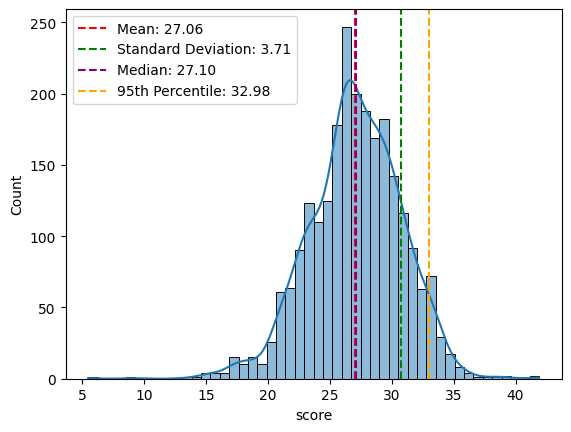

In [61]:
plot_histogram(results_df)

### View the top highest 5% CLIP score clips (diversify)

In [82]:
top5percent_diversify = results_df.iloc[result_rank_diversify]

In [83]:
top5percent_diversify.describe()

,score
count,118.000000
mean,34.138943
std,1.629470
min,32.463978
25%,33.175454
50%,33.716135
75%,34.426768
max,41.904305


/var/folders/9k/v3mgfmnx32b02fjpln953dzr0000gn/T/ipykernel_27085/2965220696.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = pd.to_numeric(df['score'], errors='coerce')
/Users/matthewheng/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


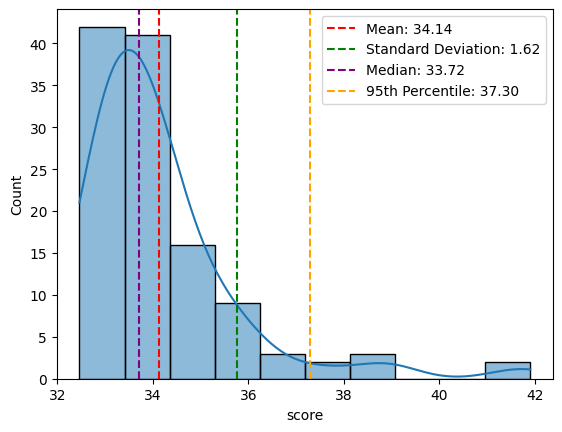

In [85]:
plot_histogram(top5percent_diversify)

### View the top higest 5% CLIP score clips (normal)

In [86]:
top5percent_normal = results_df.iloc[result_rank_normal]

In [97]:
top5percent_normal.describe()

,score
count,118.000000
mean,34.234958
std,1.555078
min,32.992783
25%,33.331089
50%,33.716135
75%,34.426768
max,41.904305


/var/folders/9k/v3mgfmnx32b02fjpln953dzr0000gn/T/ipykernel_27085/2965220696.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = pd.to_numeric(df['score'], errors='coerce')
/Users/matthewheng/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


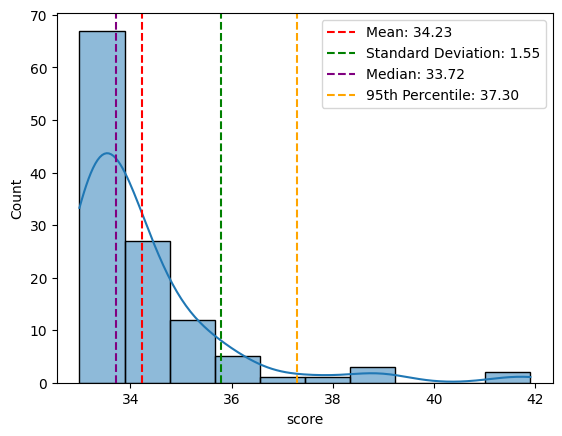

In [87]:
plot_histogram(top5percent_normal)

# 5.0 Save the final output the results directory

In [111]:
top5percent_diversify_file = './results/top5percent_diversify.jsonl'
top5percent_normal_file = './results/top5percent_normal_file.jsonl'

In [110]:
with open(top5percent_diversify_file, 'w') as f:
    top5percent_diversify.to_json(f, orient='records', lines=True)

with open(top5percent_normal_file, 'w') as f:
    top5percent_normal.to_json(f, orient='records', lines=True)
